# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


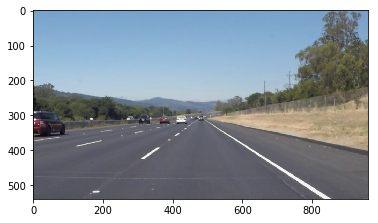

In [2]:
#reading in an image
image = mpimg.imread('C:/Users/fuzer/Documents/DocumentsTech/Courses/Udacity/SelfDrivingCar/CarND-LaneLines-P1-master/test_images/solidWhiteRight.jpg',0)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [7]:
import math

def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)


def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [img.shape[0], img.shape[1]]
    #print("image size : ", imshape)
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)


    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    

    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)    
    
    
#    for line in lines:
#        for x1,y1,x2,y2 in line:
#            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    print("Hough lines: ", lines)    
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Hough lines:  [[[632 391 898 538]]

 [[584 369 877 538]]

 [[280 460 456 332]]

 [[295 461 461 322]]

 [[294 449 468 322]]

 [[289 463 458 327]]

 [[323 426 437 340]]]
image size :  [540, 960]
Slope & intercept:  [[0.55263157894736847, 41.736842105263122], [0.57679180887372017, 32.153583617747415]]
Slope:  0.564711693911 Intercept:  36.9452128615
Slope & intercept:  [[-0.72727272727272729, 663.63636363636363], [-0.83734939759036142, 708.01807228915663], [-0.72988505747126442, 663.58620689655174], [-0.80473372781065089, 695.56804733727813], [-0.75438596491228072, 669.66666666666663]]
Slope:  -0.770725375011 Intercept:  680.095071365
Coef:  0.564711693911 Intercept:  36.9452128615 intersection_x:  481.602520606
Point one:  (481, 308) Point two:  (960, 579)
Coef:  -0.770725375011 Intercept:  680.095071365 intersection_x:  481.602520606
Point one:  (481, 308) Point two:  (0, 680)
solidWhiteCurve.jpg
Hough lines:  [[[573 364 853 539]]

 [[550 354 831 537]]

 [[551 354 760 490]]

 [[312 422 

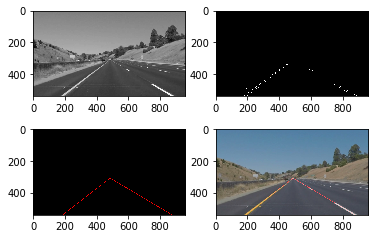

In [14]:
import os
import msvcrt as m

def draw_lane_lines(image):
    imshape = image.shape
    #print(imshape)
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    #print(lines_image.shape)    
    plt.subplot(2,2,3)
    plt.imshow(lines_image) 
    # Combine lines image with original image
    final_image = weighted_img(lines_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image) 
    return final_image

imageNames = os.listdir("test_images/")

# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in imageNames]
for i in range(len(test_images)):
    final_image = draw_lane_lines(test_images[i])
    current_image_name = imageNames[i]
    print(current_image_name)
    mpimg.imsave("test_images_output/" + current_image_name, final_image )
#print(i)
    

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)   
    result = draw_lane_lines(image)
    #print(result.shape)

    return result

Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
Hough lines:  [[[575 365 755 481]]

 [[603 378 869 538]]

 [[202 514 452 326]]

 [[217 490 446 329]]

 [[798 508 848 538]]

 [[605 379 774 493]]

 [[604 378 714 444]]

 [[192 508 366 390]]

 [[572 364 697 442]]

 [[187 514 429 338]]

 [[790 503 832 528]]]
Slope & intercept:  [[0.64444444444444449, -5.5555555555555998], [0.60150375939849621, 15.293233082706763], [0.59999999999999998, 29.200000000000045], [0.67455621301775148, -29.106508875739621], [0.59999999999999998, 15.600000000000023], [0.624, 7.0720000000000027]]
Slope:  0.613989640769 Intercept:  12.3219355054
Slope & intercept:  [[-0.752, 665.904], [-0.70305676855895194, 642.56331877729258], [-0.67816091954022983, 638.20689655172418], [-0.72727272727272729, 650.0]]
Slope:  -0.715122603843 Intercept:  649.168553832
Coef:  0.613989640769 Intercept:  12.3219355054 intersection_x:  479.151870663
Point one:  (479, 306) Point two:  (960, 601)
Coef:  -0.715122603843 Intercept:  649.168553832 intersection_x:  479.151870663


  0%|                                                  | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
Hough lines:  [[[575 365 755 481]]

 [[603 378 869 538]]

 [[202 514 452 326]]

 [[217 490 446 329]]

 [[798 508 848 538]]

 [[605 379 774 493]]

 [[604 378 714 444]]

 [[192 508 366 390]]

 [[572 364 697 442]]

 [[187 514 429 338]]

 [[790 503 832 528]]]
Slope & intercept:  [[0.64444444444444449, -5.5555555555555998], [0.60150375939849621, 15.293233082706763], [0.59999999999999998, 29.200000000000045], [0.67455621301775148, -29.106508875739621], [0.59999999999999998, 15.600000000000023], [0.624, 7.0720000000000027]]
Slope:  0.613989640769 Intercept:  12.3219355054
Slope & intercept:  [[-0.752, 665.904], [-0.70305676855895194, 642.56331877729258], [-0.67816091954022983, 638.20689655172418], [-0.72727272727272729, 650.0]]
Slope:  -0.715122603843 Intercept:  649.168553832
Coef:  0.613989640769 Intercept:  12.3219355054 intersection_x:  479.151870663
Point one:  (479, 306) Point two:  (960, 601)
Coef:  -0.715122603843 Intercept:  649.168553832 intersection_x:  479.151870663


  0%|▏                                         | 1/222 [00:00<00:33,  6.58it/s]

(540, 960, 3)
Hough lines:  [[[599 376 868 538]]

 [[601 381 845 539]]

 [[170 539 454 325]]

 [[151 538 347 396]]

 [[574 366 722 449]]

 [[793 504 843 537]]

 [[621 389 694 432]]

 [[281 446 430 338]]

 [[165 527 450 327]]

 [[283 446 453 327]]]
Slope & intercept:  [[0.60223048327137552, 15.263940520446056], [0.64754098360655743, -8.1721311475409948], [0.56081081081081086, 44.094594594594582], [0.66000000000000003, -19.379999999999995], [0.58904109589041098, 23.20547945205476]]
Slope:  0.611924674716 Intercept:  11.0023766839
Slope & intercept:  [[-0.75352112676056338, 667.09859154929575], [-0.72448979591836737, 647.39795918367349], [-0.72483221476510062, 649.67785234899327], [-0.70175438596491224, 642.78947368421052], [-0.69999999999999996, 644.10000000000002]]
Slope:  -0.720919504682 Intercept:  650.212775353
Coef:  0.611924674716 Intercept:  11.0023766839 intersection_x:  479.583741708
Point one:  (479, 304) Point two:  (960, 598)
Coef:  -0.720919504682 Intercept:  650.212775353 i

  1%|▍                                         | 2/222 [00:00<00:33,  6.59it/s]

(540, 960, 3)
Hough lines:  [[[771 480 868 539]]

 [[564 360 778 494]]

 [[171 538 454 325]]

 [[151 538 249 467]]

 [[802 511 846 539]]

 [[633 395 753 469]]

 [[765 487 812 516]]

 [[793 493 852 528]]

 [[570 363 626 397]]

 [[637 405 791 491]]

 [[336 405 443 330]]

 [[605 385 752 467]]

 [[738 468 815 519]]

 [[595 374 665 414]]]
Slope & intercept:  [[0.60824742268041232, 11.041237113402076], [0.62616822429906538, 6.8411214953271156], [0.63636363636363635, 0.63636363636362603], [0.6166666666666667, 4.6499999999999773], [0.61702127659574468, 14.978723404255334], [0.59322033898305082, 22.576271186440692], [0.6071428571428571, 16.928571428571445], [0.55844155844155841, 49.272727272727309], [0.55782312925170063, 47.517006802721141], [0.66233766233766234, -20.805194805194787], [0.5714285714285714, 34.0]]
Slope:  0.599252368185 Intercept:  20.844202234
Slope & intercept:  [[-0.75265017667844525, 666.7031802120141], [-0.72448979591836737, 647.39795918367349], [-0.7009345794392523, 640.514

  1%|▌                                         | 3/222 [00:00<00:32,  6.68it/s]

(540, 960, 3)
Hough lines:  [[[595 374 868 538]]

 [[568 362 717 455]]

 [[169 538 225 496]]

 [[149 538 212 494]]

 [[740 471 802 509]]

 [[322 415 445 329]]

 [[326 417 443 332]]

 [[727 463 847 538]]

 [[693 441 755 479]]

 [[604 378 810 502]]

 [[148 538 211 494]]

 [[328 417 456 324]]]
Slope & intercept:  [[0.60073260073260071, 16.564102564102598], [0.62416107382550334, 7.4765100671140772], [0.61290322580645162, 17.451612903225794], [0.625, 8.625], [0.61290322580645162, 16.258064516129025], [0.60194174757281549, 14.427184466019469]]
Slope:  0.612940312291 Intercept:  13.4670790861
Slope & intercept:  [[-0.75, 664.75], [-0.69841269841269837, 642.06349206349205], [-0.69918699186991873, 640.13821138211381], [-0.72649572649572647, 653.83760683760681], [-0.69841269841269837, 641.3650793650794], [-0.7265625, 655.3125]]
Slope:  -0.716511769199 Intercept:  649.577814941
Coef:  0.612940312291 Intercept:  13.4670790861 intersection_x:  478.475865894
Point one:  (478, 306) Point two:  (960, 

  2%|▊                                         | 4/222 [00:00<00:33,  6.53it/s]

(540, 960, 3)
Hough lines:  [[[711 452 848 538]]

 [[595 374 870 539]]

 [[605 379 870 538]]

 [[657 418 724 459]]

 [[566 361 653 414]]

 [[312 429 456 324]]

 [[305 429 437 333]]

 [[306 429 454 325]]

 [[308 429 383 371]]

 [[635 404 704 446]]]
Slope & intercept:  [[0.62773722627737227, 5.6788321167883282], [0.59999999999999998, 17.0], [0.59999999999999998, 16.0], [0.61194029850746268, 15.955223880597032], [0.60919540229885061, 16.195402298850581], [0.60869565217391308, 17.47826086956519]]
Slope:  0.605966270596 Intercept:  16.5257774098
Slope & intercept:  [[-0.72916666666666663, 656.5], [-0.72727272727272729, 650.81818181818176], [-0.70270270270270274, 644.02702702702709], [-0.77333333333333332, 667.18666666666672]]
Slope:  -0.733118857494 Intercept:  654.632968878
Coef:  0.605966270596 Intercept:  16.5257774098 intersection_x:  476.524739229
Point one:  (476, 305) Point two:  (960, 598)
Coef:  -0.733118857494 Intercept:  654.632968878 intersection_x:  476.524739229
Point one:  (4

  2%|▉                                         | 5/222 [00:00<00:32,  6.66it/s]

(540, 960, 3)
Hough lines:  [[[573 364 742 470]]

 [[595 374 870 539]]

 [[604 378 867 536]]

 [[783 498 847 537]]

 [[568 362 804 510]]

 [[601 377 870 538]]

 [[291 443 439 332]]

 [[292 443 454 325]]

 [[283 441 423 343]]]
Slope & intercept:  [[0.62721893491124259, 4.6035502958579855], [0.59999999999999998, 17.0], [0.60076045627376429, 15.140684410646372], [0.609375, 20.859375], [0.6271186440677966, 5.7966101694915437], [0.5985130111524164, 17.293680297397771]]
Slope:  0.610497674401 Intercept:  13.4489833622
Slope & intercept:  [[-0.75, 661.25], [-0.72839506172839508, 655.69135802469134], [-0.69999999999999996, 639.10000000000002]]
Slope:  -0.726131687243 Intercept:  652.013786008
Coef:  0.610497674401 Intercept:  13.4489833622 intersection_x:  477.742612104
Point one:  (477, 305) Point two:  (960, 599)
Coef:  -0.726131687243 Intercept:  652.013786008 intersection_x:  477.742612104
Point one:  (477, 305) Point two:  (0, 652)
(540, 960, 3)


  3%|█▏                                        | 6/222 [00:00<00:34,  6.18it/s]

(540, 960, 3)
Hough lines:  [[[570 363 799 506]]

 [[628 392 871 538]]

 [[603 378 870 538]]

 [[251 463 439 332]]

 [[263 463 451 327]]

 [[797 506 849 538]]]
Slope & intercept:  [[0.62445414847161573, 7.0611353711790343], [0.60082304526748975, 14.683127572016417], [0.59925093632958804, 16.65168539325839], [0.61538461538461542, 15.53846153846149]]
Slope:  0.609978186363 Intercept:  13.4836024687
Slope & intercept:  [[-0.69680851063829785, 637.89893617021278], [-0.72340425531914898, 653.25531914893622]]
Slope:  -0.710106382979 Intercept:  645.57712766
Coef:  0.609978186363 Intercept:  13.4836024687 intersection_x:  478.828053801
Point one:  (478, 305) Point two:  (960, 599)
Coef:  -0.710106382979 Intercept:  645.57712766 intersection_x:  478.828053801
Point one:  (478, 305) Point two:  (0, 645)
(540, 960, 3)


  3%|█▎                                        | 7/222 [00:01<00:37,  5.79it/s]

(540, 960, 3)
Hough lines:  [[[570 363 850 538]]

 [[636 397 872 538]]

 [[599 376 795 493]]

 [[215 491 392 363]]

 [[228 488 452 326]]

 [[331 408 438 333]]

 [[815 503 871 537]]]
Slope & intercept:  [[0.625, 6.75], [0.59745762711864403, 17.016949152542395], [0.59693877551020413, 18.433673469387713], [0.6071428571428571, 8.1785714285714448]]
Slope:  0.600513086591 Intercept:  14.5430646835
Slope & intercept:  [[-0.7231638418079096, 646.48022598870057], [-0.7232142857142857, 652.89285714285711], [-0.7009345794392523, 640.00934579439252]]
Slope:  -0.71577090232 Intercept:  646.460809642
Coef:  0.600513086591 Intercept:  14.5430646835 intersection_x:  480.077058053
Point one:  (480, 302) Point two:  (960, 591)
Coef:  -0.71577090232 Intercept:  646.460809642 intersection_x:  480.077058053
Point one:  (480, 302) Point two:  (0, 646)
(540, 960, 3)


  4%|█▌                                        | 8/222 [00:01<00:40,  5.30it/s]

(540, 960, 3)
Hough lines:  [[[568 362 725 460]]

 [[595 374 871 539]]

 [[309 422 435 334]]

 [[760 482 848 539]]

 [[316 425 454 325]]

 [[605 379 871 538]]

 [[723 460 775 492]]

 [[310 422 436 334]]

 [[596 380 643 409]]

 [[683 434 789 502]]]
Slope & intercept:  [[0.62420382165605093, 7.4522292993630685], [0.59782608695652173, 18.293478260869563], [0.64772727272727271, -10.272727272727252], [0.59774436090225569, 17.364661654135318], [0.61538461538461542, 15.076923076923038], [0.61702127659574468, 12.255319148936167], [0.64150943396226412, -4.1509433962264097]]
Slope:  0.615614932576 Intercept:  11.0486113407
Slope & intercept:  [[-0.69841269841269837, 637.80952380952385], [-0.72463768115942029, 653.98550724637676], [-0.69841269841269837, 638.50793650793651]]
Slope:  -0.707154359328 Intercept:  643.434322521
Coef:  0.615614932576 Intercept:  11.0486113407 intersection_x:  478.077103128
Point one:  (478, 305) Point two:  (960, 602)
Coef:  -0.707154359328 Intercept:  643.434322521 in

  4%|█▋                                        | 9/222 [00:01<00:42,  5.00it/s]

(540, 960, 3)
Hough lines:  [[[584 369 866 538]]

 [[597 383 844 538]]

 [[306 426 460 322]]

 [[322 424 434 337]]

 [[588 377 635 406]]

 [[289 439 449 331]]

 [[296 441 462 321]]

 [[557 357 650 409]]

 [[582 373 727 454]]]
Slope & intercept:  [[0.599290780141844, 19.014184397163092], [0.62753036437246967, 8.3643724696356117], [0.61702127659574468, 14.191489361702111], [0.55913978494623651, 45.55913978494624], [0.55862068965517242, 47.882758620689629]]
Slope:  0.592320579142 Intercept:  27.0023889268
Slope & intercept:  [[-0.67532467532467533, 632.64935064935071], [-0.7767857142857143, 674.125], [-0.67500000000000004, 634.07500000000005], [-0.72289156626506024, 654.97590361445782]]
Slope:  -0.712500488969 Intercept:  648.956313566
Coef:  0.592320579142 Intercept:  27.0023889268 intersection_x:  476.658401553
Point one:  (476, 309) Point two:  (960, 595)
Coef:  -0.712500488969 Intercept:  648.956313566 intersection_x:  476.658401553
Point one:  (476, 309) Point two:  (0, 648)
(540, 96

  5%|█▊                                       | 10/222 [00:01<00:40,  5.24it/s]

(540, 960, 3)
Hough lines:  [[[608 387 859 538]]

 [[607 392 817 524]]

 [[263 458 452 326]]

 [[339 413 456 325]]

 [[568 362 860 538]]

 [[272 461 467 320]]

 [[544 351 693 447]]

 [[568 365 837 539]]

 [[271 461 465 320]]]
Slope & intercept:  [[0.60159362549800799, 21.231075697211168], [0.62857142857142856, 10.457142857142856], [0.60273972602739723, 19.643835616438366], [0.64429530201342278, 0.5033557046980377], [0.64684014869888473, -2.4052044609665018]]
Slope:  0.624808046162 Intercept:  9.8860410829
Slope & intercept:  [[-0.69841269841269837, 641.68253968253964], [-0.75213675213675213, 667.97435897435901], [-0.72307692307692306, 657.676923076923], [-0.72680412371134018, 657.96391752577324]]
Slope:  -0.725107624334 Intercept:  656.324434815
Coef:  0.624808046162 Intercept:  9.8860410829 intersection_x:  478.873168051
Point one:  (478, 309) Point two:  (960, 609)
Coef:  -0.725107624334 Intercept:  656.324434815 intersection_x:  478.873168051
Point one:  (478, 309) Point two:  (0, 6

  5%|██                                       | 11/222 [00:01<00:40,  5.25it/s]

(540, 960, 3)
Hough lines:  [[[540 349 807 522]]

 [[546 352 857 538]]

 [[240 485 467 320]]

 [[230 483 316 421]]

 [[238 485 464 321]]

 [[720 465 764 494]]

 [[568 363 645 410]]

 [[230 482 456 324]]

 [[661 420 806 521]]

 [[613 397 716 464]]]
Slope & intercept:  [[0.64794007490636707, -0.88764044943820863], [0.59807073954983925, 25.453376205787777], [0.65909090909090906, -9.5454545454545041], [0.61038961038961037, 16.298701298701303], [0.69655172413793098, -40.420689655172396], [0.65048543689320393, -1.7475728155339993]]
Slope:  0.633195354166 Intercept:  5.91428193881
Slope & intercept:  [[-0.72687224669603523, 659.44933920704852], [-0.72093023255813948, 648.81395348837214], [-0.72566371681415931, 657.70796460176985], [-0.69911504424778759, 642.7964601769911]]
Slope:  -0.724488732023 Intercept:  655.323752432
Coef:  0.633195354166 Intercept:  5.91428193881 intersection_x:  478.32148664
Point one:  (478, 308) Point two:  (960, 613)
Coef:  -0.724488732023 Intercept:  655.323752432 

  5%|██▏                                      | 12/222 [00:02<00:36,  5.69it/s]

(540, 960, 3)
Hough lines:  [[[608 393 828 536]]

 [[566 361 767 486]]

 [[183 514 452 326]]

 [[195 516 465 320]]

 [[717 454 845 533]]

 [[544 351 595 383]]

 [[264 456 456 326]]

 [[553 357 833 539]]

 [[198 515 287 450]]]
Slope & intercept:  [[0.65000000000000002, -2.1999999999999886], [0.62189054726368154, 9.0099502487562404], [0.6171875, 11.4765625], [0.62745098039215685, 9.6666666666666856], [0.65000000000000002, -2.4499999999999886]]
Slope:  0.633305805531 Intercept:  5.10063588308
Slope & intercept:  [[-0.6988847583643123, 641.89591078066917], [-0.72592592592592597, 657.55555555555554], [-0.67708333333333337, 634.75], [-0.7303370786516854, 659.60674157303367]]
Slope:  -0.708057774069 Intercept:  648.452051977
Coef:  0.633305805531 Intercept:  5.10063588308 intersection_x:  479.624932329
Point one:  (479, 308) Point two:  (960, 613)
Coef:  -0.708057774069 Intercept:  648.452051977 intersection_x:  479.624932329
Point one:  (479, 308) Point two:  (0, 648)
(540, 960, 3)


  6%|██▍                                      | 13/222 [00:02<00:35,  5.95it/s]

(540, 960, 3)
Hough lines:  [[[743 469 855 538]]

 [[646 417 833 539]]

 [[144 538 413 350]]

 [[164 539 429 340]]

 [[650 411 747 473]]

 [[551 354 669 431]]

 [[579 367 676 429]]

 [[164 538 425 342]]

 [[284 446 444 334]]

 [[575 365 834 526]]]
Slope & intercept:  [[0.6160714285714286, 11.258928571428555], [0.65240641711229952, -4.4545454545454959], [0.63917525773195871, -4.4639175257731836], [0.65254237288135597, -5.5508474576271283], [0.63917525773195871, -3.082474226804095], [0.6216216216216216, 7.5675675675676075]]
Slope:  0.636832059275 Intercept:  0.212451912374
Slope & intercept:  [[-0.6988847583643123, 638.63940520446101], [-0.75094339622641515, 662.15471698113208], [-0.75095785440613028, 661.15708812260539], [-0.69999999999999996, 644.79999999999995]]
Slope:  -0.725196502249 Intercept:  651.687802577
Coef:  0.636832059275 Intercept:  0.212451912374 intersection_x:  478.312547231
Point one:  (478, 304) Point two:  (960, 611)
Coef:  -0.725196502249 Intercept:  651.687802577 i

  6%|██▌                                      | 14/222 [00:02<00:33,  6.22it/s]

(540, 960, 3)
Hough lines:  [[[640 411 835 538]]

 [[584 369 857 539]]

 [[161 538 444 332]]

 [[142 538 425 340]]

 [[604 387 648 415]]

 [[680 438 835 539]]

 [[201 508 444 331]]

 [[751 474 857 538]]

 [[142 539 428 339]]]
Slope & intercept:  [[0.6512820512820513, -5.8205128205128176], [0.62271062271062272, 5.3369963369963216], [0.63636363636363635, 2.636363636363626], [0.65161290322580645, -5.0967741935484128], [0.60377358490566035, 20.566037735849079]]
Slope:  0.633148559698 Intercept:  3.52442213903
Slope & intercept:  [[-0.72791519434628971, 655.19434628975262], [-0.69964664310954061, 637.34982332155482], [-0.72839506172839508, 654.40740740740739], [-0.69930069930069927, 638.30069930069931]]
Slope:  -0.713814399621 Intercept:  646.31306908
Coef:  0.633148559698 Intercept:  3.52442213903 intersection_x:  477.213306048
Point one:  (477, 305) Point two:  (960, 611)
Coef:  -0.713814399621 Intercept:  646.31306908 intersection_x:  477.213306048
Point one:  (477, 305) Point two:  (0, 

  7%|██▊                                      | 15/222 [00:02<00:32,  6.43it/s]

(540, 960, 3)
Hough lines:  [[[595 374 859 539]]

 [[604 384 810 522]]

 [[158 538 222 492]]

 [[320 411 424 339]]

 [[143 534 208 490]]

 [[573 364 740 476]]

 [[324 413 427 343]]

 [[157 538 221 492]]

 [[321 412 426 339]]

 [[148 531 212 489]]]
Slope & intercept:  [[0.625, 2.125], [0.66990291262135926, -20.621359223300999], [0.6706586826347305, -20.287425149700596]]
Slope:  0.655187198419 Intercept:  -12.9279281243
Slope & intercept:  [[-0.71875, 651.5625], [-0.69230769230769229, 632.53846153846155], [-0.67692307692307696, 630.79999999999995], [-0.67961165048543692, 633.19417475728153], [-0.71875, 650.84375], [-0.69523809523809521, 635.17142857142858], [-0.65625, 628.125]]
Slope:  -0.696930085826 Intercept:  639.018385811
Coef:  0.655187198419 Intercept:  -12.9279281243 intersection_x:  482.166984723
Point one:  (482, 302) Point two:  (960, 616)
Coef:  -0.696930085826 Intercept:  639.018385811 intersection_x:  482.166984723
Point one:  (482, 302) Point two:  (0, 639)
(540, 960, 3)


  7%|██▉                                      | 16/222 [00:02<00:34,  5.91it/s]

(540, 960, 3)
Hough lines:  [[[581 368 800 515]]

 [[599 376 859 538]]

 [[721 461 837 539]]

 [[305 424 442 331]]

 [[304 423 423 340]]

 [[308 424 410 355]]]
Slope & intercept:  [[0.67123287671232879, -21.986301369863043], [0.62307692307692308, 2.776923076923083], [0.67241379310344829, -23.810344827586221]]
Slope:  0.655574530964 Intercept:  -14.3399077068
Slope & intercept:  [[-0.67883211678832112, 631.043795620438], [-0.69747899159663862, 635.03361344537814], [-0.67647058823529416, 632.35294117647061]]
Slope:  -0.68426056554 Intercept:  632.810116747
Coef:  0.655574530964 Intercept:  -14.3399077068 intersection_x:  483.007219428
Point one:  (483, 302) Point two:  (960, 615)
Coef:  -0.68426056554 Intercept:  632.810116747 intersection_x:  483.007219428
Point one:  (483, 302) Point two:  (0, 632)
(540, 960, 3)


  8%|███▏                                     | 17/222 [00:02<00:36,  5.56it/s]

(540, 960, 3)
Hough lines:  [[[622 396 825 532]]

 [[597 375 858 538]]

 [[722 454 789 495]]

 [[293 439 442 331]]

 [[282 437 437 333]]

 [[795 500 857 538]]

 [[577 366 631 403]]

 [[779 500 824 531]]]
Slope & intercept:  [[0.66995073891625612, -20.709359605911288], [0.62452107279693492, 2.1609195402298269], [0.61194029850746268, 12.179104477611929], [0.61290322580645162, 12.741935483870975], [0.68518518518518523, -29.351851851851904], [0.68888888888888888, -36.644444444444389]]
Slope:  0.648898235017 Intercept:  -9.93728273342
Slope & intercept:  [[-0.72483221476510062, 651.37583892617454], [-0.67096774193548392, 626.21290322580649]]
Slope:  -0.69789997835 Intercept:  638.794371076
Coef:  0.648898235017 Intercept:  -9.93728273342 intersection_x:  481.684373628
Point one:  (481, 302) Point two:  (960, 613)
Coef:  -0.69789997835 Intercept:  638.794371076 intersection_x:  481.684373628
Point one:  (481, 302) Point two:  (0, 638)
(540, 960, 3)


  8%|███▎                                     | 18/222 [00:03<00:38,  5.31it/s]

(540, 960, 3)
Hough lines:  [[[590 372 856 538]]

 [[615 394 786 506]]

 [[610 385 855 538]]

 [[562 359 699 448]]

 [[761 491 827 533]]

 [[264 459 441 335]]

 [[339 400 441 334]]]
Slope & intercept:  [[0.62406015037593987, 3.8045112781954913], [0.65497076023391809, -8.8070175438596152], [0.6244897959183674, 4.0612244897959044], [0.64963503649635035, -6.0948905109489147], [0.63636363636363635, 6.7272727272727479]]
Slope:  0.637903875878 Intercept:  -0.0617799119089
Slope & intercept:  [[-0.70056497175141241, 643.94915254237287], [-0.6470588235294118, 619.35294117647061]]
Slope:  -0.67381189764 Intercept:  631.651046859
Coef:  0.637903875878 Intercept:  -0.0617799119089 intersection_x:  481.592765388
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.67381189764 Intercept:  631.651046859 intersection_x:  481.592765388
Point one:  (481, 307) Point two:  (0, 631)
(540, 960, 3)


  9%|███▌                                     | 19/222 [00:03<00:35,  5.66it/s]

(540, 960, 3)
Hough lines:  [[[558 358 817 527]]

 [[584 369 855 538]]

 [[234 485 458 323]]

 [[220 485 435 335]]

 [[695 448 833 538]]

 [[583 374 641 411]]

 [[720 455 787 496]]

 [[566 363 686 433]]]
Slope & intercept:  [[0.65250965250965254, -6.1003861003861175], [0.62361623616236161, 4.808118081180794], [0.65217391304347827, -5.2608695652173765], [0.63793103448275867, 2.0862068965516869], [0.61194029850746268, 14.402985074626883], [0.58333333333333337, 32.833333333333314]]
Slope:  0.62691741134 Intercept:  7.12823128668
Slope & intercept:  [[-0.7232142857142857, 654.23214285714289], [-0.69767441860465118, 638.48837209302326]]
Slope:  -0.710444352159 Intercept:  646.360257475
Coef:  0.62691741134 Intercept:  7.12823128668 intersection_x:  477.979888191
Point one:  (477, 306) Point two:  (960, 608)
Coef:  -0.710444352159 Intercept:  646.360257475 intersection_x:  477.979888191
Point one:  (477, 306) Point two:  (0, 646)
(540, 960, 3)


  9%|███▋                                     | 20/222 [00:03<00:33,  5.99it/s]

(540, 960, 3)
Hough lines:  [[[579 367 854 538]]

 [[636 410 832 538]]

 [[551 354 719 463]]

 [[310 423 460 322]]

 [[319 425 462 321]]

 [[573 364 853 539]]]
Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.65306122448979587, -5.346938775510182], [0.64880952380952384, -3.4940476190476488], [0.625, 5.875]]
Slope:  0.637172232529 Intercept:  1.00032158318
Slope & intercept:  [[-0.67333333333333334, 631.73333333333335], [-0.72727272727272729, 657.0]]
Slope:  -0.700303030303 Intercept:  644.366666667
Coef:  0.637172232529 Intercept:  1.00032158318 intersection_x:  481.030463114
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.700303030303 Intercept:  644.366666667 intersection_x:  481.030463114
Point one:  (481, 307) Point two:  (0, 644)
(540, 960, 3)


  9%|███▉                                     | 21/222 [00:03<00:31,  6.35it/s]

(540, 960, 3)
Hough lines:  [[[577 366 854 539]]

 [[548 353 833 538]]

 [[553 355 653 420]]

 [[290 437 464 320]]

 [[308 434 448 329]]

 [[300 439 438 339]]

 [[573 364 836 528]]]
Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64912280701754388, -2.7192982456140271], [0.65000000000000002, -4.4499999999999886], [0.62357414448669202, 6.6920152091254863]]
Slope:  0.636811421992 Intercept:  1.28952400622
Slope & intercept:  [[-0.67241379310344829, 632.0], [-0.75, 665.0], [-0.72463768115942029, 656.39130434782612]]
Slope:  -0.715683824754 Intercept:  651.130434783
Coef:  0.636811421992 Intercept:  1.28952400622 intersection_x:  480.475559777
Point one:  (480, 307) Point two:  (960, 612)
Coef:  -0.715683824754 Intercept:  651.130434783 intersection_x:  480.475559777
Point one:  (480, 307) Point two:  (0, 651)
(540, 960, 3)


 10%|████                                     | 22/222 [00:03<00:30,  6.52it/s]

(540, 960, 3)
Hough lines:  [[[579 367 854 538]]

 [[695 449 832 538]]

 [[553 355 682 439]]

 [[264 454 462 321]]

 [[276 456 464 320]]

 [[653 421 833 538]]

 [[266 457 452 326]]]
Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.64963503649635035, -2.4963503649635186], [0.65116279069767447, -5.0930232558139892], [0.65000000000000002, -3.4499999999999886]]
Slope:  0.643154002253 Intercept:  -1.01802522338
Slope & intercept:  [[-0.67171717171717171, 631.33333333333337], [-0.72340425531914898, 655.65957446808511], [-0.70430107526881724, 644.3440860215054]]
Slope:  -0.699807500768 Intercept:  643.778997941
Coef:  0.643154002253 Intercept:  -1.01802522338 intersection_x:  480.13068261
Point one:  (480, 307) Point two:  (960, 616)
Coef:  -0.699807500768 Intercept:  643.778997941 intersection_x:  480.13068261
Point one:  (480, 307) Point two:  (0, 643)
(540, 960, 3)


 10%|████▏                                    | 23/222 [00:03<00:30,  6.52it/s]

(540, 960, 3)
Hough lines:  [[[579 367 854 539]]

 [[751 484 833 539]]

 [[551 354 832 537]]

 [[232 476 462 321]]

 [[246 478 443 330]]

 [[555 356 629 403]]

 [[295 443 446 330]]

 [[285 450 406 356]]

 [[584 369 641 404]]

 [[259 457 424 349]]]
Slope & intercept:  [[0.62545454545454549, 4.861818181818137], [0.67073170731707321, -19.719512195121979], [0.6512455516014235, -4.8362989323843522], [0.63513513513513509, 3.5], [0.61403508771929827, 10.403508771929808]]
Slope:  0.631467579978 Intercept:  3.48225700534
Slope & intercept:  [[-0.67391304347826086, 632.3478260869565], [-0.75126903553299496, 662.81218274111677], [-0.7483443708609272, 663.76158940397352], [-0.77685950413223137, 671.40495867768595], [-0.65454545454545454, 626.5272727272727]]
Slope:  -0.72098628171 Intercept:  651.370765927
Coef:  0.631467579978 Intercept:  3.48225700534 intersection_x:  479.046662718
Point one:  (479, 305) Point two:  (960, 609)
Coef:  -0.72098628171 Intercept:  651.370765927 intersection_x:  479.0

 11%|████▍                                    | 24/222 [00:04<00:29,  6.67it/s]

(540, 960, 3)
Hough lines:  [[[583 369 855 538]]

 [[559 358 702 451]]

 [[186 507 458 323]]

 [[201 510 273 459]]

 [[691 445 834 538]]

 [[200 510 456 324]]

 [[588 371 854 537]]

 [[295 443 417 348]]

 [[186 509 359 388]]]
Slope & intercept:  [[0.62132352941176472, 6.7683823529411598], [0.65034965034965031, -5.5454545454545041], [0.65034965034965031, -4.3916083916083721], [0.62406015037593987, 4.0526315789473415]]
Slope:  0.636520745122 Intercept:  0.220987748706
Slope & intercept:  [[-0.67647058823529416, 632.82352941176475], [-0.70833333333333337, 652.375], [-0.7265625, 655.3125], [-0.77868852459016391, 672.71311475409834], [-0.69942196531791911, 639.09248554913302]]
Slope:  -0.717895382295 Intercept:  650.463325943
Coef:  0.636520745122 Intercept:  0.220987748706 intersection_x:  480.09051652
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.717895382295 Intercept:  650.463325943 intersection_x:  480.09051652
Point one:  (480, 305) Point two:  (0, 650)
(540, 960, 3)


 11%|████▌                                    | 25/222 [00:04<00:29,  6.74it/s]

(540, 960, 3)
Hough lines:  [[[583 369 854 538]]

 [[559 358 716 460]]

 [[162 538 458 323]]

 [[748 483 833 538]]

 [[140 538 456 324]]

 [[163 538 433 342]]

 [[682 439 740 476]]

 [[588 371 761 479]]

 [[161 526 213 489]]

 [[148 535 348 395]]

 [[349 395 445 330]]]
Slope & intercept:  [[0.62361623616236161, 5.4317343173431709], [0.64968152866242035, -5.1719745222929987], [0.6470588235294118, -1.0], [0.63793103448275867, 3.931034482758605], [0.62427745664739887, 3.9248554913294811]]
Slope:  0.636513015897 Intercept:  1.42312995383
Slope & intercept:  [[-0.72635135135135132, 655.66891891891896], [-0.67721518987341767, 632.81012658227849], [-0.72592592592592597, 656.32592592592596], [-0.71153846153846156, 640.55769230769226], [-0.69999999999999996, 638.60000000000002], [-0.67708333333333337, 631.30208333333337]]
Slope:  -0.70301904367 Intercept:  642.544124511
Coef:  0.636513015897 Intercept:  1.42312995383 intersection_x:  478.615640423
Point one:  (478, 306) Point two:  (960, 612)
C

 12%|████▊                                    | 26/222 [00:04<00:33,  5.85it/s]

(540, 960, 3)
Hough lines:  [[[581 368 854 538]]

 [[553 355 805 519]]

 [[164 539 347 406]]

 [[142 538 431 343]]

 [[691 445 832 537]]

 [[586 370 855 538]]

 [[337 404 456 324]]

 [[164 538 432 343]]

 [[571 366 637 408]]

 [[206 496 444 330]]]
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65079365079365081, -4.8888888888889142], [0.65248226950354615, -5.8652482269503707], [0.62453531598513012, 4.0223048327137576], [0.63636363636363635, 2.636363636363626]]
Slope:  0.637377099071 Intercept:  0.421931911673
Slope & intercept:  [[-0.72677595628415304, 658.19125683060111], [-0.67474048442906576, 633.81314878892738], [-0.67226890756302526, 630.55462184873954], [-0.72761194029850751, 657.32835820895525], [-0.69747899159663862, 639.68067226890753]]
Slope:  -0.699775256034 Intercept:  643.913611589
Coef:  0.637377099071 Intercept:  0.421931911673 intersection_x:  481.240359201
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.699775256034 Intercept:  643.913611589 

 12%|████▉                                    | 27/222 [00:04<00:35,  5.52it/s]

(540, 960, 3)
Hough lines:  [[[584 369 855 538]]

 [[553 355 833 537]]

 [[165 539 225 493]]

 [[142 539 213 491]]

 [[691 445 834 538]]

 [[324 414 460 322]]

 [[164 538 391 367]]

 [[377 383 456 324]]

 [[568 364 634 406]]]
Slope & intercept:  [[0.62361623616236161, 4.808118081180794], [0.65000000000000002, -4.4499999999999886], [0.65034965034965031, -4.3916083916083721], [0.63636363636363635, 2.545454545454561]]
Slope:  0.640082380719 Intercept:  -0.372008941243
Slope & intercept:  [[-0.76666666666666672, 665.5], [-0.676056338028169, 635.0], [-0.67647058823529416, 633.17647058823536], [-0.75330396475770922, 661.54185022026434], [-0.74683544303797467, 664.55696202531647]]
Slope:  -0.723866600145 Intercept:  651.955056567
Coef:  0.640082380719 Intercept:  -0.372008941243 intersection_x:  478.263538197
Point one:  (478, 305) Point two:  (960, 614)
Coef:  -0.723866600145 Intercept:  651.955056567 intersection_x:  478.263538197
Point one:  (478, 305) Point two:  (0, 651)
(540, 960, 3)


 13%|█████▏                                   | 28/222 [00:04<00:36,  5.30it/s]

(540, 960, 3)
Hough lines:  [[[577 366 855 539]]

 [[551 354 834 538]]

 [[721 465 833 538]]

 [[306 425 456 324]]

 [[771 485 846 533]]

 [[315 428 428 346]]

 [[710 447 782 493]]]
Slope & intercept:  [[0.62230215827338131, 6.9316546762589724], [0.65017667844522964, -4.2473498233215423], [0.6517857142857143, -4.9375], [0.64000000000000001, -8.4399999999999977], [0.63888888888888884, -6.6111111111110858]]
Slope:  0.640630687979 Intercept:  -3.46086125163
Slope & intercept:  [[-0.67333333333333334, 631.03999999999996], [-0.72566371681415931, 656.5840707964602]]
Slope:  -0.699498525074 Intercept:  643.812035398
Coef:  0.640630687979 Intercept:  -3.46086125163 intersection_x:  482.992901241
Point one:  (482, 305) Point two:  (960, 611)
Coef:  -0.699498525074 Intercept:  643.812035398 intersection_x:  482.992901241
Point one:  (482, 305) Point two:  (0, 643)
(540, 960, 3)


 13%|█████▎                                   | 29/222 [00:04<00:34,  5.67it/s]

(540, 960, 3)
Hough lines:  [[[555 356 835 538]]

 [[579 367 626 396]]

 [[674 424 857 538]]

 [[584 369 856 538]]

 [[298 441 448 328]]

 [[285 441 441 332]]

 [[585 375 651 417]]]
Slope & intercept:  [[0.65000000000000002, -4.75], [0.61702127659574468, 9.7446808510638334], [0.62295081967213117, 4.1311475409835907], [0.62132352941176472, 6.1470588235293917], [0.63636363636363635, 2.7272727272727479]]
Slope:  0.624414815511 Intercept:  5.68753998571
Slope & intercept:  [[-0.7533333333333333, 665.49333333333334], [-0.69871794871794868, 640.13461538461536]]
Slope:  -0.726025641026 Intercept:  652.813974359
Coef:  0.624414815511 Intercept:  5.68753998571 intersection_x:  479.196569713
Point one:  (479, 304) Point two:  (960, 605)
Coef:  -0.726025641026 Intercept:  652.813974359 intersection_x:  479.196569713
Point one:  (479, 304) Point two:  (0, 652)
(540, 960, 3)


 14%|█████▌                                   | 30/222 [00:05<00:31,  6.03it/s]

(540, 960, 3)
Hough lines:  [[[559 358 836 538]]

 [[590 372 857 538]]

 [[584 369 770 485]]

 [[269 459 454 325]]

 [[259 459 440 332]]

 [[561 359 629 402]]

 [[273 459 440 334]]]
Slope & intercept:  [[0.64981949458483756, -5.2490974729241771], [0.62172284644194753, 5.1835205992509827], [0.62365591397849462, 4.7849462365591648], [0.63235294117647056, 4.25]]
Slope:  0.625910567199 Intercept:  4.73948894527
Slope & intercept:  [[-0.72432432432432436, 653.84324324324325], [-0.7016574585635359, 640.72928176795585], [-0.74850299401197606, 663.34131736526945]]
Slope:  -0.724828258967 Intercept:  652.637947459
Coef:  0.625910567199 Intercept:  4.73948894527 intersection_x:  479.662275166
Point one:  (479, 304) Point two:  (960, 605)
Coef:  -0.724828258967 Intercept:  652.637947459 intersection_x:  479.662275166
Point one:  (479, 304) Point two:  (0, 652)
(540, 960, 3)


 14%|█████▋                                   | 31/222 [00:05<00:30,  6.28it/s]

(540, 960, 3)
Hough lines:  [[[559 358 836 538]]

 [[621 391 858 539]]

 [[584 369 801 504]]

 [[218 487 439 332]]

 [[238 483 422 349]]

 [[562 359 828 532]]

 [[239 483 421 346]]]
Slope & intercept:  [[0.64981949458483756, -5.2490974729241771], [0.62447257383966248, 3.2025316455695929], [0.62211981566820274, 5.6820276497696227], [0.65037593984962405, -6.5112781954887282]]
Slope:  0.636696955986 Intercept:  -0.718954093268
Slope & intercept:  [[-0.70135746606334837, 639.89592760180994], [-0.72826086956521741, 656.32608695652175], [-0.75274725274725274, 662.9065934065934]]
Slope:  -0.727455196125 Intercept:  653.042869322
Coef:  0.636696955986 Intercept:  -0.718954093268 intersection_x:  479.244065556
Point one:  (479, 304) Point two:  (960, 610)
Coef:  -0.727455196125 Intercept:  653.042869322 intersection_x:  479.244065556
Point one:  (479, 304) Point two:  (0, 653)
(540, 960, 3)


 14%|█████▉                                   | 32/222 [00:05<00:30,  6.21it/s]

(540, 960, 3)
Hough lines:  [[[597 376 858 539]]

 [[561 359 836 538]]

 [[321 422 419 351]]

 [[311 421 437 333]]

 [[584 369 677 427]]

 [[562 359 808 519]]

 [[319 423 438 333]]

 [[592 373 658 415]]

 [[322 414 452 326]]]
Slope & intercept:  [[0.62452107279693492, 3.1609195402298269], [0.65090909090909088, -6.1599999999999682], [0.62365591397849462, 4.7849462365591648], [0.65040650406504064, -6.5284552845528196], [0.63636363636363635, -3.7272727272727479]]
Slope:  0.637171243623 Intercept:  -1.69397244701
Slope & intercept:  [[-0.72448979591836737, 654.5612244897959], [-0.69841269841269837, 638.20634920634916], [-0.75630252100840334, 664.26050420168065], [-0.67692307692307696, 631.96923076923076]]
Slope:  -0.714032023066 Intercept:  647.249327167
Coef:  0.637171243623 Intercept:  -1.69397244701 intersection_x:  480.270671047
Point one:  (480, 304) Point two:  (960, 609)
Coef:  -0.714032023066 Intercept:  647.249327167 intersection_x:  480.270671047
Point one:  (480, 304) Point two:

 15%|██████                                   | 33/222 [00:05<00:30,  6.26it/s]

(540, 960, 3)
Hough lines:  [[[557 357 836 538]]

 [[728 459 858 538]]

 [[583 369 794 500]]

 [[292 435 436 334]]

 [[303 436 410 358]]

 [[588 371 858 539]]

 [[299 437 448 329]]

 [[301 437 437 334]]]
Slope & intercept:  [[0.64874551971326166, -4.351254480286741], [0.60769230769230764, 16.600000000000023], [0.62085308056872035, 7.0426540284360613], [0.62222222222222223, 5.1333333333333258]]
Slope:  0.616922536828 Intercept:  9.59199578726
Slope & intercept:  [[-0.70138888888888884, 639.80555555555554], [-0.7289719626168224, 656.87850467289718], [-0.72483221476510062, 653.72483221476512], [-0.75735294117647056, 664.96323529411768]]
Slope:  -0.728136501862 Intercept:  653.843031934
Coef:  0.616922536828 Intercept:  9.59199578726 intersection_x:  478.976028275
Point one:  (478, 305) Point two:  (960, 601)
Coef:  -0.728136501862 Intercept:  653.843031934 intersection_x:  478.976028275
Point one:  (478, 305) Point two:  (0, 653)
(540, 960, 3)


 15%|██████▎                                  | 34/222 [00:05<00:31,  5.90it/s]

(540, 960, 3)
Hough lines:  [[[678 428 855 538]]

 [[553 355 834 538]]

 [[267 453 434 336]]

 [[579 367 637 404]]

 [[279 455 444 330]]

 [[665 420 726 459]]

 [[609 385 653 414]]

 [[342 409 454 325]]

 [[604 389 833 538]]]
Slope & intercept:  [[0.62146892655367236, 6.6440677966101589], [0.6512455516014235, -5.1387900355871921], [0.63793103448275867, -2.3620689655172669], [0.63934426229508201, -5.1639344262295594], [0.65909090909090906, -16.386363636363626], [0.6506550218340611, -3.9956331877729099]]
Slope:  0.64328928431 Intercept:  -4.40045374248
Slope & intercept:  [[-0.70059880239520955, 640.05988023952091], [-0.75757575757575757, 666.36363636363637], [-0.75, 665.5]]
Slope:  -0.736058186657 Intercept:  657.307838868
Coef:  0.64328928431 Intercept:  -4.40045374248 intersection_x:  479.725599632
Point one:  (479, 304) Point two:  (960, 613)
Coef:  -0.736058186657 Intercept:  657.307838868 intersection_x:  479.725599632
Point one:  (479, 304) Point two:  (0, 657)
(540, 960, 3)


 16%|██████▍                                  | 35/222 [00:05<00:35,  5.25it/s]

(540, 960, 3)
Hough lines:  [[[600 387 833 539]]

 [[575 365 854 539]]

 [[247 478 464 320]]

 [[574 365 752 476]]

 [[235 476 443 330]]

 [[236 477 447 329]]

 [[585 377 643 414]]

 [[244 478 456 324]]

 [[551 354 823 531]]]
Slope & intercept:  [[0.6523605150214592, -4.4163090128755016], [0.62365591397849462, 6.3978494623655706], [0.6235955056179775, 7.0561797752808957], [0.63793103448275867, 3.8103448275861638], [0.65073529411764708, -4.5551470588235361]]
Slope:  0.637655652644 Intercept:  1.65858359871
Slope & intercept:  [[-0.72811059907834097, 657.84331797235018], [-0.70192307692307687, 640.95192307692309], [-0.70142180094786732, 642.53554502369673], [-0.72641509433962259, 655.24528301886789]]
Slope:  -0.714467642822 Intercept:  649.144017273
Coef:  0.637655652644 Intercept:  1.65858359871 intersection_x:  478.86567434
Point one:  (478, 307) Point two:  (960, 613)
Coef:  -0.714467642822 Intercept:  649.144017273 intersection_x:  478.86567434
Point one:  (478, 307) Point two:  (0, 

 16%|██████▋                                  | 36/222 [00:06<00:36,  5.09it/s]

(540, 960, 3)
Hough lines:  [[[564 363 833 538]]

 [[573 364 848 535]]

 [[192 506 421 351]]

 [[207 509 445 330]]

 [[577 367 758 480]]

 [[235 476 368 389]]

 [[278 457 431 338]]

 [[551 354 832 537]]

 [[268 453 407 362]]

 [[360 389 458 323]]]
Slope & intercept:  [[0.65055762081784385, -3.9144981412639481], [0.62181818181818183, 7.6981818181818085], [0.62430939226519333, 6.7734806629834452], [0.6512455516014235, -4.8362989323843522]]
Slope:  0.636982686626 Intercept:  1.43021635188
Slope & intercept:  [[-0.67685589519650657, 635.95633187772933], [-0.75210084033613445, 664.68487394957981], [-0.65413533834586468, 629.72180451127815], [-0.77777777777777779, 673.22222222222217], [-0.65467625899280579, 628.45323741007201], [-0.67346938775510201, 631.44897959183675]]
Slope:  -0.698169249734 Intercept:  643.914574927
Coef:  0.636982686626 Intercept:  1.43021635188 intersection_x:  481.206925653
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.698169249734 Intercept:  643.914574927 

 17%|██████▊                                  | 37/222 [00:06<00:39,  4.66it/s]

(540, 960, 3)
Hough lines:  [[[562 361 832 537]]

 [[788 497 854 538]]

 [[573 364 841 531]]

 [[167 538 444 330]]

 [[177 516 419 352]]

 [[198 516 445 330]]

 [[146 538 405 363]]

 [[743 481 833 538]]

 [[629 406 833 539]]

 [[577 366 854 539]]

 [[263 456 464 320]]]
Slope & intercept:  [[0.6518518518518519, -5.3407407407407845], [0.62121212121212122, 7.4848484848484986], [0.62313432835820892, 6.9440298507462899], [0.6333333333333333, 10.433333333333337], [0.65196078431372551, -4.0833333333333712], [0.62454873646209386, 5.6353790613718502]]
Slope:  0.634340192589 Intercept:  3.51225277604
Slope & intercept:  [[-0.75090252707581229, 663.40072202166061], [-0.6776859504132231, 635.95041322314046], [-0.75303643724696356, 665.10121457489879], [-0.67567567567567566, 636.64864864864865], [-0.6766169154228856, 633.95024875621891]]
Slope:  -0.706783501167 Intercept:  647.010249445
Coef:  0.634340192589 Intercept:  3.51225277604 intersection_x:  479.820019335
Point one:  (479, 307) Point two: 

 17%|███████                                  | 38/222 [00:06<00:38,  4.78it/s]

(540, 960, 3)
Hough lines:  [[[579 367 854 538]]

 [[585 376 833 538]]

 [[145 538 443 330]]

 [[165 538 348 405]]

 [[145 539 444 330]]

 [[579 372 629 404]]

 [[263 464 456 324]]

 [[728 461 855 538]]

 [[756 489 822 531]]]
Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.65322580645161288, -6.1370967741935374], [0.64000000000000001, 1.4399999999999977], [0.60629921259842523, 19.614173228346431], [0.63636363636363635, 7.9090909090909349]]
Slope:  0.631541367446 Intercept:  5.9586880181
Slope & intercept:  [[-0.69798657718120805, 639.20805369127515], [-0.72677595628415304, 657.91803278688531], [-0.69899665551839463, 640.35451505016727], [-0.72538860103626945, 654.7772020725389]]
Slope:  -0.712286947505 Intercept:  648.0644509
Coef:  0.631541367446 Intercept:  5.9586880181 intersection_x:  477.818301444
Point one:  (477, 307) Point two:  (960, 612)
Coef:  -0.712286947505 Intercept:  648.0644509 intersection_x:  477.818301444
Point one:  (477, 307) Point two:  (0, 648)

 18%|███████▏                                 | 39/222 [00:06<00:36,  4.96it/s]

(540, 960, 3)
Hough lines:  [[[583 369 854 538]]

 [[580 372 828 534]]

 [[143 539 215 489]]

 [[667 430 833 538]]

 [[163 538 229 490]]

 [[175 531 226 493]]

 [[329 411 427 340]]

 [[332 415 444 331]]

 [[574 368 621 398]]]
Slope & intercept:  [[0.62361623616236161, 5.4317343173431709], [0.65322580645161288, -6.8709677419354875], [0.6506024096385542, -3.9518072289156407], [0.63829787234042556, 1.6170212765957217]]
Slope:  0.641435581148 Intercept:  -0.943504844228
Slope & intercept:  [[-0.69444444444444442, 638.30555555555554], [-0.72727272727272729, 656.5454545454545], [-0.74509803921568629, 661.39215686274508], [-0.72448979591836737, 649.35714285714289], [-0.75, 664.0]]
Slope:  -0.736715140602 Intercept:  657.823688566
Coef:  0.641435581148 Intercept:  -0.943504844228 intersection_x:  478.008089401
Point one:  (478, 305) Point two:  (960, 614)
Coef:  -0.736715140602 Intercept:  657.823688566 intersection_x:  478.008089401
Point one:  (478, 305) Point two:  (0, 657)
(540, 960, 3)


 18%|███████▍                                 | 40/222 [00:06<00:35,  5.17it/s]

(540, 960, 3)
Hough lines:  [[[584 369 855 538]]

 [[566 361 769 497]]

 [[789 510 834 538]]

 [[305 425 425 341]]

 [[310 426 392 371]]

 [[562 359 675 435]]

 [[593 375 744 480]]

 [[313 426 426 341]]]
Slope & intercept:  [[0.62361623616236161, 4.808118081180794], [0.66995073891625612, -18.19211822660094], [0.62222222222222223, 19.066666666666663], [0.67256637168141598, -18.982300884955805], [0.69536423841059603, -37.350993377483462]]
Slope:  0.656743961479 Intercept:  -10.1301255482
Slope & intercept:  [[-0.69999999999999996, 638.5], [-0.67073170731707321, 633.92682926829275], [-0.75221238938053092, 661.44247787610618]]
Slope:  -0.707648032233 Intercept:  644.623102381
Coef:  0.656743961479 Intercept:  -10.1301255482 intersection_x:  479.886448284
Point one:  (479, 305) Point two:  (960, 620)
Coef:  -0.707648032233 Intercept:  644.623102381 intersection_x:  479.886448284
Point one:  (479, 305) Point two:  (0, 644)
(540, 960, 3)


 18%|███████▌                                 | 41/222 [00:07<00:33,  5.34it/s]

(540, 960, 3)
Hough lines:  [[[592 374 854 538]]

 [[664 426 832 539]]

 [[570 363 648 417]]

 [[284 440 436 334]]

 [[361 393 441 331]]

 [[590 372 669 431]]

 [[644 413 698 450]]

 [[767 494 833 538]]]
Slope & intercept:  [[0.62595419847328249, 3.4351145038167488], [0.67261904761904767, -20.619047619047649], [0.69230769230769229, -31.615384615384585], [0.74683544303797467, -68.632911392405049], [0.68518518518518523, -28.259259259259295], [0.66666666666666663, -17.333333333333314]]
Slope:  0.66854655805 Intercept:  -18.8783820646
Slope & intercept:  [[-0.69736842105263153, 638.05263157894728], [-0.77500000000000002, 672.77500000000009]]
Slope:  -0.736184210526 Intercept:  655.413815789
Coef:  0.66854655805 Intercept:  -18.8783820646 intersection_x:  480.015254836
Point one:  (480, 302) Point two:  (960, 622)
Coef:  -0.736184210526 Intercept:  655.413815789 intersection_x:  480.015254836
Point one:  (480, 302) Point two:  (0, 655)
(540, 960, 3)


 19%|███████▊                                 | 42/222 [00:07<00:32,  5.55it/s]

(540, 960, 3)
Hough lines:  [[[586 370 854 538]]

 [[566 361 764 494]]

 [[272 458 441 331]]

 [[259 460 420 343]]

 [[564 360 717 463]]

 [[750 484 792 511]]

 [[790 510 832 539]]

 [[350 400 421 343]]]
Slope & intercept:  [[0.62686567164179108, 2.6567164179104452], [0.67171717171717171, -19.191919191919169], [0.67320261437908502, -19.686274509803923], [0.69047619047619047, -35.476190476190482]]
Slope:  0.665565412054 Intercept:  -17.92441694
Slope & intercept:  [[-0.75147928994082835, 662.40236686390529], [-0.72670807453416153, 648.21739130434787], [-0.80281690140845074, 680.9859154929577]]
Slope:  -0.760334755294 Intercept:  663.868557887
Coef:  0.665565412054 Intercept:  -17.92441694 intersection_x:  478.149165306
Point one:  (478, 300) Point two:  (960, 621)
Coef:  -0.760334755294 Intercept:  663.868557887 intersection_x:  478.149165306
Point one:  (478, 300) Point two:  (0, 663)
(540, 960, 3)


 19%|███████▉                                 | 43/222 [00:07<00:35,  5.05it/s]

(540, 960, 3)
Hough lines:  [[[602 380 855 538]]

 [[566 361 785 508]]

 [[224 484 416 345]]

 [[241 481 439 332]]

 [[760 490 804 520]]

 [[588 371 689 434]]

 [[699 451 833 538]]]
Slope & intercept:  [[0.62450592885375489, 4.0474308300395592], [0.67123287671232879, -18.917808219178085], [0.68181818181818177, -28.18181818181813], [0.62376237623762376, 4.2277227722772182], [0.64925373134328357, -2.8283582089551942]]
Slope:  0.650114618993 Intercept:  -8.33056620153
Slope & intercept:  [[-0.72395833333333337, 646.16666666666674], [-0.75252525252525249, 662.35858585858591]]
Slope:  -0.738241792929 Intercept:  654.262626263
Coef:  0.650114618993 Intercept:  -8.33056620153 intersection_x:  477.250068336
Point one:  (477, 301) Point two:  (960, 615)
Coef:  -0.738241792929 Intercept:  654.262626263 intersection_x:  477.250068336
Point one:  (477, 301) Point two:  (0, 654)
(540, 960, 3)


 20%|████████▏                                | 44/222 [00:07<00:39,  4.47it/s]

(540, 960, 3)
Hough lines:  [[[612 387 853 538]]

 [[568 362 831 539]]

 [[313 418 438 333]]

 [[564 360 744 481]]

 [[323 420 417 349]]

 [[617 390 679 428]]

 [[314 419 413 347]]]
Slope & intercept:  [[0.62655601659751037, 3.5477178423236637], [0.6730038022813688, -20.266159695817464], [0.67222222222222228, -19.133333333333383], [0.61290322580645162, 11.838709677419331]]
Slope:  0.646171316727 Intercept:  -6.00326637735
Slope & intercept:  [[-0.68000000000000005, 630.84000000000003], [-0.75531914893617025, 663.968085106383], [-0.72727272727272729, 647.36363636363637]]
Slope:  -0.720863958736 Intercept:  647.390573823
Coef:  0.646171316727 Intercept:  -6.00326637735 intersection_x:  477.964140303
Point one:  (477, 302) Point two:  (960, 614)
Coef:  -0.720863958736 Intercept:  647.390573823 intersection_x:  477.964140303
Point one:  (477, 302) Point two:  (0, 647)
(540, 960, 3)


 20%|████████▎                                | 45/222 [00:08<00:39,  4.44it/s]

(540, 960, 3)
Hough lines:  [[[568 362 787 509]]

 [[596 376 855 538]]

 [[304 434 436 335]]

 [[295 431 413 348]]

 [[766 494 810 524]]

 [[786 507 832 539]]

 [[295 432 410 349]]]
Slope & intercept:  [[0.67123287671232879, -19.260273972602761], [0.62548262548262545, 3.2123552123552486], [0.68181818181818177, -28.272727272727252], [0.69565217391304346, -39.782608695652129]]
Slope:  0.668546464482 Intercept:  -21.0258136822
Slope & intercept:  [[-0.75, 662.0], [-0.70338983050847459, 638.5], [-0.72173913043478266, 644.91304347826087]]
Slope:  -0.725042986981 Intercept:  648.471014493
Coef:  0.668546464482 Intercept:  -21.0258136822 intersection_x:  480.411808135
Point one:  (480, 300) Point two:  (960, 620)
Coef:  -0.725042986981 Intercept:  648.471014493 intersection_x:  480.411808135
Point one:  (480, 300) Point two:  (0, 648)
(540, 960, 3)


 21%|████████▍                                | 46/222 [00:08<00:39,  4.48it/s]

(540, 960, 3)
Hough lines:  [[[574 365 832 539]]

 [[595 375 855 538]]

 [[270 449 428 338]]

 [[281 450 410 350]]

 [[581 370 655 421]]

 [[664 426 718 463]]

 [[285 448 435 335]]

 [[668 422 855 539]]

 [[280 450 429 338]]

 [[290 444 407 350]]]
Slope & intercept:  [[0.67441860465116277, -22.116279069767415], [0.62692307692307692, 1.9807692307692264], [0.68918918918918914, -30.418918918918905], [0.68518518518518523, -28.96296296296299], [0.62566844919786091, 4.0534759358288852]]
Slope:  0.660276901029 Intercept:  -15.092783157
Slope & intercept:  [[-0.70253164556962022, 638.68354430379748], [-0.77519379844961245, 667.82945736434112], [-0.7533333333333333, 662.70000000000005], [-0.75167785234899331, 660.46979865771812], [-0.80341880341880345, 676.991452991453]]
Slope:  -0.770905946888 Intercept:  666.997677253
Coef:  0.660276901029 Intercept:  -15.092783157 intersection_x:  476.592114979
Point one:  (476, 299) Point two:  (960, 618)
Coef:  -0.770905946888 Intercept:  666.997677253 int

 21%|████████▋                                | 47/222 [00:08<00:37,  4.66it/s]

(540, 960, 3)
Hough lines:  [[[566 361 779 504]]

 [[627 396 854 538]]

 [[240 469 427 338]]

 [[251 472 433 335]]

 [[736 474 797 516]]

 [[778 502 831 539]]

 [[590 372 634 399]]

 [[254 471 392 363]]

 [[240 470 280 441]]

 [[274 456 434 336]]

 [[632 399 684 431]]]
Slope & intercept:  [[0.67136150234741787, -18.990610328638525], [0.62555066079295152, 3.7797356828194211], [0.68852459016393441, -32.754098360655746], [0.69811320754716977, -41.132075471698045], [0.61363636363636365, 9.954545454545439], [0.61538461538461542, 10.076923076923038]]
Slope:  0.652095156645 Intercept:  -11.5109299911
Slope & intercept:  [[-0.70053475935828879, 637.1283422459893], [-0.75274725274725274, 660.93956043956041], [-0.78260869565217395, 669.78260869565224], [-0.75, 661.5]]
Slope:  -0.761785316133 Intercept:  664.074056378
Coef:  0.652095156645 Intercept:  -11.5109299911 intersection_x:  477.823266801
Point one:  (477, 300) Point two:  (960, 614)
Coef:  -0.761785316133 Intercept:  664.074056378 inters

 22%|████████▊                                | 48/222 [00:08<00:37,  4.67it/s]

(540, 960, 3)
Hough lines:  [[[568 362 831 539]]

 [[689 436 853 539]]

 [[198 499 431 336]]

 [[213 501 432 336]]

 [[562 359 772 500]]

 [[590 372 702 444]]

 [[625 395 854 538]]

 [[242 480 432 337]]

 [[251 472 400 356]]]
Slope & intercept:  [[0.6730038022813688, -20.266159695817464], [0.62804878048780488, 3.2743902439024168], [0.67142857142857137, -18.342857142857099], [0.6428571428571429, -7.2857142857143344], [0.62445414847161573, 4.7161572052401652]]
Slope:  0.647958489105 Intercept:  -7.58083673505
Slope & intercept:  [[-0.69957081545064381, 637.51502145922746], [-0.75342465753424659, 661.47945205479459], [-0.75263157894736843, 662.13684210526321], [-0.77852348993288589, 667.40939597315435]]
Slope:  -0.761526575472 Intercept:  663.675230044
Coef:  0.647958489105 Intercept:  -7.58083673505 intersection_x:  476.242057223
Point one:  (476, 301) Point two:  (960, 614)
Coef:  -0.761526575472 Intercept:  663.675230044 intersection_x:  476.242057223
Point one:  (476, 301) Point two: 

 22%|█████████                                | 49/222 [00:08<00:36,  4.78it/s]

(540, 960, 3)
Hough lines:  [[[568 362 830 538]]

 [[639 404 853 538]]

 [[141 538 427 338]]

 [[249 474 430 338]]

 [[161 538 266 461]]

 [[562 359 778 504]]

 [[584 369 629 396]]

 [[353 395 442 331]]

 [[140 538 424 339]]

 [[164 535 291 442]]

 [[592 374 641 404]]]
Slope & intercept:  [[0.6717557251908397, -19.55725190839695], [0.62616822429906538, 3.8785046728972361], [0.67129629629629628, -18.268518518518533], [0.59999999999999998, 18.600000000000023], [0.61224489795918369, 11.551020408163254]]
Slope:  0.636293028749 Intercept:  -0.759249069171
Slope & intercept:  [[-0.69930069930069927, 636.60139860139861], [-0.75138121546961323, 661.09392265193367], [-0.73333333333333328, 656.06666666666661], [-0.7191011235955056, 648.84269662921349], [-0.70070422535211263, 636.09859154929575], [-0.73228346456692917, 655.09448818897636]]
Slope:  -0.72268401027 Intercept:  648.966294048
Coef:  0.636293028749 Intercept:  -0.759249069171 intersection_x:  478.098985091
Point one:  (478, 303) Point 

 23%|█████████▏                               | 50/222 [00:09<00:34,  5.00it/s]

(540, 960, 3)
Hough lines:  [[[649 410 853 538]]

 [[566 361 831 539]]

 [[139 539 427 338]]

 [[266 459 442 331]]

 [[140 538 424 339]]

 [[161 537 213 500]]

 [[584 369 651 410]]

 [[215 497 266 461]]

 [[562 359 748 484]]

 [[380 375 428 339]]]
Slope & intercept:  [[0.62745098039215685, 2.7843137254902217], [0.67169811320754713, -19.18113207547168], [0.61194029850746268, 11.626865671641781], [0.67204301075268813, -18.688172043010752]]
Slope:  0.645783100715 Intercept:  -5.86453118034
Slope & intercept:  [[-0.69791666666666663, 636.01041666666663], [-0.72727272727272729, 652.4545454545455], [-0.70070422535211263, 636.09859154929575], [-0.71153846153846156, 651.55769230769226], [-0.70588235294117652, 648.76470588235293], [-0.75, 660.0]]
Slope:  -0.715552405629 Intercept:  647.480991977
Coef:  0.645783100715 Intercept:  -5.86453118034 intersection_x:  479.929833691
Point one:  (479, 304) Point two:  (960, 614)
Coef:  -0.715552405629 Intercept:  647.480991977 intersection_x:  479.929833

 23%|█████████▍                               | 51/222 [00:09<00:34,  5.03it/s]

(540, 960, 3)
Hough lines:  [[[566 361 825 535]]

 [[704 445 853 538]]

 [[137 538 217 482]]

 [[158 538 443 331]]

 [[590 372 685 433]]

 [[615 387 659 416]]

 [[137 539 218 482]]

 [[711 449 763 481]]

 [[231 482 427 339]]

 [[324 412 405 351]]]
Slope & intercept:  [[0.6718146718146718, -19.247104247104232], [0.62416107382550334, 5.5906040268456536], [0.64210526315789473, -6.8421052631579187], [0.65909090909090906, -18.340909090909065], [0.61538461538461542, 11.461538461538453]]
Slope:  0.642511306655 Intercept:  -5.47559522256
Slope & intercept:  [[-0.69999999999999996, 633.89999999999998], [-0.72631578947368425, 652.7578947368421], [-0.70370370370370372, 635.40740740740739], [-0.72959183673469385, 650.53571428571422], [-0.75308641975308643, 656.0]]
Slope:  -0.722539549933 Intercept:  645.720203286
Coef:  0.642511306655 Intercept:  -5.47559522256 intersection_x:  477.048745375
Point one:  (477, 301) Point two:  (960, 611)
Coef:  -0.722539549933 Intercept:  645.720203286 intersection

 23%|█████████▌                               | 52/222 [00:09<00:37,  4.50it/s]

(540, 960, 3)
Hough lines:  [[[566 361 831 539]]

 [[679 429 853 538]]

 [[586 370 634 399]]

 [[307 423 442 332]]

 [[308 423 381 368]]

 [[592 374 663 417]]

 [[310 423 403 353]]

 [[306 423 441 332]]

 [[670 423 722 455]]

 [[314 423 441 331]]

 [[577 369 686 432]]]
Slope & intercept:  [[0.67169811320754713, -19.18113207547168], [0.62643678160919536, 3.6494252873563369], [0.60416666666666663, 15.958333333333371], [0.60563380281690138, 15.464788732394368], [0.61538461538461542, 10.692307692307679], [0.57798165137614677, 35.504587155963293]]
Slope:  0.605920703571 Intercept:  16.2538884403
Slope & intercept:  [[-0.67407407407407405, 629.94074074074069], [-0.75342465753424659, 655.05479452054794], [-0.75268817204301075, 656.33333333333337], [-0.67407407407407405, 629.26666666666665], [-0.72440944881889768, 650.46456692913387]]
Slope:  -0.715734085309 Intercept:  644.212020438
Coef:  0.605920703571 Intercept:  16.2538884403 intersection_x:  475.130221054
Point one:  (475, 304) Point two

 24%|█████████▊                               | 53/222 [00:09<00:40,  4.22it/s]

(540, 960, 3)
Hough lines:  [[[679 436 831 538]]

 [[610 386 853 538]]

 [[563 360 676 434]]

 [[587 371 664 418]]

 [[564 360 722 455]]

 [[575 367 831 539]]

 [[348 390 440 333]]

 [[294 437 436 334]]]
Slope & intercept:  [[0.67105263157894735, -19.64473684210526], [0.62551440329218111, 4.4362139917695345], [0.65486725663716816, -8.6902654867256501], [0.61038961038961037, 12.701298701298697], [0.60126582278481011, 20.886075949367125], [0.671875, -19.328125]]
Slope:  0.639160787447 Intercept:  -1.60658978107
Slope & intercept:  [[-0.61956521739130432, 605.60869565217388], [-0.72535211267605637, 650.25352112676057]]
Slope:  -0.672458665034 Intercept:  627.931108389
Coef:  0.639160787447 Intercept:  -1.60658978107 intersection_x:  479.969778566
Point one:  (479, 305) Point two:  (960, 611)
Coef:  -0.672458665034 Intercept:  627.931108389 intersection_x:  479.969778566
Point one:  (479, 305) Point two:  (0, 627)
(540, 960, 3)


 24%|█████████▉                               | 54/222 [00:10<00:40,  4.12it/s]

(540, 960, 3)
Hough lines:  [[[584 369 850 536]]

 [[656 421 831 539]]

 [[770 487 837 528]]

 [[568 362 634 408]]

 [[337 398 438 335]]

 [[268 455 434 335]]

 [[254 457 415 345]]

 [[561 359 672 432]]]
Slope & intercept:  [[0.6278195488721805, 2.35338345864659], [0.67428571428571427, -21.331428571428546], [0.61194029850746268, 15.805970149253767], [0.69696969696969702, -33.878787878787932], [0.65765765765765771, -9.9459459459459936]]
Slope:  0.653734583259 Intercept:  -9.39936175765
Slope & intercept:  [[-0.62376237623762376, 608.20792079207922], [-0.72289156626506024, 648.73493975903614], [-0.69565217391304346, 633.695652173913]]
Slope:  -0.680768705472 Intercept:  630.212837575
Coef:  0.653734583259 Intercept:  -9.39936175765 intersection_x:  479.288589795
Point one:  (479, 303) Point two:  (960, 618)
Coef:  -0.680768705472 Intercept:  630.212837575 intersection_x:  479.288589795
Point one:  (479, 303) Point two:  (0, 630)
(540, 960, 3)


 25%|██████████▏                              | 55/222 [00:10<00:37,  4.47it/s]

(540, 960, 3)
Hough lines:  [[[581 368 848 535]]

 [[683 441 814 527]]

 [[555 356 657 424]]

 [[218 481 438 333]]

 [[579 370 653 421]]

 [[218 480 433 335]]

 [[230 480 448 328]]

 [[691 446 732 472]]

 [[727 469 774 500]]]
Slope & intercept:  [[0.62546816479400746, 4.6029962546816705], [0.65648854961832059, -7.3816793893129784], [0.66666666666666663, -14.0], [0.68918918918918914, -29.040540540540519], [0.65957446808510634, -10.510638297872333]]
Slope:  0.659477407671 Intercept:  -11.2659723946
Slope & intercept:  [[-0.67272727272727273, 627.65454545454543], [-0.67441860465116277, 627.02325581395348], [-0.69724770642201839, 640.36697247706422]]
Slope:  -0.681464527933 Intercept:  631.681591249
Coef:  0.659477407671 Intercept:  -11.2659723946 intersection_x:  479.474574232
Point one:  (479, 304) Point two:  (960, 621)
Coef:  -0.681464527933 Intercept:  631.681591249 intersection_x:  479.474574232
Point one:  (479, 304) Point two:  (0, 631)
(540, 960, 3)


 25%|██████████▎                              | 56/222 [00:10<00:34,  4.86it/s]

(540, 960, 3)
Hough lines:  [[[676 436 829 539]]

 [[573 364 852 538]]

 [[307 421 431 338]]

 [[557 357 602 388]]

 [[314 423 456 324]]

 [[608 392 779 504]]

 [[306 421 435 334]]

 [[604 388 672 435]]]
Slope & intercept:  [[0.67320261437908502, -19.084967320261455], [0.62365591397849462, 6.6451612903225623], [0.68888888888888888, -26.711111111111109], [0.65497076023391809, -6.2222222222221717], [0.69117647058823528, -29.470588235294088]]
Slope:  0.666378929614 Intercept:  -14.9687455197
Slope & intercept:  [[-0.66935483870967738, 626.49193548387098], [-0.69718309859154926, 641.91549295774644], [-0.67441860465116277, 627.37209302325584]]
Slope:  -0.680318847317 Intercept:  631.926507155
Coef:  0.666378929614 Intercept:  -14.9687455197 intersection_x:  480.35666484
Point one:  (480, 305) Point two:  (960, 624)
Coef:  -0.680318847317 Intercept:  631.926507155 intersection_x:  480.35666484
Point one:  (480, 305) Point two:  (0, 631)
(540, 960, 3)


 26%|██████████▌                              | 57/222 [00:10<00:31,  5.17it/s]

(540, 960, 3)
Hough lines:  [[[568 362 850 539]]

 [[582 374 801 521]]

 [[551 354 713 463]]

 [[285 435 456 324]]

 [[296 437 445 329]]

 [[605 385 657 417]]

 [[553 355 637 404]]

 [[676 429 828 539]]

 [[286 435 382 375]]]
Slope & intercept:  [[0.62765957446808507, 5.4893617021276668], [0.67123287671232879, -16.657534246575381], [0.6728395061728395, -16.734567901234584], [0.61538461538461542, 12.692307692307679], [0.58333333333333337, 32.416666666666629], [0.72368421052631582, -60.21052631578948]]
Slope:  0.634089981214 Intercept:  3.44124678266
Slope & intercept:  [[-0.64912280701754388, 620.0], [-0.72483221476510062, 651.55033557046977], [-0.625, 613.75]]
Slope:  -0.666318340594 Intercept:  628.43344519
Coef:  0.634089981214 Intercept:  3.44124678266 intersection_x:  480.612272258
Point one:  (480, 308) Point two:  (960, 612)
Coef:  -0.666318340594 Intercept:  628.43344519 intersection_x:  480.612272258
Point one:  (480, 308) Point two:  (0, 628)
(540, 960, 3)


 26%|██████████▋                              | 58/222 [00:10<00:30,  5.44it/s]

(540, 960, 3)
Hough lines:  [[[568 362 849 538]]

 [[553 355 827 539]]

 [[551 354 750 488]]

 [[261 451 460 322]]

 [[581 370 643 408]]

 [[400 363 450 327]]

 [[282 447 418 345]]

 [[272 454 406 353]]]
Slope & intercept:  [[0.62633451957295372, 6.2419928825622719], [0.67153284671532842, -16.3576642335766], [0.6733668341708543, -17.0251256281407], [0.61290322580645162, 13.903225806451587]]
Slope:  0.646034356566 Intercept:  -3.30939279318
Slope & intercept:  [[-0.64824120603015079, 620.19095477386941], [-0.71999999999999997, 651.0], [-0.75, 658.5], [-0.75373134328358204, 659.01492537313425]]
Slope:  -0.741243781095 Intercept:  656.171641791
Coef:  0.646034356566 Intercept:  -3.30939279318 intersection_x:  475.377659808
Point one:  (475, 303) Point two:  (960, 616)
Coef:  -0.741243781095 Intercept:  656.171641791 intersection_x:  475.377659808
Point one:  (475, 303) Point two:  (0, 656)
(540, 960, 3)


 27%|██████████▉                              | 59/222 [00:10<00:28,  5.78it/s]

(540, 960, 3)
Hough lines:  [[[575 365 750 478]]

 [[551 354 826 539]]

 [[226 474 428 338]]

 [[238 476 429 338]]

 [[693 440 758 483]]

 [[794 504 848 539]]

 [[367 384 444 330]]

 [[243 474 432 337]]

 [[718 456 777 495]]

 [[369 384 454 326]]

 [[594 382 825 538]]]
Slope & intercept:  [[0.64571428571428569, -6.2857142857142776], [0.67272727272727273, -16.672727272727286], [0.66153846153846152, -18.446153846153834], [0.64814814814814814, -10.629629629629676], [0.66101694915254239, -18.610169491525426], [0.67532467532467533, -19.142857142857167]]
Slope:  0.660744965434 Intercept:  -14.9645419448
Slope & intercept:  [[-0.67326732673267331, 626.1584158415842], [-0.72251308900523559, 647.95811518324604], [-0.70129870129870131, 641.37662337662346], [-0.72486772486772488, 650.14285714285711], [-0.68235294117647061, 635.78823529411761]]
Slope:  -0.700859956616 Intercept:  640.284849368
Coef:  0.660744965434 Intercept:  -14.9645419448 intersection_x:  481.233124749
Point one:  (481, 303) Po

 27%|███████████                              | 60/222 [00:11<00:27,  5.92it/s]

(540, 960, 3)
Hough lines:  [[[546 352 824 539]]

 [[606 385 829 529]]

 [[182 504 427 339]]

 [[242 475 439 332]]

 [[572 364 769 491]]

 [[215 494 358 387]]

 [[181 505 418 351]]

 [[192 508 454 325]]

 [[795 506 845 539]]

 [[196 507 288 433]]]
Slope & intercept:  [[0.67266187050359716, -15.273381294964054], [0.64573991031390132, -6.3183856502242293], [0.64467005076142136, -4.7512690355330278], [0.66000000000000003, -18.700000000000045]]
Slope:  0.655767957895 Intercept:  -11.2607589952
Slope & intercept:  [[-0.67346938775510201, 626.57142857142856], [-0.7258883248730964, 650.6649746192893], [-0.74825174825174823, 654.87412587412587], [-0.64978902953586493, 622.61181434599155], [-0.69847328244274809, 642.10687022900765], [-0.80434782608695654, 664.6521739130435]]
Slope:  -0.716703266491 Intercept:  643.580231259
Coef:  0.655767957895 Intercept:  -11.2607589952 intersection_x:  477.125478931
Point one:  (477, 301) Point two:  (960, 618)
Coef:  -0.716703266491 Intercept:  643.58023125

 27%|███████████▎                             | 61/222 [00:11<00:29,  5.53it/s]

(540, 960, 3)
Hough lines:  [[[550 354 824 538]]

 [[131 538 425 340]]

 [[604 384 844 539]]

 [[152 537 280 447]]

 [[572 364 744 475]]

 [[151 538 281 447]]

 [[279 444 462 321]]]
Slope & intercept:  [[0.67153284671532842, -15.343065693430617], [0.64583333333333337, -6.0833333333333712], [0.64534883720930236, -5.1395348837209553]]
Slope:  0.654238339086 Intercept:  -8.85531130349
Slope & intercept:  [[-0.67346938775510201, 626.22448979591832], [-0.703125, 643.875], [-0.69999999999999996, 643.70000000000005], [-0.67213114754098358, 631.52459016393436]]
Slope:  -0.687181383824 Intercept:  636.33101999
Coef:  0.654238339086 Intercept:  -8.85531130349 intersection_x:  480.972748704
Point one:  (480, 305) Point two:  (960, 619)
Coef:  -0.687181383824 Intercept:  636.33101999 intersection_x:  480.972748704
Point one:  (480, 305) Point two:  (0, 636)
(540, 960, 3)


 28%|███████████▍                             | 62/222 [00:11<00:31,  5.13it/s]

(540, 960, 3)
Hough lines:  [[[542 350 822 539]]

 [[637 405 844 539]]

 [[132 539 439 332]]

 [[611 389 817 522]]

 [[151 539 247 471]]

 [[136 534 426 345]]

 [[566 361 606 387]]

 [[252 465 448 328]]

 [[151 538 252 467]]

 [[562 362 823 538]]

 [[193 496 462 321]]]
Slope & intercept:  [[0.67500000000000004, -15.850000000000023], [0.64734299516908211, -7.3574879227053316], [0.64563106796116509, -5.4805825242718811], [0.67432950191570884, -16.973180076628353]]
Slope:  0.660575891261 Intercept:  -11.4153126309
Slope & intercept:  [[-0.67426710097719866, 628.00325732899023], [-0.70833333333333337, 645.95833333333337], [-0.65172413793103445, 622.63448275862072], [-0.69897959183673475, 641.14285714285711], [-0.70297029702970293, 644.14851485148517], [-0.65055762081784385, 621.55762081784383]]
Slope:  -0.681138680321 Intercept:  633.907511039
Coef:  0.660575891261 Intercept:  -11.4153126309 intersection_x:  480.968782286
Point one:  (480, 306) Point two:  (960, 622)
Coef:  -0.681138680321

 28%|███████████▋                             | 63/222 [00:11<00:31,  5.07it/s]

(540, 960, 3)
Hough lines:  [[[552 356 822 538]]

 [[561 359 722 460]]

 [[131 538 201 491]]

 [[151 538 215 492]]

 [[654 416 843 538]]

 [[323 414 460 322]]

 [[540 349 616 400]]

 [[316 413 440 332]]

 [[575 366 818 523]]

 [[151 539 215 493]]]
Slope & intercept:  [[0.67407407407407405, -16.088888888888846], [0.62732919254658381, 7.0683229813664639], [0.64550264550264547, -6.1587301587301226], [0.67105263157894735, -13.368421052631561], [0.64609053497942381, -5.502057613168688]]
Slope:  0.652809815736 Intercept:  -6.80995494641
Slope & intercept:  [[-0.67142857142857137, 625.9571428571428], [-0.71875, 646.53125], [-0.67153284671532842, 630.90510948905103], [-0.65322580645161288, 619.41935483870964], [-0.71875, 647.53125]]
Slope:  -0.686737444919 Intercept:  634.068821437
Coef:  0.652809815736 Intercept:  -6.80995494641 intersection_x:  478.429388202
Point one:  (478, 305) Point two:  (960, 619)
Coef:  -0.686737444919 Intercept:  634.068821437 intersection_x:  478.429388202
Point one

 29%|███████████▊                             | 64/222 [00:11<00:31,  5.00it/s]

(540, 960, 3)
Hough lines:  [[[640 408 842 539]]

 [[544 351 821 538]]

 [[540 349 820 538]]

 [[566 361 628 402]]

 [[309 425 446 329]]

 [[299 425 418 345]]

 [[300 425 456 324]]

 [[299 424 439 333]]

 [[657 420 787 502]]]
Slope & intercept:  [[0.64851485148514854, -7.0495049504950771], [0.67509025270758127, -16.249097472924234], [0.67500000000000004, -15.5], [0.66129032258064513, -13.290322580645125], [0.63076923076923075, 5.5846153846154039]]
Slope:  0.658132931509 Intercept:  -9.30086192389
Slope & intercept:  [[-0.7007299270072993, 641.52554744525548], [-0.67226890756302526, 626.00840336134456], [-0.64743589743589747, 619.23076923076928], [-0.65000000000000002, 618.35000000000002]]
Slope:  -0.667608683002 Intercept:  626.278680009
Coef:  0.658132931509 Intercept:  -9.30086192389 intersection_x:  479.414340605
Point one:  (479, 306) Point two:  (960, 622)
Coef:  -0.667608683002 Intercept:  626.278680009 intersection_x:  479.414340605
Point one:  (479, 306) Point two:  (0, 626)
(5

 29%|████████████                             | 65/222 [00:12<00:28,  5.49it/s]

(540, 960, 3)
Hough lines:  [[[571 364 734 469]]

 [[542 350 821 538]]

 [[699 445 843 538]]

 [[277 437 437 333]]

 [[289 439 446 329]]

 [[562 359 674 431]]

 [[708 451 762 487]]

 [[770 492 828 529]]]
Slope & intercept:  [[0.64417177914110424, -3.8220858895705305], [0.6738351254480287, -15.218637992831532], [0.64583333333333337, -6.4375], [0.6428571428571429, -2.2857142857143344], [0.66666666666666663, -21.0], [0.63793103448275867, 0.79310344827581503]]
Slope:  0.647491991296 Intercept:  -6.5504393454
Slope & intercept:  [[-0.65000000000000002, 617.04999999999995], [-0.70063694267515919, 641.484076433121]]
Slope:  -0.675318471338 Intercept:  629.267038217
Coef:  0.647491991296 Intercept:  -6.5504393454 intersection_x:  480.656523003
Point one:  (480, 304) Point two:  (960, 615)
Coef:  -0.675318471338 Intercept:  629.267038217 intersection_x:  480.656523003
Point one:  (480, 304) Point two:  (0, 629)
(540, 960, 3)


 30%|████████████▏                            | 66/222 [00:12<00:27,  5.75it/s]

(540, 960, 3)
Hough lines:  [[[546 352 823 539]]

 [[684 435 844 538]]

 [[570 363 696 444]]

 [[264 455 437 334]]

 [[248 457 415 345]]

 [[550 354 824 538]]

 [[724 460 845 538]]]
Slope & intercept:  [[0.67509025270758127, -16.599277978339387], [0.64375000000000004, -5.3250000000000455], [0.6428571428571429, -3.4285714285714448], [0.67153284671532842, -15.343065693430617], [0.64462809917355368, -6.7107438016528818]]
Slope:  0.655571668291 Intercept:  -9.4813317804
Slope & intercept:  [[-0.69942196531791911, 639.64739884393066], [-0.6706586826347305, 623.32335329341322]]
Slope:  -0.685040323976 Intercept:  631.485376069
Coef:  0.655571668291 Intercept:  -9.4813317804 intersection_x:  478.115003854
Point one:  (478, 303) Point two:  (960, 619)
Coef:  -0.685040323976 Intercept:  631.485376069 intersection_x:  478.115003854
Point one:  (478, 303) Point two:  (0, 631)
(540, 960, 3)


 30%|████████████▎                            | 67/222 [00:12<00:25,  5.97it/s]

(540, 960, 3)
Hough lines:  [[[550 354 824 539]]

 [[589 374 766 488]]

 [[572 364 715 456]]

 [[212 481 413 346]]

 [[797 506 846 539]]

 [[333 407 445 329]]

 [[754 479 798 508]]

 [[752 489 825 538]]

 [[226 478 448 328]]]
Slope & intercept:  [[0.67518248175182483, -17.350364963503637], [0.64406779661016944, -5.3559322033897843], [0.64335664335664333, -4.0], [0.67346938775510201, -30.755102040816269], [0.65909090909090906, -17.954545454545439], [0.67123287671232879, -15.767123287671268]]
Slope:  0.661066682546 Intercept:  -15.1971779917
Slope & intercept:  [[-0.67164179104477617, 623.38805970149258], [-0.6964285714285714, 638.91071428571422], [-0.67567567567567566, 630.70270270270271]]
Slope:  -0.681248679383 Intercept:  631.00049223
Coef:  0.661066682546 Intercept:  -15.1971779917 intersection_x:  481.405255836
Point one:  (481, 303) Point two:  (960, 619)
Coef:  -0.681248679383 Intercept:  631.00049223 intersection_x:  481.405255836
Point one:  (481, 303) Point two:  (0, 631)
(540

 31%|████████████▌                            | 68/222 [00:12<00:25,  5.97it/s]

(540, 960, 3)
Hough lines:  [[[550 354 824 539]]

 [[661 422 846 538]]

 [[566 361 651 414]]

 [[313 420 435 335]]

 [[310 416 412 348]]

 [[544 351 682 434]]

 [[316 419 443 330]]

 [[308 417 349 389]]]
Slope & intercept:  [[0.67518248175182483, -17.350364963503637], [0.62702702702702706, 7.5351351351351354], [0.62352941176470589, 8.0823529411764525], [0.60144927536231885, 23.811594202898561]]
Slope:  0.617335238051 Intercept:  13.1430274264
Slope & intercept:  [[-0.69672131147540983, 638.07377049180332], [-0.66666666666666663, 622.66666666666663], [-0.70078740157480313, 640.44881889763781]]
Slope:  -0.688058459906 Intercept:  633.729752019
Coef:  0.617335238051 Intercept:  13.1430274264 intersection_x:  475.401961541
Point one:  (475, 306) Point two:  (960, 605)
Coef:  -0.688058459906 Intercept:  633.729752019 intersection_x:  475.401961541
Point one:  (475, 306) Point two:  (0, 633)
(540, 960, 3)


 31%|████████████▋                            | 69/222 [00:12<00:24,  6.32it/s]

(540, 960, 3)
Hough lines:  [[[568 362 743 475]]

 [[542 350 822 539]]

 [[605 385 825 527]]

 [[286 433 409 350]]

 [[296 433 442 331]]

 [[287 430 445 331]]

 [[754 482 821 523]]]
Slope & intercept:  [[0.64571428571428569, -4.7657142857142958], [0.67500000000000004, -15.850000000000023], [0.6454545454545455, -5.5000000000000568], [0.61194029850746268, 20.597014925373117]]
Slope:  0.644527282419 Intercept:  -1.37967484009
Slope & intercept:  [[-0.67479674796747968, 625.99186991869919], [-0.69863013698630139, 639.79452054794524], [-0.62658227848101267, 609.8291139240506]]
Slope:  -0.666669721145 Intercept:  625.20516813
Coef:  0.644527282419 Intercept:  -1.37967484009 intersection_x:  477.872387801
Point one:  (477, 306) Point two:  (960, 617)
Coef:  -0.666669721145 Intercept:  625.20516813 intersection_x:  477.872387801
Point one:  (477, 306) Point two:  (0, 625)
(540, 960, 3)


 32%|████████████▉                            | 70/222 [00:12<00:26,  5.76it/s]

(540, 960, 3)
Hough lines:  [[[548 353 821 537]]

 [[634 403 844 539]]

 [[564 360 622 397]]

 [[273 449 445 329]]

 [[588 374 806 515]]

 [[261 449 426 338]]

 [[297 432 427 338]]

 [[761 498 822 538]]

 [[732 478 786 514]]

 [[261 447 433 336]]]
Slope & intercept:  [[0.67399267399267404, -16.3479853479854], [0.64761904761904765, -7.5904761904762381], [0.63793103448275867, 0.20689655172412813], [0.64678899082568808, -6.3119266055045955], [0.65573770491803274, -1.0163934426229275], [0.66666666666666663, -10.0]]
Slope:  0.650948688902 Intercept:  -4.94237993738
Slope & intercept:  [[-0.69767441860465118, 639.46511627906978], [-0.67272727272727273, 624.58181818181822], [-0.72307692307692306, 646.7538461538461], [-0.64534883720930236, 615.43604651162786]]
Slope:  -0.684706862905 Intercept:  631.559206782
Coef:  0.650948688902 Intercept:  -4.94237993738 intersection_x:  476.546206736
Point one:  (476, 305) Point two:  (960, 619)
Coef:  -0.684706862905 Intercept:  631.559206782 intersection

 32%|█████████████                            | 71/222 [00:13<00:27,  5.44it/s]

(540, 960, 3)
Hough lines:  [[[544 351 821 538]]

 [[579 368 843 539]]

 [[243 469 431 337]]

 [[230 467 431 336]]

 [[549 354 640 414]]

 [[671 436 725 472]]

 [[793 506 835 532]]

 [[570 363 617 394]]

 [[240 470 425 341]]

 [[230 470 426 338]]

 [[552 355 808 528]]]
Slope & intercept:  [[0.67509025270758127, -16.249097472924234], [0.64772727272727271, -7.0340909090908781], [0.65934065934065933, -7.9780219780219568], [0.66666666666666663, -11.333333333333314], [0.65957446808510634, -12.95744680851061], [0.67578125, -18.03125]]
Slope:  0.664030094921 Intercept:  -12.263873417
Slope & intercept:  [[-0.7021276595744681, 639.61702127659578], [-0.65174129353233834, 616.90049751243782], [-0.69729729729729728, 637.35135135135135], [-0.67346938775510201, 624.89795918367349]]
Slope:  -0.68115890954 Intercept:  629.691707331
Coef:  0.664030094921 Intercept:  -12.263873417 intersection_x:  477.22333339
Point one:  (477, 304) Point two:  (960, 625)
Coef:  -0.68115890954 Intercept:  629.691707331

 32%|█████████████▎                           | 72/222 [00:13<00:28,  5.24it/s]

(540, 960, 3)
Hough lines:  [[[544 351 820 537]]

 [[631 402 842 539]]

 [[205 496 443 330]]

 [[540 349 821 538]]

 [[187 497 441 332]]

 [[566 361 619 396]]

 [[202 498 394 359]]

 [[189 494 361 386]]

 [[233 465 403 359]]

 [[353 386 427 338]]

 [[198 499 305 427]]]
Slope & intercept:  [[0.67391304347826086, -15.608695652173935], [0.64928909952606639, -7.7014218009479123], [0.67259786476868333, -14.202846975089017], [0.660377358490566, -12.773584905660357]]
Slope:  0.664044341566 Intercept:  -12.5716373335
Slope & intercept:  [[-0.69747899159663862, 638.98319327731087], [-0.64960629921259838, 618.47637795275591], [-0.72395833333333337, 644.23958333333337], [-0.62790697674418605, 612.67441860465112], [-0.62352941176470589, 610.28235294117644], [-0.64864864864864868, 614.97297297297303], [-0.67289719626168221, 632.23364485981301]]
Slope:  -0.663432265366 Intercept:  624.551791992
Coef:  0.664044341566 Intercept:  -12.5716373335 intersection_x:  479.950777285
Point one:  (479, 306) Poi

 33%|█████████████▍                           | 73/222 [00:13<00:27,  5.46it/s]

(540, 960, 3)
Hough lines:  [[[615 394 785 501]]

 [[540 349 820 538]]

 [[127 536 442 331]]

 [[144 539 443 330]]

 [[562 359 668 427]]

 [[744 476 842 538]]

 [[344 396 425 339]]

 [[146 537 377 370]]

 [[220 474 399 362]]

 [[179 514 228 479]]]
Slope & intercept:  [[0.62941176470588234, 6.9117647058823763], [0.67500000000000004, -15.5], [0.64150943396226412, -1.5283018867924625], [0.63265306122448983, 5.3061224489795791]]
Slope:  0.634524753298 Intercept:  3.56319508936
Slope & intercept:  [[-0.65079365079365081, 618.65079365079362], [-0.69899665551839463, 639.65551839464888], [-0.70370370370370372, 638.07407407407413], [-0.72294372294372289, 642.54978354978357], [-0.62569832402234637, 611.65363128491617], [-0.7142857142857143, 641.85714285714289]]
Slope:  -0.698144689449 Intercept:  636.157462505
Coef:  0.634524753298 Intercept:  3.56319508936 intersection_x:  474.682053272
Point one:  (474, 304) Point two:  (960, 612)
Coef:  -0.698144689449 Intercept:  636.157462505 intersection_x

 33%|█████████████▋                           | 74/222 [00:13<00:26,  5.67it/s]

(540, 960, 3)
Hough lines:  [[[540 349 819 537]]

 [[566 361 841 539]]

 [[131 532 437 333]]

 [[250 465 441 332]]

 [[212 491 389 363]]

 [[143 539 374 372]]

 [[561 359 682 437]]

 [[797 509 841 538]]

 [[143 538 425 340]]

 [[541 350 820 538]]

 [[123 538 244 459]]]
Slope & intercept:  [[0.6738351254480287, -14.870967741935488], [0.64727272727272722, -5.3563636363635965], [0.64462809917355368, -2.636363636363626], [0.65909090909090906, -16.295454545454504], [0.6738351254480287, -14.54480286738351]]
Slope:  0.659732397287 Intercept:  -10.7407904855
Slope & intercept:  [[-0.65032679738562094, 617.19281045751632], [-0.69633507853403143, 639.08376963350793], [-0.7231638418079096, 644.31073446327684], [-0.72294372294372289, 642.38095238095241], [-0.7021276595744681, 638.40425531914889], [-0.65289256198347112, 618.30578512396698]]
Slope:  -0.691298277038 Intercept:  633.279717896
Coef:  0.659732397287 Intercept:  -10.7407904855 intersection_x:  476.688294811
Point one:  (476, 303) Point t

 34%|█████████████▊                           | 75/222 [00:13<00:24,  5.93it/s]

(540, 960, 3)
Hough lines:  [[[540 349 819 538]]

 [[566 361 841 539]]

 [[317 410 424 341]]

 [[149 531 220 483]]

 [[121 537 209 482]]

 [[140 539 420 342]]

 [[562 359 710 455]]

 [[542 350 798 523]]

 [[131 530 208 482]]

 [[326 409 440 332]]

 [[203 496 384 365]]

 [[767 490 832 533]]]
Slope & intercept:  [[0.67741935483870963, -16.806451612903174], [0.64727272727272722, -5.3563636363635965], [0.64864864864864868, -5.5405405405405759], [0.67578125, -16.2734375], [0.66153846153846152, -17.399999999999977]]
Slope:  0.66213208846 Intercept:  -12.275358658
Slope & intercept:  [[-0.64485981308411211, 614.42056074766356], [-0.676056338028169, 631.73239436619724], [-0.625, 612.625], [-0.70357142857142863, 637.5], [-0.62337662337662336, 611.66233766233768], [-0.67543859649122806, 629.19298245614038], [-0.72375690607734811, 642.92265193370167]]
Slope:  -0.667437100804 Intercept:  625.722275309
Coef:  0.66213208846 Intercept:  -12.275358658 intersection_x:  479.852902067
Point one:  (479, 3

 34%|██████████████                           | 76/222 [00:13<00:24,  6.07it/s]

(540, 960, 3)
Hough lines:  [[[607 395 819 538]]

 [[562 359 840 539]]

 [[299 421 422 341]]

 [[563 360 785 504]]

 [[565 366 619 402]]

 [[303 423 420 341]]

 [[307 419 374 377]]

 [[542 350 582 376]]

 [[299 422 435 334]]

 [[307 422 439 333]]

 [[119 538 160 513]]]
Slope & intercept:  [[0.67452830188679247, -14.438679245283026], [0.64748201438848918, -4.8848920863309218], [0.64864864864864868, -5.1891891891892215], [0.66666666666666663, -10.666666666666629]]
Slope:  0.659331407898 Intercept:  -8.79485679687
Slope & intercept:  [[-0.65040650406504064, 615.47154471544718], [-0.70085470085470081, 635.35897435897436], [-0.62686567164179108, 611.44776119402991], [-0.6470588235294118, 615.47058823529414], [-0.6742424242424242, 628.99242424242425]]
Slope:  -0.659885624867 Intercept:  621.348258549
Coef:  0.659331407898 Intercept:  -8.79485679687 intersection_x:  477.664478017
Point one:  (477, 306) Point two:  (960, 624)
Coef:  -0.659885624867 Intercept:  621.348258549 intersection_x:  47

 35%|██████████████▏                          | 77/222 [00:14<00:23,  6.22it/s]

(540, 960, 3)
Hough lines:  [[[611 398 818 538]]

 [[562 359 839 539]]

 [[679 445 817 538]]

 [[541 350 597 387]]

 [[353 391 419 343]]

 [[278 436 416 343]]

 [[561 359 803 516]]

 [[598 389 652 425]]

 [[284 436 436 334]]]
Slope & intercept:  [[0.67632850241545894, -15.236714975845416], [0.64981949458483756, -6.1985559566787174], [0.67391304347826086, -12.586956521739125], [0.6607142857142857, -7.4464285714285552], [0.64876033057851235, -4.954545454545439], [0.66666666666666663, -9.6666666666666288]]
Slope:  0.66270038724 Intercept:  -9.34831135782
Slope & intercept:  [[-0.72727272727272729, 647.72727272727275], [-0.67391304347826086, 623.3478260869565], [-0.67105263157894735, 626.57894736842104]]
Slope:  -0.69074613411 Intercept:  632.551348728
Coef:  0.66270038724 Intercept:  -9.34831135782 intersection_x:  474.270427357
Point one:  (474, 304) Point two:  (960, 626)
Coef:  -0.69074613411 Intercept:  632.551348728 intersection_x:  474.270427357
Point one:  (474, 304) Point two:  (0

 35%|██████████████▍                          | 78/222 [00:14<00:22,  6.39it/s]

(540, 960, 3)
Hough lines:  [[[627 403 836 539]]

 [[542 350 756 499]]

 [[582 377 797 527]]

 [[580 372 646 414]]

 [[557 357 836 538]]

 [[255 454 371 379]]

 [[333 397 432 336]]]
Slope & intercept:  [[0.65071770334928225, -4.9999999999999432], [0.69626168224299068, -27.373831775700921], [0.69767441860465118, -29.046511627906966], [0.63636363636363635, 2.9090909090909349], [0.64874551971326166, -4.351254480286741]]
Slope:  0.665952592055 Intercept:  -12.572501395
Slope & intercept:  [[-0.64655172413793105, 618.87068965517244], [-0.61616161616161613, 602.18181818181813]]
Slope:  -0.63135667015 Intercept:  610.526253918
Coef:  0.665952592055 Intercept:  -12.572501395 intersection_x:  480.300860764
Point one:  (480, 307) Point two:  (960, 626)
Coef:  -0.63135667015 Intercept:  610.526253918 intersection_x:  480.300860764
Point one:  (480, 307) Point two:  (0, 610)
(540, 960, 3)


 36%|██████████████▌                          | 79/222 [00:14<00:22,  6.31it/s]

(540, 960, 3)
Hough lines:  [[[557 357 834 537]]

 [[548 354 813 539]]

 [[228 477 415 346]]

 [[678 444 813 538]]

 [[319 406 436 335]]

 [[336 403 412 346]]

 [[778 502 835 538]]

 [[740 477 798 514]]

 [[540 349 581 378]]]
Slope & intercept:  [[0.64981949458483756, -4.9494584837545403], [0.69811320754716977, -28.566037735849022], [0.6962962962962963, -28.088888888888903], [0.63157894736842102, 10.631578947368439], [0.63793103448275867, 4.931034482758605], [0.70731707317073167, -32.951219512195109]]
Slope:  0.670176008908 Intercept:  -13.1654985318
Slope & intercept:  [[-0.70053475935828879, 636.72192513368987], [-0.60683760683760679, 599.58119658119654], [-0.75, 655.0]]
Slope:  -0.685790788732 Intercept:  630.434373905
Coef:  0.670176008908 Intercept:  -13.1654985318 intersection_x:  474.642796237
Point one:  (474, 304) Point two:  (960, 630)
Coef:  -0.685790788732 Intercept:  630.434373905 intersection_x:  474.642796237
Point one:  (474, 304) Point two:  (0, 630)
(540, 960, 3)


 36%|██████████████▊                          | 80/222 [00:14<00:24,  5.79it/s]

(540, 960, 3)
Hough lines:  [[[557 357 835 538]]

 [[539 349 703 463]]

 [[675 442 745 492]]

 [[302 417 435 334]]

 [[748 494 798 527]]

 [[625 407 706 465]]

 [[314 418 428 338]]

 [[677 436 834 538]]

 [[559 358 605 387]]

 [[315 417 410 348]]

 [[596 388 672 440]]

 [[611 391 750 495]]]
Slope & intercept:  [[0.65107913669064743, -5.6510791366906119], [0.69512195121951215, -25.670731707317032], [0.7142857142857143, -40.142857142857167], [0.66000000000000003, 0.31999999999999318], [0.71604938271604934, -40.530864197530832], [0.64968152866242035, -3.834394904458577], [0.63043478260869568, 5.5869565217391255], [0.68421052631578949, -19.78947368421052], [0.74820143884892087, -66.151079136690669]]
Slope:  0.675107877812 Intercept:  -16.2140555314
Slope & intercept:  [[-0.62406015037593987, 605.46616541353387], [-0.70175438596491224, 638.35087719298247], [-0.72631578947368425, 645.78947368421052]]
Slope:  -0.684043441938 Intercept:  629.868838764
Coef:  0.675107877812 Intercept:  -16.2140

 36%|██████████████▉                          | 81/222 [00:14<00:26,  5.41it/s]

(540, 960, 3)
Hough lines:  [[[544 351 812 538]]

 [[557 357 700 450]]

 [[312 419 407 350]]

 [[283 430 433 337]]

 [[636 409 834 538]]

 [[282 430 405 350]]

 [[575 373 638 418]]

 [[337 402 433 335]]

 [[292 432 406 350]]]
Slope & intercept:  [[0.69776119402985071, -28.582089552238813], [0.65034965034965031, -5.2447552447551971], [0.65151515151515149, -5.363636363636374], [0.7142857142857143, -37.714285714285722]]
Slope:  0.678477927545 Intercept:  -19.2261917187
Slope & intercept:  [[-0.72631578947368425, 645.61052631578946], [-0.62, 605.46000000000004], [-0.65040650406504064, 613.41463414634143], [-0.69791666666666663, 637.19791666666663], [-0.7192982456140351, 642.03508771929819]]
Slope:  -0.698484301455 Intercept:  634.564541212
Coef:  0.678477927545 Intercept:  -19.2261917187 intersection_x:  474.806584495
Point one:  (474, 302) Point two:  (960, 632)
Coef:  -0.698484301455 Intercept:  634.564541212 intersection_x:  474.806584495
Point one:  (474, 302) Point two:  (0, 634)
(540

 37%|███████████████▏                         | 82/222 [00:15<00:27,  5.17it/s]

(540, 960, 3)
Hough lines:  [[[540 349 811 538]]

 [[555 356 750 483]]

 [[257 446 443 330]]

 [[710 458 833 538]]

 [[269 448 425 339]]

 [[257 447 432 338]]

 [[268 448 418 343]]]
Slope & intercept:  [[0.69741697416974169, -27.60516605166049], [0.6512820512820513, -5.4615384615384528], [0.65040650406504064, -3.7886178861788267]]
Slope:  0.666368509839 Intercept:  -12.2851074665
Slope & intercept:  [[-0.62365591397849462, 606.27956989247309], [-0.69871794871794868, 635.95512820512818], [-0.62285714285714289, 607.07428571428568], [-0.69999999999999996, 635.60000000000002]]
Slope:  -0.661307751388 Intercept:  621.227245953
Coef:  0.666368509839 Intercept:  -12.2851074665 intersection_x:  477.158756182
Point one:  (477, 305) Point two:  (960, 627)
Coef:  -0.661307751388 Intercept:  621.227245953 intersection_x:  477.158756182
Point one:  (477, 305) Point two:  (0, 621)
(540, 960, 3)


 37%|███████████████▎                         | 83/222 [00:15<00:24,  5.64it/s]

(540, 960, 3)
Hough lines:  [[[540 349 811 539]]

 [[560 359 768 495]]

 [[225 466 443 330]]

 [[657 423 827 534]]

 [[239 468 424 339]]

 [[266 450 426 338]]

 [[226 466 431 338]]

 [[716 462 831 537]]

 [[557 357 603 386]]]
Slope & intercept:  [[0.70110701107011075, -29.597785977859814], [0.65384615384615385, -7.153846153846132], [0.65294117647058825, -5.9823529411764866], [0.65217391304347827, -4.9565217391304373], [0.63043478260869568, 5.847826086956502]]
Slope:  0.647349006492 Intercept:  -3.0612236868
Slope & intercept:  [[-0.62385321100917435, 606.36697247706422], [-0.69729729729729728, 634.65405405405409], [-0.69999999999999996, 636.20000000000005], [-0.62439024390243902, 607.11219512195123]]
Slope:  -0.661385188052 Intercept:  621.083305413
Coef:  0.647349006492 Intercept:  -3.0612236868 intersection_x:  476.907023368
Point one:  (476, 305) Point two:  (960, 618)
Coef:  -0.661385188052 Intercept:  621.083305413 intersection_x:  476.907023368
Point one:  (476, 305) Point two:  

 38%|███████████████▌                         | 84/222 [00:15<00:23,  5.82it/s]

(540, 960, 3)
Hough lines:  [[[542 350 811 538]]

 [[559 358 642 412]]

 [[194 498 443 330]]

 [[671 431 832 539]]

 [[182 495 430 340]]

 [[557 357 603 388]]

 [[197 485 299 423]]

 [[540 349 663 426]]

 [[696 449 833 538]]

 [[182 496 426 338]]]
Slope & intercept:  [[0.6988847583643123, -28.79553903345726], [0.6506024096385542, -5.6867469879517785], [0.67080745341614911, -19.111801242236027], [0.67391304347826086, -18.369565217391312], [0.62601626016260159, 10.951219512195166], [0.64963503649635035, -3.145985401459825]]
Slope:  0.654194840638 Intercept:  -7.07257586737
Slope & intercept:  [[-0.67469879518072284, 628.89156626506019], [-0.625, 608.75], [-0.60784313725490191, 604.74509803921569], [-0.64754098360655743, 613.85245901639348]]
Slope:  -0.638770729011 Intercept:  614.05978083
Coef:  0.654194840638 Intercept:  -7.07257586737 intersection_x:  480.393578358
Point one:  (480, 307) Point two:  (960, 620)
Coef:  -0.638770729011 Intercept:  614.05978083 intersection_x:  480.3935783

 38%|███████████████▋                         | 85/222 [00:15<00:22,  6.10it/s]

(540, 960, 3)
Hough lines:  [[[540 349 810 538]]

 [[602 386 768 497]]

 [[140 536 429 341]]

 [[126 531 413 351]]

 [[581 372 626 403]]

 [[659 425 833 538]]

 [[122 534 397 362]]

 [[277 438 424 339]]

 [[229 465 349 393]]

 [[144 534 408 349]]]
Slope & intercept:  [[0.69999999999999996, -29.0], [0.66867469879518071, -16.542168674698814], [0.68888888888888888, -28.244444444444468], [0.64942528735632188, -2.9712643678161044]]
Slope:  0.67674721876 Intercept:  -19.1894693717
Slope & intercept:  [[-0.67474048442906576, 630.46366782006919], [-0.62717770034843201, 610.02439024390242], [-0.62545454545454549, 610.3054545454545], [-0.67346938775510201, 624.55102040816325], [-0.59999999999999998, 602.39999999999998], [-0.7007575757575758, 634.90909090909088]]
Slope:  -0.650266615624 Intercept:  618.775603988
Coef:  0.67674721876 Intercept:  -19.1894693717 intersection_x:  480.75239069
Point one:  (480, 306) Point two:  (960, 630)
Coef:  -0.650266615624 Intercept:  618.775603988 intersection_x

 39%|███████████████▉                         | 86/222 [00:15<00:22,  6.14it/s]

(540, 960, 3)
Hough lines:  [[[540 349 810 538]]

 [[667 430 832 538]]

 [[569 365 748 482]]

 [[117 538 423 340]]

 [[136 538 441 332]]

 [[203 494 425 339]]]
Slope & intercept:  [[0.69999999999999996, -29.0], [0.65454545454545454, -6.5818181818181642], [0.65363128491620115, -6.916201117318451]]
Slope:  0.669392246487 Intercept:  -14.166006433
Slope & intercept:  [[-0.6470588235294118, 613.70588235294122], [-0.67540983606557381, 629.85573770491806], [-0.69819819819819817, 635.73423423423424]]
Slope:  -0.673555619264 Intercept:  626.431951431
Coef:  0.669392246487 Intercept:  -14.166006433 intersection_x:  477.008805927
Point one:  (477, 305) Point two:  (960, 628)
Coef:  -0.673555619264 Intercept:  626.431951431 intersection_x:  477.008805927
Point one:  (477, 305) Point two:  (0, 626)
(540, 960, 3)


 39%|████████████████                         | 87/222 [00:15<00:21,  6.22it/s]

(540, 960, 3)
Hough lines:  [[[541 350 810 539]]

 [[692 447 831 538]]

 [[119 537 204 482]]

 [[137 538 219 482]]

 [[314 411 419 343]]

 [[561 359 700 452]]

 [[316 413 426 344]]

 [[118 539 207 481]]

 [[143 534 219 484]]

 [[546 353 676 435]]

 [[321 413 448 328]]]
Slope & intercept:  [[0.70260223048327142, -30.107806691449809], [0.65467625899280579, -6.0359712230215905], [0.6690647482014388, -16.345323741007178], [0.63076923076923075, 8.6000000000000227]]
Slope:  0.664278117112 Intercept:  -10.9722754139
Slope & intercept:  [[-0.6470588235294118, 614.0], [-0.68292682926829273, 631.56097560975604], [-0.64761904761904765, 614.35238095238094], [-0.62727272727272732, 611.21818181818185], [-0.651685393258427, 615.89887640449433], [-0.65789473684210531, 628.07894736842104], [-0.6692913385826772, 627.84251968503941]]
Slope:  -0.65941269485 Intercept:  621.95561667
Coef:  0.664278117112 Intercept:  -10.9722754139 intersection_x:  478.153875788
Point one:  (478, 306) Point two:  (960, 626)

 40%|████████████████▎                        | 88/222 [00:15<00:21,  6.35it/s]

(540, 960, 3)
Hough lines:  [[[544 352 809 538]]

 [[559 358 726 470]]

 [[766 495 830 538]]

 [[118 539 158 513]]

 [[674 434 732 474]]

 [[302 424 413 347]]

 [[305 424 440 333]]

 [[299 424 377 370]]

 [[584 381 809 539]]

 [[698 450 830 539]]

 [[298 422 422 342]]]
Slope & intercept:  [[0.70188679245283014, -29.826415094339609], [0.6706586826347305, -16.898203592814355], [0.671875, -19.65625], [0.68965517241379315, -30.827586206896569], [0.70222222222222219, -29.097777777777765], [0.6742424242424242, -20.621212121212068]]
Slope:  0.685090048994 Intercept:  -24.4879074655
Slope & intercept:  [[-0.69369369369369371, 633.49549549549556], [-0.67407407407407405, 629.59259259259261], [-0.69230769230769229, 631.0], [-0.64516129032258063, 614.25806451612902]]
Slope:  -0.686691820025 Intercept:  631.362696029
Coef:  0.685090048994 Intercept:  -24.4879074655 intersection_x:  478.101233371
Point one:  (478, 303) Point two:  (960, 633)
Coef:  -0.686691820025 Intercept:  631.362696029 intersect

 40%|████████████████▍                        | 89/222 [00:16<00:21,  6.06it/s]

(540, 960, 3)
Hough lines:  [[[542 350 831 538]]

 [[557 361 809 538]]

 [[576 370 715 461]]

 [[641 421 809 539]]

 [[752 487 830 538]]

 [[286 437 448 328]]

 [[275 437 419 344]]

 [[566 367 704 454]]]
Slope & intercept:  [[0.65051903114186849, -2.5813148788927265], [0.70238095238095233, -30.226190476190425], [0.65467625899280579, -7.093525179856158], [0.70238095238095233, -29.226190476190425], [0.65384615384615385, -4.6923076923076792], [0.63043478260869568, 10.173913043478251]]
Slope:  0.665706355225 Intercept:  -10.60760261
Slope & intercept:  [[-0.6728395061728395, 629.4320987654321], [-0.64583333333333337, 614.60416666666674]]
Slope:  -0.659336419753 Intercept:  622.018132716
Coef:  0.665706355225 Intercept:  -10.60760261 intersection_x:  477.43797202
Point one:  (477, 307) Point two:  (960, 628)
Coef:  -0.659336419753 Intercept:  622.018132716 intersection_x:  477.43797202
Point one:  (477, 307) Point two:  (0, 622)
(540, 960, 3)


 41%|████████████████▌                        | 90/222 [00:16<00:23,  5.59it/s]

(540, 960, 3)
Hough lines:  [[[559 358 737 478]]

 [[540 349 619 406]]

 [[593 387 808 538]]

 [[334 399 447 329]]

 [[777 503 829 539]]

 [[713 461 757 491]]

 [[259 456 456 324]]

 [[556 360 796 529]]

 [[544 351 774 501]]]
Slope & intercept:  [[0.6741573033707865, -18.853932584269671], [0.72151898734177211, -40.620253164556914], [0.70232558139534884, -29.479069767441842], [0.69230769230769229, -34.923076923076906], [0.68181818181818177, -25.136363636363626], [0.70416666666666672, -31.516666666666708], [0.65217391304347827, -3.7826086956521863]]
Slope:  0.684491556434 Intercept:  -23.9486197122
Slope & intercept:  [[-0.61946902654867253, 605.90265486725662], [-0.67005076142131981, 629.54314720812181]]
Slope:  -0.644759893985 Intercept:  617.722901038
Coef:  0.684491556434 Intercept:  -23.9486197122 intersection_x:  482.7314806
Point one:  (482, 306) Point two:  (960, 633)
Coef:  -0.644759893985 Intercept:  617.722901038 intersection_x:  482.7314806
Point one:  (482, 306) Point two:  

 41%|████████████████▊                        | 91/222 [00:16<00:24,  5.35it/s]

(540, 960, 3)
Hough lines:  [[[562 359 829 539]]

 [[587 383 808 538]]

 [[542 350 695 458]]

 [[226 479 458 323]]

 [[561 359 639 413]]

 [[321 408 437 333]]

 [[653 421 717 465]]

 [[575 374 809 538]]]
Slope & intercept:  [[0.6741573033707865, -19.876404494382029], [0.70135746606334837, -28.696832579185468], [0.70588235294117652, -32.58823529411768], [0.69230769230769229, -29.384615384615358], [0.6875, -27.9375], [0.70085470085470081, -28.991452991452945]]
Slope:  0.693676585923 Intercept:  -27.9125067906
Slope & intercept:  [[-0.67241379310344829, 630.9655172413793], [-0.64655172413793105, 615.54310344827582]]
Slope:  -0.659482758621 Intercept:  623.254310345
Coef:  0.693676585923 Intercept:  -27.9125067906 intersection_x:  481.219613759
Point one:  (481, 305) Point two:  (960, 638)
Coef:  -0.659482758621 Intercept:  623.254310345 intersection_x:  481.219613759
Point one:  (481, 305) Point two:  (0, 623)
(540, 960, 3)


 41%|████████████████▉                        | 92/222 [00:16<00:24,  5.38it/s]

(540, 960, 3)
Hough lines:  [[[564 361 828 539]]

 [[656 430 792 528]]

 [[546 352 668 440]]

 [[314 420 460 322]]

 [[305 418 435 334]]

 [[333 407 445 329]]

 [[763 494 821 534]]

 [[632 415 808 539]]

 [[305 420 437 334]]]
Slope & intercept:  [[0.6742424242424242, -19.272727272727252], [0.72058823529411764, -42.70588235294116], [0.72131147540983609, -41.836065573770497], [0.68965517241379315, -32.206896551724185], [0.70454545454545459, -30.272727272727309]]
Slope:  0.702068552381 Intercept:  -33.2588598048
Slope & intercept:  [[-0.67123287671232879, 630.76712328767121], [-0.64615384615384619, 615.07692307692309], [-0.6964285714285714, 638.91071428571422], [-0.65151515151515149, 618.71212121212125]]
Slope:  -0.666332611452 Intercept:  625.866720466
Coef:  0.702068552381 Intercept:  -33.2588598048 intersection_x:  481.675694008
Point one:  (481, 304) Point two:  (960, 640)
Coef:  -0.666332611452 Intercept:  625.866720466 intersection_x:  481.675694008
Point one:  (481, 304) Point two:

 42%|█████████████████▏                       | 93/222 [00:16<00:22,  5.65it/s]

(540, 960, 3)
Hough lines:  [[[562 359 828 539]]

 [[550 355 723 477]]

 [[294 433 456 324]]

 [[708 468 768 509]]

 [[285 433 444 330]]

 [[623 408 808 538]]

 [[564 360 829 538]]

 [[286 431 414 354]]

 [[286 430 458 323]]

 [[667 438 788 525]]

 [[296 433 462 321]]]
Slope & intercept:  [[0.67669172932330823, -21.300751879699249], [0.7052023121387283, -32.861271676300589], [0.68333333333333335, -15.800000000000011], [0.70270270270270274, -29.783783783783804], [0.67169811320754713, -18.837735849056571], [0.71900826446280997, -41.578512396694236]]
Slope:  0.687925638141 Intercept:  -23.7167086378
Slope & intercept:  [[-0.6728395061728395, 630.81481481481478], [-0.64779874213836475, 617.62264150943395], [-0.6015625, 603.046875], [-0.62209302325581395, 607.91860465116281], [-0.67469879518072284, 632.71084337349396]]
Slope:  -0.64379851335 Intercept:  618.42275587
Coef:  0.687925638141 Intercept:  -23.7167086378 intersection_x:  482.186542753
Point one:  (482, 307) Point two:  (960, 636)


 42%|█████████████████▎                       | 94/222 [00:17<00:22,  5.61it/s]

(540, 960, 3)
Hough lines:  [[[578 374 788 522]]

 [[568 362 830 539]]

 [[273 448 435 335]]

 [[289 428 454 325]]

 [[643 414 710 459]]

 [[718 474 785 520]]

 [[555 356 717 473]]

 [[302 420 424 346]]

 [[286 430 376 378]]

 [[268 449 420 343]]

 [[591 378 797 517]]

 [[608 396 810 538]]

 [[261 447 435 338]]]
Slope & intercept:  [[0.70476190476190481, -33.352380952380997], [0.67557251908396942, -21.725190839694619], [0.67164179104477617, -17.865671641791096], [0.68656716417910446, -18.955223880596975], [0.72222222222222221, -44.833333333333314], [0.67475728155339809, -20.781553398058293], [0.70297029702970293, -31.405940594059359]]
Slope:  0.686045159609 Intercept:  -24.0143268844
Slope & intercept:  [[-0.69753086419753085, 638.42592592592587], [-0.62424242424242427, 608.40606060606058], [-0.60655737704918034, 603.18032786885249], [-0.57777777777777772, 595.24444444444441], [-0.69736842105263153, 635.8947368421052], [-0.62643678160919536, 610.5]]
Slope:  -0.638318940988 Intercept:  

 43%|█████████████████▌                       | 95/222 [00:17<00:22,  5.73it/s]

(540, 960, 3)
Hough lines:  [[[746 481 831 538]]

 [[579 367 727 470]]

 [[651 426 811 539]]

 [[607 394 812 538]]

 [[265 443 448 329]]

 [[242 468 447 330]]

 [[573 364 646 415]]

 [[589 381 635 413]]

 [[231 466 409 355]]

 [[571 368 832 538]]

 [[246 465 431 336]]

 [[237 462 433 335]]]
Slope & intercept:  [[0.6705882352941176, -19.2588235294117], [0.69594594594594594, -35.952702702702709], [0.70625000000000004, -33.768750000000011], [0.70243902439024386, -32.380487804878044], [0.69863013698630139, -36.315068493150704], [0.69565217391304346, -28.739130434782624], [0.65134099616858232, -3.9157088122605046]]
Slope:  0.688692358957 Intercept:  -27.1900959682
Slope & intercept:  [[-0.62295081967213117, 608.08196721311469], [-0.67317073170731712, 630.9073170731707], [-0.6235955056179775, 610.05056179775283], [-0.69729729729729728, 636.53513513513508], [-0.64795918367346939, 615.56632653061229]]
Slope:  -0.652994707594 Intercept:  620.22826155
Coef:  0.688692358957 Intercept:  -27.190095

 43%|█████████████████▋                       | 96/222 [00:17<00:21,  5.99it/s]

(540, 960, 3)
Hough lines:  [[[576 366 832 539]]

 [[561 359 760 503]]

 [[192 490 420 347]]

 [[202 495 454 325]]

 [[793 512 833 538]]

 [[748 494 799 528]]

 [[358 388 446 329]]

 [[557 357 723 477]]

 [[201 495 447 329]]

 [[190 493 429 337]]

 [[581 368 735 475]]

 [[198 488 433 336]]]
Slope & intercept:  [[0.67578125, -23.25], [0.72361809045226133, -46.949748743718601], [0.66666666666666663, -4.6666666666666288], [0.72289156626506024, -45.650602409638566], [0.69480519480519476, -35.68181818181813]]
Slope:  0.696752553638 Intercept:  -31.2397672004
Slope & intercept:  [[-0.6271929824561403, 610.42105263157896], [-0.67460317460317465, 631.26984126984121], [-0.67045454545454541, 628.02272727272725], [-0.67479674796747968, 630.63414634146341], [-0.65271966527196656, 617.0167364016736], [-0.64680851063829792, 616.06808510638302]]
Slope:  -0.663876528787 Intercept:  624.602307278
Coef:  0.696752553638 Intercept:  -31.2397672004 intersection_x:  482.013858847
Point one:  (482, 304) Poin

 44%|█████████████████▉                       | 97/222 [00:17<00:20,  6.13it/s]

(540, 960, 3)
Hough lines:  [[[562 359 804 534]]

 [[132 529 426 338]]

 [[600 382 831 538]]

 [[187 506 427 338]]

 [[577 366 731 470]]

 [[148 532 413 347]]

 [[134 527 279 436]]

 [[146 532 446 330]]

 [[606 392 736 484]]]
Slope & intercept:  [[0.72314049586776863, -47.404958677685954], [0.67532467532467533, -23.194805194805213], [0.67532467532467533, -23.662337662337677], [0.70769230769230773, -36.861538461538487]]
Slope:  0.695370538552 Intercept:  -32.7809099991
Slope & intercept:  [[-0.64965986394557829, 614.75510204081638], [-0.69999999999999996, 636.89999999999998], [-0.69811320754716977, 635.32075471698113], [-0.62758620689655176, 611.09655172413795], [-0.67333333333333334, 630.30666666666662]]
Slope:  -0.680276601207 Intercept:  629.320630856
Coef:  0.695370538552 Intercept:  -32.7809099991 intersection_x:  481.301870021
Point one:  (481, 301) Point two:  (960, 634)
Coef:  -0.680276601207 Intercept:  629.320630856 intersection_x:  481.301870021
Point one:  (481, 301) Point t

 44%|██████████████████                       | 98/222 [00:17<00:20,  5.93it/s]

(540, 960, 3)
Hough lines:  [[[584 369 671 428]]

 [[212 478 430 337]]

 [[157 523 441 331]]

 [[562 359 732 482]]

 [[136 538 445 330]]

 [[573 366 812 539]]

 [[673 431 831 538]]

 [[117 538 397 363]]

 [[579 367 832 538]]

 [[188 492 343 398]]

 [[137 539 446 330]]

 [[139 523 398 361]]]
Slope & intercept:  [[0.67816091954022983, -27.045977011494244], [0.72352941176470587, -47.623529411764707], [0.72384937238493718, -48.765690376569012], [0.67721518987341767, -24.765822784810098], [0.67588932806324109, -24.339920948616566]]
Slope:  0.695728844325 Intercept:  -34.5081881067
Slope & intercept:  [[-0.64678899082568808, 615.11926605504584], [-0.676056338028169, 629.14084507042253], [-0.67313915857605178, 629.54692556634302], [-0.625, 611.125], [-0.6064516129032258, 606.01290322580644], [-0.6763754045307443, 631.66343042071196], [-0.62548262548262545, 609.94208494208488]]
Slope:  -0.653807086241 Intercept:  621.089592009
Coef:  0.695728844325 Intercept:  -34.5081881067 intersection_x:  4

 45%|██████████████████▎                      | 99/222 [00:17<00:22,  5.58it/s]

(540, 960, 3)
Hough lines:  [[[583 369 833 538]]

 [[568 362 800 530]]

 [[137 538 224 479]]

 [[117 538 218 475]]

 [[320 409 444 331]]

 [[116 538 210 477]]

 [[320 408 428 338]]

 [[138 524 215 476]]

 [[326 409 445 329]]

 [[746 490 796 527]]

 [[585 370 641 407]]

 [[137 537 224 478]]]
Slope & intercept:  [[0.67600000000000005, -25.108000000000004], [0.72413793103448276, -49.310344827586221], [0.73999999999999999, -62.039999999999964], [0.6607142857142857, -16.51785714285711]]
Slope:  0.700213054187 Intercept:  -38.2440504926
Slope & intercept:  [[-0.67816091954022983, 630.90804597701151], [-0.62376237623762376, 610.98019801980195], [-0.62903225806451613, 610.29032258064512], [-0.64893617021276595, 613.27659574468089], [-0.64814814814814814, 615.40740740740739], [-0.62337662337662336, 610.02597402597405], [-0.67226890756302526, 628.15966386554624], [-0.67816091954022983, 629.90804597701151]]
Slope:  -0.650230790335 Intercept:  618.6195317
Coef:  0.700213054187 Intercept:  -38.2440

 45%|██████████████████                      | 100/222 [00:18<00:25,  4.77it/s]

(540, 960, 3)
Hough lines:  [[[581 368 756 486]]

 [[564 360 785 520]]

 [[569 363 812 539]]

 [[117 537 165 507]]

 [[137 538 179 510]]

 [[691 443 832 539]]

 [[303 419 426 339]]

 [[136 538 179 509]]

 [[306 418 444 332]]

 [[303 418 444 330]]

 [[305 421 410 355]]

 [[117 539 171 506]]]
Slope & intercept:  [[0.67428571428571427, -23.759999999999991], [0.72398190045248867, -48.32579185520359], [0.72427983539094654, -49.115226337448576], [0.68085106382978722, -27.468085106382944]]
Slope:  0.70084962849 Intercept:  -37.1672758248
Slope & intercept:  [[-0.625, 610.125], [-0.66666666666666663, 629.33333333333337], [-0.65040650406504064, 616.07317073170725], [-0.67441860465116277, 629.72093023255809], [-0.62318840579710144, 608.695652173913], [-0.62411347517730498, 607.10638297872345], [-0.62857142857142856, 612.71428571428578], [-0.61111111111111116, 610.5]]
Slope:  -0.637934524505 Intercept:  615.533594396
Coef:  0.70084962849 Intercept:  -37.1672758248 intersection_x:  487.532563603
P

 45%|██████████████████▏                     | 101/222 [00:18<00:25,  4.70it/s]

(540, 960, 3)
Hough lines:  [[[559 358 709 464]]

 [[577 366 832 538]]

 [[683 447 812 538]]

 [[284 436 439 332]]

 [[291 435 458 323]]

 [[669 437 733 481]]

 [[359 391 450 327]]]
Slope & intercept:  [[0.70666666666666667, -37.026666666666642], [0.67450980392156867, -23.192156862745151], [0.70542635658914732, -34.806201550387641], [0.6875, -22.9375]]
Slope:  0.693525706794 Intercept:  -29.4906312699
Slope & intercept:  [[-0.67096774193548392, 626.55483870967737], [-0.6706586826347305, 630.16167664670661], [-0.70329670329670335, 643.4835164835165]]
Slope:  -0.681641042622 Intercept:  633.400010613
Coef:  0.693525706794 Intercept:  -29.4906312699 intersection_x:  482.043826441
Point one:  (482, 304) Point two:  (960, 636)
Coef:  -0.681641042622 Intercept:  633.400010613 intersection_x:  482.043826441
Point one:  (482, 304) Point two:  (0, 633)
(540, 960, 3)


 46%|██████████████████▍                     | 102/222 [00:18<00:25,  4.76it/s]

(540, 960, 3)
Hough lines:  [[[569 366 782 516]]

 [[579 367 831 537]]

 [[573 364 832 538]]

 [[340 398 465 320]]

 [[746 492 806 533]]

 [[346 400 445 329]]

 [[559 358 695 456]]

 [[351 398 419 345]]]
Slope & intercept:  [[0.70422535211267601, -34.704225352112644], [0.67460317460317465, -23.59523809523813], [0.6718146718146718, -20.949806949806941], [0.68333333333333335, -17.766666666666652], [0.72058823529411764, -44.808823529411768]]
Slope:  0.683494132966 Intercept:  -24.253984266
Slope & intercept:  [[-0.624, 610.15999999999997], [-0.71717171717171713, 648.14141414141409], [-0.77941176470588236, 671.57352941176464]]
Slope:  -0.706861160626 Intercept:  643.291647851
Coef:  0.683494132966 Intercept:  -24.253984266 intersection_x:  480.125932698
Point one:  (480, 303) Point two:  (960, 631)
Coef:  -0.706861160626 Intercept:  643.291647851 intersection_x:  480.125932698
Point one:  (480, 303) Point two:  (0, 643)
(540, 960, 3)


 46%|██████████████████▌                     | 103/222 [00:18<00:25,  4.72it/s]

(540, 960, 3)
Hough lines:  [[[574 370 813 538]]

 [[559 358 765 492]]

 [[574 365 639 408]]

 [[219 481 438 334]]

 [[783 504 833 539]]

 [[335 410 463 321]]

 [[555 356 654 418]]

 [[785 507 827 535]]

 [[737 475 784 505]]

 [[218 480 451 328]]

 [[233 477 466 320]]

 [[763 492 833 538]]

 [[587 379 672 430]]]
Slope & intercept:  [[0.70292887029288698, -33.481171548117118], [0.65048543689320393, -5.621359223300999], [0.66153846153846152, -14.723076923076917], [0.69999999999999996, -44.099999999999909], [0.6262626262626263, 8.4242424242423795], [0.66666666666666663, -16.333333333333258], [0.63829787234042556, 4.5744680851063322], [0.65714285714285714, -9.3999999999999773], [0.59999999999999998, 26.800000000000011]]
Slope:  0.650049240106 Intercept:  -6.2973823713
Slope & intercept:  [[-0.67123287671232879, 628.0], [-0.6953125, 642.9296875], [-0.6523605150214592, 622.21459227467813], [-0.67381974248927035, 634.0]]
Slope:  -0.673181408556 Intercept:  631.786069944
Coef:  0.650049240106 

 47%|██████████████████▋                     | 104/222 [00:18<00:23,  5.09it/s]

(540, 960, 3)
Hough lines:  [[[579 367 835 539]]

 [[563 361 815 538]]

 [[311 418 455 325]]

 [[320 420 440 336]]

 [[581 369 750 483]]

 [[703 461 770 507]]

 [[311 420 465 320]]]
Slope & intercept:  [[0.671875, -22.015625], [0.70238095238095233, -34.440476190476147], [0.67455621301775148, -22.917159763313634], [0.68656716417910446, -21.656716417910445]]
Slope:  0.677666125732 Intercept:  -22.1965003937
Slope & intercept:  [[-0.64583333333333337, 618.85416666666674], [-0.69999999999999996, 644.0], [-0.64935064935064934, 621.9480519480519]]
Slope:  -0.665061327561 Intercept:  628.267406205
Coef:  0.677666125732 Intercept:  -22.1965003937 intersection_x:  484.434800974
Point one:  (484, 306) Point two:  (960, 628)
Coef:  -0.665061327561 Intercept:  628.267406205 intersection_x:  484.434800974
Point one:  (484, 306) Point two:  (0, 628)
(540, 960, 3)


 47%|██████████████████▉                     | 105/222 [00:19<00:21,  5.49it/s]

(540, 960, 3)
Hough lines:  [[[584 369 836 539]]

 [[570 365 816 538]]

 [[617 399 815 538]]

 [[326 416 440 334]]

 [[293 430 434 335]]

 [[581 368 780 502]]

 [[301 432 354 397]]

 [[292 432 437 334]]]
Slope & intercept:  [[0.67460317460317465, -24.968253968253975], [0.7032520325203252, -35.853658536585385], [0.70202020202020199, -34.146464646464608], [0.6733668341708543, -23.226130653266353]]
Slope:  0.688310560829 Intercept:  -29.5486269511
Slope & intercept:  [[-0.7192982456140351, 650.49122807017545], [-0.67375886524822692, 627.41134751773052], [-0.660377358490566, 630.7735849056603], [-0.67586206896551726, 629.351724137931]]
Slope:  -0.68232413458 Intercept:  634.506971158
Coef:  0.688310560829 Intercept:  -29.5486269511 intersection_x:  484.487661325
Point one:  (484, 303) Point two:  (960, 631)
Coef:  -0.68232413458 Intercept:  634.506971158 intersection_x:  484.487661325
Point one:  (484, 303) Point two:  (0, 634)
(540, 960, 3)


 48%|███████████████████                     | 106/222 [00:19<00:20,  5.76it/s]

(540, 960, 3)
Hough lines:  [[[625 404 817 539]]

 [[568 362 814 522]]

 [[268 446 460 322]]

 [[584 369 643 408]]

 [[715 458 838 538]]

 [[568 363 623 401]]

 [[277 448 320 420]]

 [[564 360 666 424]]

 [[593 381 817 538]]

 [[315 423 437 335]]

 [[268 447 436 334]]]
Slope & intercept:  [[0.703125, -35.453125], [0.65040650406504064, -7.4308943089430954], [0.66101694915254239, -17.033898305084733], [0.65040650406504064, -7.0406504065040281], [0.69090909090909092, -29.436363636363637], [0.62745098039215685, 6.1176470588235361], [0.7008928571428571, -34.629464285714278]]
Slope:  0.669172555104 Intercept:  -17.8438212691
Slope & intercept:  [[-0.64583333333333337, 619.08333333333337], [-0.65116279069767447, 628.37209302325584], [-0.72131147540983609, 650.21311475409834], [-0.67261904761904767, 627.26190476190482]]
Slope:  -0.672731661765 Intercept:  631.232611468
Coef:  0.669172555104 Intercept:  -17.8438212691 intersection_x:  483.69803491
Point one:  (483, 305) Point two:  (960, 624)
C

 48%|███████████████████▎                    | 107/222 [00:19<00:19,  5.81it/s]

(540, 960, 3)
Hough lines:  [[[566 361 818 538]]

 [[586 370 802 515]]

 [[238 465 449 328]]

 [[240 465 434 335]]

 [[250 468 456 324]]

 [[743 487 816 537]]

 [[706 461 839 538]]

 [[252 467 457 324]]

 [[568 362 683 445]]

 [[727 464 771 494]]]
Slope & intercept:  [[0.70238095238095233, -36.547619047619037], [0.67129629629629628, -23.379629629629619], [0.68493150684931503, -21.90410958904107], [0.57894736842105265, 52.263157894736821], [0.72173913043478266, -47.947826086956525], [0.68181818181818177, -31.68181818181813]]
Slope:  0.673518906033 Intercept:  -18.1996407734
Slope & intercept:  [[-0.64928909952606639, 619.53080568720384], [-0.67010309278350511, 625.82474226804129], [-0.69902912621359226, 642.75728155339812], [-0.69756097560975605, 642.7853658536585]]
Slope:  -0.678995573533 Intercept:  632.724548841
Coef:  0.673518906033 Intercept:  -18.1996407734 intersection_x:  481.269664353
Point one:  (481, 305) Point two:  (960, 628)
Coef:  -0.678995573533 Intercept:  632.724548841

 49%|███████████████████▍                    | 108/222 [00:19<00:20,  5.56it/s]

(540, 960, 3)
Hough lines:  [[[567 362 818 538]]

 [[588 371 817 525]]

 [[197 495 433 336]]

 [[210 496 458 323]]

 [[264 460 445 329]]

 [[707 452 839 538]]

 [[566 361 673 436]]

 [[205 489 249 459]]]
Slope & intercept:  [[0.70119521912350602, -35.577689243027919], [0.67248908296943233, -24.423580786026207], [0.65151515151515149, -8.6212121212121247], [0.7009345794392523, -35.728971962616811]]
Slope:  0.681533508262 Intercept:  -26.0878635282
Slope & intercept:  [[-0.67372881355932202, 627.72457627118638], [-0.69758064516129037, 642.49193548387098], [-0.72375690607734811, 651.07182320441984], [-0.68181818181818177, 628.77272727272725]]
Slope:  -0.694221136654 Intercept:  637.515265558
Coef:  0.681533508262 Intercept:  -26.0878635282 intersection_x:  482.355724939
Point one:  (482, 302) Point two:  (960, 628)
Coef:  -0.694221136654 Intercept:  637.515265558 intersection_x:  482.355724939
Point one:  (482, 302) Point two:  (0, 637)
(540, 960, 3)


 49%|███████████████████▋                    | 109/222 [00:19<00:21,  5.19it/s]

(540, 960, 3)
Hough lines:  [[[631 401 742 474]]

 [[631 408 817 539]]

 [[142 530 447 332]]

 [[160 532 462 321]]

 [[609 392 787 504]]

 [[788 506 837 537]]

 [[564 360 818 538]]

 [[586 370 793 509]]

 [[287 438 384 368]]

 [[158 533 399 358]]

 [[205 488 358 392]]]
Slope & intercept:  [[0.65765765765765771, -13.981981981982017], [0.70430107526881724, -36.413978494623677], [0.6292134831460674, 8.8089887640449547], [0.63265306122448983, 7.4693877551019909], [0.70078740157480313, -35.244094488188978], [0.67149758454106279, -23.497584541062793]]
Slope:  0.666018377235 Intercept:  -15.4765438311
Slope & intercept:  [[-0.64918032786885249, 622.18360655737706], [-0.69867549668874174, 643.78807947019868], [-0.72164948453608246, 645.11340206185571], [-0.72614107883817425, 647.73029045643148], [-0.62745098039215685, 616.62745098039215]]
Slope:  -0.684619473665 Intercept:  635.088565905
Coef:  0.666018377235 Intercept:  -15.4765438311 intersection_x:  481.672499629
Point one:  (481, 305) Poin

 50%|███████████████████▊                    | 110/222 [00:20<00:21,  5.31it/s]

(540, 960, 3)
Hough lines:  [[[566 362 817 538]]

 [[628 399 742 474]]

 [[152 538 464 320]]

 [[131 538 206 488]]

 [[586 370 837 539]]

 [[144 530 466 320]]

 [[377 373 454 325]]

 [[582 373 640 413]]

 [[132 538 392 369]]

 [[584 369 777 499]]]
Slope & intercept:  [[0.70119521912350602, -34.876494023904399], [0.65789473684210531, -14.157894736842138], [0.67330677290836649, -24.557768924302763], [0.68965517241379315, -28.379310344827616], [0.67357512953367871, -24.36787564766837]]
Slope:  0.679125406164 Intercept:  -25.2678687355
Slope & intercept:  [[-0.69871794871794868, 644.20512820512818], [-0.66666666666666663, 625.33333333333337], [-0.65217391304347827, 623.91304347826087], [-0.62337662337662336, 608.01298701298697], [-0.65000000000000002, 623.79999999999995]]
Slope:  -0.658187030361 Intercept:  625.052898406
Coef:  0.679125406164 Intercept:  -25.2678687355 intersection_x:  486.289328791
Point one:  (486, 304) Point two:  (960, 626)
Coef:  -0.658187030361 Intercept:  625.052898

 50%|████████████████████                    | 111/222 [00:20<00:19,  5.55it/s]

(540, 960, 3)
Hough lines:  [[[566 362 818 539]]

 [[586 370 826 531]]

 [[153 538 464 320]]

 [[323 410 409 352]]

 [[133 538 224 479]]

 [[233 483 446 329]]

 [[562 359 635 409]]

 [[740 474 838 538]]

 [[325 412 464 321]]

 [[584 369 719 460]]

 [[154 538 205 503]]]
Slope & intercept:  [[0.70238095238095233, -35.547619047619037], [0.67083333333333328, -23.108333333333292], [0.68493150684931503, -25.931506849315042], [0.65306122448979587, -9.2653061224489193], [0.67407407407407405, -24.659259259259215]]
Slope:  0.670725034687 Intercept:  -20.7411013911
Slope & intercept:  [[-0.70096463022508038, 645.24758842443725], [-0.67441860465116277, 627.83720930232562], [-0.64835164835164838, 624.23076923076928], [-0.72300469483568075, 651.4600938967136], [-0.65467625899280579, 624.76978417266184], [-0.68627450980392157, 643.68627450980398]]
Slope:  -0.681281724477 Intercept:  636.205286589
Coef:  0.670725034687 Intercept:  -20.7411013911 intersection_x:  485.904662479
Point one:  (485, 305) Po

 50%|████████████████████▏                   | 112/222 [00:20<00:18,  5.84it/s]

(540, 960, 3)
Hough lines:  [[[592 373 805 516]]

 [[565 361 819 539]]

 [[566 361 819 538]]

 [[312 423 423 343]]

 [[315 423 453 326]]

 [[133 538 173 511]]

 [[789 504 834 535]]

 [[308 421 445 329]]

 [[365 381 466 320]]

 [[311 423 453 327]]]
Slope & intercept:  [[0.67136150234741787, -24.44600938967136], [0.70078740157480313, -34.944881889763792], [0.69960474308300391, -34.976284584980192], [0.68888888888888888, -39.533333333333303]]
Slope:  0.690160633974 Intercept:  -33.4751272994
Slope & intercept:  [[-0.72072072072072069, 647.86486486486478], [-0.70289855072463769, 644.41304347826087], [-0.67153284671532842, 627.83211678832117], [-0.60396039603960394, 601.44554455445541], [-0.676056338028169, 633.25352112676057]]
Slope:  -0.692802114047 Intercept:  638.340886565
Coef:  0.690160633974 Intercept:  -33.4751272994 intersection_x:  485.780267636
Point one:  (485, 301) Point two:  (960, 629)
Coef:  -0.692802114047 Intercept:  638.340886565 intersection_x:  485.780267636
Point one: 

 51%|████████████████████▎                   | 113/222 [00:20<00:18,  5.92it/s]

(540, 960, 3)
Hough lines:  [[[568 362 821 539]]

 [[588 371 724 462]]

 [[602 379 800 512]]

 [[564 360 783 513]]

 [[778 496 841 538]]

 [[353 389 460 324]]

 [[286 438 456 324]]

 [[299 436 446 329]]

 [[285 437 465 320]]

 [[701 445 841 539]]]
Slope & intercept:  [[0.69960474308300391, -35.37549407114625], [0.66911764705882348, -22.441176470588232], [0.67171717171717171, -25.373737373737356], [0.69863013698630139, -34.027397260273972], [0.66666666666666663, -22.666666666666629], [0.67142857142857137, -25.671428571428521]]
Slope:  0.67952748949 Intercept:  -27.592650069
Slope & intercept:  [[-0.60747663551401865, 603.43925233644859], [-0.6705882352941176, 629.78823529411761], [-0.72789115646258506, 653.63945578231289], [-0.65000000000000002, 622.25]]
Slope:  -0.663989006818 Intercept:  627.279235853
Coef:  0.67952748949 Intercept:  -27.592650069 intersection_x:  487.431220772
Point one:  (487, 303) Point two:  (960, 624)
Coef:  -0.663989006818 Intercept:  627.279235853 intersection_

 51%|████████████████████▌                   | 114/222 [00:20<00:17,  6.11it/s]

(540, 960, 3)
Hough lines:  [[[573 364 822 539]]

 [[654 412 843 539]]

 [[592 373 737 468]]

 [[268 452 464 320]]

 [[353 388 439 332]]

 [[575 365 823 538]]

 [[597 376 655 413]]

 [[260 451 372 376]]

 [[728 463 843 538]]

 [[260 454 445 329]]]
Slope & intercept:  [[0.70281124497991965, -38.710843373493958], [0.67195767195767198, -27.460317460317469], [0.65517241379310343, -14.86206896551721], [0.69758064516129037, -36.10887096774195], [0.63793103448275867, -4.8448275862069181], [0.65217391304347827, -11.782608695652186]]
Slope:  0.669604487236 Intercept:  -22.2949228415
Slope & intercept:  [[-0.67346938775510201, 632.48979591836735], [-0.65116279069767447, 617.8604651162791], [-0.6696428571428571, 625.10714285714289], [-0.67567567567567566, 629.67567567567562]]
Slope:  -0.672929306858 Intercept:  629.090871484
Coef:  0.669604487236 Intercept:  -22.2949228415 intersection_x:  485.191357708
Point one:  (485, 302) Point two:  (960, 620)
Coef:  -0.672929306858 Intercept:  629.090871484

 52%|████████████████████▋                   | 115/222 [00:20<00:17,  6.17it/s]

(540, 960, 3)
Hough lines:  [[[637 400 844 539]]

 [[635 406 824 538]]

 [[572 364 823 539]]

 [[234 474 462 321]]

 [[594 374 769 488]]

 [[575 365 823 538]]

 [[226 475 437 333]]

 [[341 396 456 324]]]
Slope & intercept:  [[0.67149758454106279, -27.743961352656981], [0.69841269841269837, -37.492063492063494], [0.6972111553784861, -34.804780876494078], [0.65142857142857147, -12.948571428571427], [0.69758064516129037, -36.10887096774195]]
Slope:  0.683226130984 Intercept:  -29.8196496235
Slope & intercept:  [[-0.67105263157894735, 631.02631578947364], [-0.67298578199052128, 627.09478672985779], [-0.62608695652173918, 609.49565217391307]]
Slope:  -0.656708456697 Intercept:  622.538918231
Coef:  0.683226130984 Intercept:  -29.8196496235 intersection_x:  486.858518208
Point one:  (486, 302) Point two:  (960, 626)
Coef:  -0.656708456697 Intercept:  622.538918231 intersection_x:  486.858518208
Point one:  (486, 302) Point two:  (0, 622)
(540, 960, 3)


 52%|████████████████████▉                   | 116/222 [00:21<00:17,  6.11it/s]

(540, 960, 3)
Hough lines:  [[[595 374 802 509]]

 [[697 449 825 538]]

 [[570 363 714 461]]

 [[323 416 447 329]]

 [[315 414 388 365]]

 [[736 467 794 504]]

 [[792 504 846 538]]

 [[585 373 641 410]]

 [[316 417 462 322]]

 [[653 420 734 475]]

 [[317 417 437 333]]

 [[760 483 825 524]]]
Slope & intercept:  [[0.65217391304347827, -14.043478260869563], [0.6953125, -35.6328125], [0.68055555555555558, -24.916666666666686], [0.63793103448275867, -2.5172413793104056], [0.62962962962962965, 5.3333333333333144], [0.6607142857142857, -13.51785714285711], [0.67901234567901236, -23.395061728395092], [0.63076923076923075, 3.6153846153846416]]
Slope:  0.652969427839 Intercept:  -9.92022674705
Slope & intercept:  [[-0.70161290322580649, 642.62096774193549], [-0.67123287671232879, 625.43835616438355], [-0.65068493150684936, 622.61643835616439], [-0.69999999999999996, 638.89999999999998]]
Slope:  -0.680882677861 Intercept:  632.393940566
Coef:  0.652969427839 Intercept:  -9.92022674705 intersectio

 53%|█████████████████████                   | 117/222 [00:21<00:18,  5.62it/s]

(540, 960, 3)
Hough lines:  [[[632 404 825 539]]

 [[597 376 846 538]]

 [[297 425 445 329]]

 [[568 362 709 447]]

 [[308 427 451 327]]

 [[613 391 672 433]]

 [[594 374 674 424]]

 [[306 428 436 334]]

 [[598 382 740 468]]

 [[605 386 683 430]]

 [[310 417 465 320]]

 [[573 364 702 454]]

 [[780 506 825 538]]]
Slope & intercept:  [[0.69948186528497414, -38.072538860103634], [0.6506024096385542, -12.409638554216883], [0.6028368794326241, 19.588652482269538], [0.71186440677966101, -45.372881355932179], [0.625, 2.75], [0.60563380281690138, 19.830985915492988], [0.5641025641025641, 44.71794871794873], [0.69767441860465118, -35.767441860465112], [0.71111111111111114, -48.666666666666742]]
Slope:  0.652034161975 Intercept:  -10.3779533535
Slope & intercept:  [[-0.64864864864864868, 617.64864864864865], [-0.69930069930069927, 642.38461538461536], [-0.72307692307692306, 649.26153846153852], [-0.62580645161290327, 611.0]]
Slope:  -0.67420818066 Intercept:  630.073700624
Coef:  0.652034161975 

 53%|█████████████████████▎                  | 118/222 [00:21<00:19,  5.44it/s]

(540, 960, 3)
Hough lines:  [[[603 384 777 505]]

 [[594 374 847 538]]

 [[273 441 446 329]]

 [[583 372 748 472]]

 [[282 444 438 335]]

 [[677 426 790 514]]

 [[599 376 784 496]]

 [[573 364 704 455]]

 [[316 412 438 338]]

 [[276 444 416 353]]]
Slope & intercept:  [[0.6954022988505747, -35.327586206896569], [0.64822134387351782, -11.043478260869563], [0.60606060606060608, 18.666666666666629], [0.77876106194690264, -101.22123893805303], [0.64864864864864868, -12.540540540540576], [0.69465648854961837, -34.038167938931338]]
Slope:  0.658597877197 Intercept:  -14.8566212561
Slope & intercept:  [[-0.64739884393063585, 617.73988439306356], [-0.69871794871794868, 641.03846153846155], [-0.60655737704918034, 603.67213114754099], [-0.65000000000000002, 623.39999999999998]]
Slope:  -0.650668542424 Intercept:  621.46261927
Coef:  0.658597877197 Intercept:  -14.8566212561 intersection_x:  486.012037726
Point one:  (486, 305) Point two:  (960, 617)
Coef:  -0.650668542424 Intercept:  621.46261927

 54%|█████████████████████▍                  | 119/222 [00:21<00:20,  5.14it/s]

(540, 960, 3)
Hough lines:  [[[592 373 847 538]]

 [[562 359 827 538]]

 [[566 361 763 494]]

 [[244 462 449 329]]

 [[252 465 465 321]]

 [[791 500 848 538]]

 [[723 456 847 539]]

 [[293 428 412 356]]

 [[256 464 408 354]]

 [[244 464 466 320]]]
Slope & intercept:  [[0.6470588235294118, -10.058823529411768], [0.67547169811320751, -20.615094339622601], [0.67512690355329952, -21.121827411167544], [0.66666666666666663, -27.333333333333258], [0.66935483870967738, -27.943548387096769]]
Slope:  0.666735786114 Intercept:  -21.4145254001
Slope & intercept:  [[-0.64878048780487807, 620.3024390243902], [-0.676056338028169, 635.36619718309862], [-0.60504201680672265, 605.27731092436977], [-0.72368421052631582, 649.26315789473688], [-0.64864864864864868, 622.27027027027032]]
Slope:  -0.660442340363 Intercept:  626.495875059
Coef:  0.666735786114 Intercept:  -21.4145254001 intersection_x:  488.18646686
Point one:  (488, 304) Point two:  (960, 618)
Coef:  -0.660442340363 Intercept:  626.495875059 

 54%|█████████████████████▌                  | 120/222 [00:21<00:18,  5.40it/s]

(540, 960, 3)
Hough lines:  [[[559 358 827 538]]

 [[692 437 850 539]]

 [[219 491 400 360]]

 [[206 489 307 421]]

 [[575 367 756 489]]

 [[593 375 779 492]]

 [[212 492 467 320]]

 [[231 483 456 325]]

 [[584 369 625 394]]

 [[259 452 454 325]]]
Slope & intercept:  [[0.67164179104477617, -17.447761194029852], [0.64556962025316456, -9.7341772151898454], [0.67403314917127077, -20.569060773480714], [0.62903225806451613, 1.9838709677419502]]
Slope:  0.655069204633 Intercept:  -11.4417820537
Slope & intercept:  [[-0.72375690607734811, 649.50276243093924], [-0.67326732673267331, 627.69306930693074], [-0.67450980392156867, 634.99607843137255], [-0.70222222222222219, 645.21333333333337], [-0.6512820512820513, 620.68205128205125]]
Slope:  -0.685007662047 Intercept:  635.617458957
Coef:  0.655069204633 Intercept:  -11.4417820537 intersection_x:  482.852332653
Point one:  (482, 304) Point two:  (960, 617)
Coef:  -0.685007662047 Intercept:  635.617458957 intersection_x:  482.852332653
Point one:

 55%|█████████████████████▊                  | 121/222 [00:21<00:17,  5.71it/s]

(540, 960, 3)
Hough lines:  [[[561 359 828 539]]

 [[657 416 851 538]]

 [[152 525 286 435]]

 [[166 528 457 324]]

 [[564 360 828 538]]

 [[614 387 670 424]]

 [[295 435 450 327]]

 [[581 368 653 412]]

 [[360 394 466 320]]

 [[163 528 247 471]]

 [[210 485 443 333]]]
Slope & intercept:  [[0.6741573033707865, -19.202247191011224], [0.62886597938144329, 2.8350515463917532], [0.6742424242424242, -20.272727272727252], [0.6607142857142857, -18.678571428571445], [0.61111111111111116, 12.9444444444444]]
Slope:  0.649818220764 Intercept:  -8.47480998029
Slope & intercept:  [[-0.67164179104477617, 627.08955223880594], [-0.7010309278350515, 644.37113402061857], [-0.6967741935483871, 640.54838709677415], [-0.69811320754716977, 645.32075471698113], [-0.6785714285714286, 638.60714285714289], [-0.6523605150214592, 621.99570815450647]]
Slope:  -0.689226309709 Intercept:  639.187394186
Coef:  0.649818220764 Intercept:  -8.47480998029 intersection_x:  483.674881176
Point one:  (483, 305) Point two:  

 55%|█████████████████████▉                  | 122/222 [00:22<00:16,  5.96it/s]

(540, 960, 3)
Hough lines:  [[[584 369 702 443]]

 [[595 380 829 538]]

 [[132 538 258 453]]

 [[151 538 458 323]]

 [[562 359 829 539]]

 [[730 461 833 527]]

 [[689 435 799 506]]

 [[270 452 466 320]]

 [[177 521 393 365]]

 [[635 400 709 449]]]
Slope & intercept:  [[0.6271186440677966, 2.7627118644068105], [0.67521367521367526, -21.752136752136778], [0.6741573033707865, -19.876404494382029], [0.64077669902912626, -6.7669902912621751], [0.6454545454545455, -9.7181818181818471], [0.66216216216216217, -20.472972972972968]]
Slope:  0.65414717155 Intercept:  -12.6373290774
Slope & intercept:  [[-0.67460317460317465, 627.04761904761904], [-0.70032573289902278, 643.7491856677525], [-0.67346938775510201, 633.83673469387759], [-0.72222222222222221, 648.83333333333337]]
Slope:  -0.69265512937 Intercept:  638.366718186
Coef:  0.65414717155 Intercept:  -12.6373290774 intersection_x:  483.370162658
Point one:  (483, 303) Point two:  (960, 615)
Coef:  -0.69265512937 Intercept:  638.366718186 inte

 55%|██████████████████████▏                 | 123/222 [00:22<00:16,  6.13it/s]

(540, 960, 3)
Hough lines:  [[[618 395 831 538]]

 [[583 369 764 482]]

 [[131 538 467 320]]

 [[710 449 767 484]]

 [[757 479 824 520]]

 [[151 538 458 323]]

 [[150 538 456 324]]

 [[584 373 628 403]]

 [[148 526 231 474]]

 [[559 358 665 427]]

 [[698 450 832 525]]

 [[196 494 398 367]]

 [[723 467 838 529]]]
Slope & intercept:  [[0.67136150234741787, -19.901408450704253], [0.62430939226519333, 5.0276243093923085], [0.61403508771929827, 13.035087719298247], [0.61194029850746268, 15.761194029850742], [0.68181818181818177, -25.18181818181813], [0.65094339622641506, -5.8773584905659959], [0.55970149253731338, 59.328358208955251], [0.53913043478260869, 77.208695652173901]]
Slope:  0.619154973275 Intercept:  14.9250468496
Slope & intercept:  [[-0.64880952380952384, 622.99404761904759], [-0.70032573289902278, 643.7491856677525], [-0.69934640522875813, 642.9019607843137], [-0.62650602409638556, 618.72289156626505], [-0.62871287128712872, 617.22772277227727]]
Slope:  -0.660740111464 Interce

 56%|██████████████████████▎                 | 124/222 [00:22<00:15,  6.16it/s]

(540, 960, 3)
Hough lines:  [[[607 387 832 538]]

 [[600 379 854 538]]

 [[131 537 182 504]]

 [[590 372 766 482]]

 [[150 538 196 506]]

 [[150 539 195 507]]

 [[130 538 185 503]]

 [[572 364 614 393]]

 [[312 421 454 325]]

 [[316 421 466 320]]

 [[587 374 832 539]]

 [[322 421 445 332]]]
Slope & intercept:  [[0.6711111111111111, -20.364444444444416], [0.62598425196850394, 3.4094488188976584], [0.625, 3.25], [0.69047619047619047, -30.952380952380963], [0.67346938775510201, -21.326530612244881]]
Slope:  0.657208188262 Intercept:  -13.196781438
Slope & intercept:  [[-0.6470588235294118, 621.76470588235293], [-0.69565217391304346, 642.3478260869565], [-0.71111111111111114, 645.66666666666663], [-0.63636363636363635, 620.72727272727275], [-0.676056338028169, 631.92957746478874], [-0.67333333333333334, 633.77333333333331], [-0.72357723577235777, 653.99186991869919]]
Slope:  -0.680450378864 Intercept:  635.743036011
Coef:  0.657208188262 Intercept:  -13.196781438 intersection_x:  485.13113

 56%|██████████████████████▌                 | 125/222 [00:22<00:15,  6.27it/s]

(540, 960, 3)
Hough lines:  [[[590 372 856 538]]

 [[670 430 815 525]]

 [[564 360 698 447]]

 [[588 371 855 538]]

 [[291 434 466 320]]

 [[766 494 810 522]]

 [[363 392 443 332]]

 [[294 434 457 324]]

 [[672 431 722 463]]

 [[357 390 425 349]]]
Slope & intercept:  [[0.62406015037593987, 3.8045112781954913], [0.65517241379310343, -8.9655172413793025], [0.64925373134328357, -6.1791044776119293], [0.62546816479400746, 3.2247191011235827], [0.63636363636363635, 6.545454545454561], [0.64000000000000001, 0.92000000000001592]]
Slope:  0.638386349445 Intercept:  -0.108322799036
Slope & intercept:  [[-0.65142857142857147, 623.56571428571431], [-0.75, 664.25], [-0.67484662576687116, 632.40490797546011], [-0.6029411764705882, 605.25]]
Slope:  -0.669804093417 Intercept:  631.367655565
Coef:  0.638386349445 Intercept:  -0.108322799036 intersection_x:  482.709518182
Point one:  (482, 308) Point two:  (960, 612)
Coef:  -0.669804093417 Intercept:  631.367655565 intersection_x:  482.709518182
Point 

 57%|██████████████████████▋                 | 126/222 [00:22<00:16,  5.76it/s]

(540, 960, 3)
Hough lines:  [[[592 373 857 538]]

 [[666 425 835 539]]

 [[564 360 608 389]]

 [[268 449 466 320]]

 [[574 365 695 446]]

 [[280 451 461 324]]

 [[353 399 457 324]]

 [[590 372 712 457]]]
Slope & intercept:  [[0.62264150943396224, 4.3962264150943611], [0.67455621301775148, -24.254437869822482], [0.65909090909090906, -11.727272727272691], [0.66942148760330578, -19.247933884297538], [0.69672131147540983, -39.065573770491824]]
Slope:  0.664486286124 Intercept:  -17.9797983674
Slope & intercept:  [[-0.65151515151515149, 623.60606060606062], [-0.7016574585635359, 647.46408839779008], [-0.72115384615384615, 653.56730769230762]]
Slope:  -0.691442152078 Intercept:  641.545818899
Coef:  0.664486286124 Intercept:  -17.9797983674 intersection_x:  486.401493386
Point one:  (486, 305) Point two:  (960, 619)
Coef:  -0.691442152078 Intercept:  641.545818899 intersection_x:  486.401493386
Point one:  (486, 305) Point two:  (0, 641)
(540, 960, 3)


 57%|██████████████████████▉                 | 127/222 [00:22<00:17,  5.28it/s]

(540, 960, 3)
Hough lines:  [[[595 374 858 538]]

 [[562 359 837 538]]

 [[234 473 456 324]]

 [[248 473 467 320]]

 [[621 396 747 480]]

 [[235 475 465 320]]

 [[594 374 643 405]]]
Slope & intercept:  [[0.62357414448669202, 2.9733840304182309], [0.65090909090909088, -6.8109090909090924], [0.66666666666666663, -18.0], [0.63265306122448983, -1.7959183673469852]]
Slope:  0.643450740822 Intercept:  -5.90836085696
Slope & intercept:  [[-0.6711711711711712, 630.05405405405406], [-0.69863013698630139, 646.2602739726027], [-0.67391304347826086, 633.36956521739125]]
Slope:  -0.681238117212 Intercept:  636.561297748
Coef:  0.643450740822 Intercept:  -5.90836085696 intersection_x:  484.996650126
Point one:  (484, 306) Point two:  (960, 611)
Coef:  -0.681238117212 Intercept:  636.561297748 intersection_x:  484.996650126
Point one:  (484, 306) Point two:  (0, 636)
(540, 960, 3)


 58%|███████████████████████                 | 128/222 [00:23<00:18,  5.04it/s]

(540, 960, 3)
Hough lines:  [[[594 374 858 539]]

 [[562 359 833 535]]

 [[328 418 457 325]]

 [[565 361 837 538]]

 [[320 417 441 335]]

 [[320 418 464 321]]

 [[326 418 466 320]]]
Slope & intercept:  [[0.625, 2.75], [0.64944649446494462, -5.9889298892989018], [0.65073529411764708, -6.6654411764706083]]
Slope:  0.641727262861 Intercept:  -3.30145702192
Slope & intercept:  [[-0.72093023255813948, 654.46511627906978], [-0.6776859504132231, 633.85950413223145], [-0.67361111111111116, 633.55555555555554], [-0.69999999999999996, 646.20000000000005]]
Slope:  -0.693056823521 Intercept:  642.020043992
Coef:  0.641727262861 Intercept:  -3.30145702192 intersection_x:  483.465084427
Point one:  (483, 306) Point two:  (960, 612)
Coef:  -0.693056823521 Intercept:  642.020043992 intersection_x:  483.465084427
Point one:  (483, 306) Point two:  (0, 642)
(540, 960, 3)


 58%|███████████████████████▏                | 129/222 [00:23<00:17,  5.20it/s]

(540, 960, 3)
Hough lines:  [[[688 432 859 538]]

 [[562 359 838 538]]

 [[311 431 459 324]]

 [[596 375 674 425]]

 [[303 429 441 339]]

 [[622 391 689 434]]

 [[302 429 460 322]]

 [[665 418 715 450]]]
Slope & intercept:  [[0.61988304093567248, 5.5204678362573532], [0.64855072463768115, -5.4855072463768124], [0.64102564102564108, -7.0512820512821008], [0.64179104477611937, -8.194029850746233], [0.64000000000000001, -7.6000000000000227]]
Slope:  0.638250090275 Intercept:  -4.56207026243
Slope & intercept:  [[-0.72297297297297303, 655.84459459459458], [-0.65217391304347827, 626.60869565217388], [-0.67721518987341767, 633.51898734177212]]
Slope:  -0.684120691963 Intercept:  638.657425863
Coef:  0.638250090275 Intercept:  -4.56207026243 intersection_x:  486.413874811
Point one:  (486, 305) Point two:  (960, 608)
Coef:  -0.684120691963 Intercept:  638.657425863 intersection_x:  486.413874811
Point one:  (486, 305) Point two:  (0, 638)
(540, 960, 3)


 59%|███████████████████████▍                | 130/222 [00:23<00:16,  5.57it/s]

(540, 960, 3)
Hough lines:  [[[717 450 860 539]]

 [[563 360 838 539]]

 [[564 360 839 538]]

 [[637 402 744 467]]

 [[280 445 458 325]]

 [[290 447 435 338]]

 [[608 384 655 412]]

 [[291 447 350 405]]

 [[281 447 467 321]]

 [[585 370 641 403]]

 [[688 434 860 538]]]
Slope & intercept:  [[0.6223776223776224, 3.7552447552447461], [0.65090909090909088, -6.4618181818181597], [0.64727272727272722, -5.0618181818181256], [0.60747663551401865, 15.037383177570121], [0.5957446808510638, 21.787234042553223], [0.5892857142857143, 25.26785714285711], [0.60465116279069764, 18.0]]
Slope:  0.611134757182 Intercept:  13.1309834894
Slope & intercept:  [[-0.6741573033707865, 633.76404494382018], [-0.75172413793103443, 665.0], [-0.71186440677966101, 654.15254237288138], [-0.67741935483870963, 637.35483870967744]]
Slope:  -0.70379130073 Intercept:  647.567856507
Coef:  0.611134757182 Intercept:  13.1309834894 intersection_x:  482.488630596
Point one:  (482, 307) Point two:  (960, 599)
Coef:  -0.70379130

 59%|███████████████████████▌                | 131/222 [00:23<00:15,  5.80it/s]

(540, 960, 3)
Hough lines:  [[[561 359 837 538]]

 [[586 370 845 531]]

 [[252 465 467 320]]

 [[269 464 468 320]]

 [[263 467 423 347]]

 [[681 430 823 516]]

 [[284 453 400 363]]

 [[564 360 650 416]]

 [[771 483 858 539]]

 [[253 467 437 343]]]
Slope & intercept:  [[0.64855072463768115, -4.8369565217391255], [0.6216216216216216, 5.7297297297297405], [0.60563380281690138, 17.563380281690172], [0.65116279069767447, -7.2558139534883708], [0.64367816091954022, -13.275862068965523]]
Slope:  0.634129420139 Intercept:  -0.415104506555
Slope & intercept:  [[-0.67441860465116277, 634.95348837209303], [-0.72361809045226133, 658.6532663316583], [-0.75, 664.25], [-0.77586206896551724, 673.34482758620686], [-0.67391304347826086, 637.5]]
Slope:  -0.719562361509 Intercept:  653.740316458
Coef:  0.634129420139 Intercept:  -0.415104506555 intersection_x:  483.238082577
Point one:  (483, 306) Point two:  (960, 608)
Coef:  -0.719562361509 Intercept:  653.740316458 intersection_x:  483.238082577
Point 

 59%|███████████████████████▊                | 132/222 [00:23<00:15,  5.98it/s]

(540, 960, 3)
Hough lines:  [[[563 360 837 538]]

 [[588 371 828 520]]

 [[564 360 838 538]]

 [[230 492 431 341]]

 [[215 493 453 326]]

 [[235 489 467 320]]

 [[584 369 772 486]]

 [[819 513 859 538]]

 [[228 493 465 321]]

 [[220 488 268 454]]]
Slope & intercept:  [[0.64963503649635035, -5.744525547445221], [0.62083333333333335, 5.9499999999999886], [0.64963503649635035, -6.3941605839415843], [0.62234042553191493, 5.5531914893616658]]
Slope:  0.635610957964 Intercept:  -0.158873660506
Slope & intercept:  [[-0.75124378109452739, 664.78606965174129], [-0.70168067226890751, 643.86134453781506], [-0.72844827586206895, 660.18534482758616], [-0.72573839662447259, 658.4683544303798], [-0.70833333333333337, 643.83333333333337]]
Slope:  -0.723088891837 Intercept:  654.226889356
Coef:  0.635610957964 Intercept:  -0.158873660506 intersection_x:  481.626433618
Point one:  (481, 305) Point two:  (960, 610)
Coef:  -0.723088891837 Intercept:  654.226889356 intersection_x:  481.626433618
Point one:

 60%|███████████████████████▉                | 133/222 [00:24<00:14,  6.10it/s]

(540, 960, 3)
Hough lines:  [[[605 380 860 539]]

 [[572 365 838 538]]

 [[178 528 465 320]]

 [[296 436 456 324]]

 [[163 525 466 320]]

 [[164 526 436 342]]

 [[595 374 640 403]]

 [[770 484 860 538]]

 [[568 362 609 388]]

 [[634 404 770 495]]]
Slope & intercept:  [[0.62352941176470589, 2.7647058823529278], [0.65037593984962405, -7.015037593984971], [0.64444444444444449, -9.4444444444444571], [0.59999999999999998, 22.0], [0.66911764705882348, -20.220588235294088]]
Slope:  0.637493488624 Intercept:  -2.38307287827
Slope & intercept:  [[-0.72473867595818819, 657.0034843205575], [-0.69999999999999996, 643.20000000000005], [-0.67656765676567654, 635.28052805280527], [-0.67647058823529416, 636.94117647058829]]
Slope:  -0.69444423024 Intercept:  643.106297211
Coef:  0.637493488624 Intercept:  -2.38307287827 intersection_x:  484.62428907
Point one:  (484, 306) Point two:  (960, 609)
Coef:  -0.69444423024 Intercept:  643.106297211 intersection_x:  484.62428907
Point one:  (484, 306) Point t

 60%|████████████████████████▏               | 134/222 [00:24<00:13,  6.37it/s]

(540, 960, 3)
Hough lines:  [[[573 364 840 538]]

 [[601 377 860 538]]

 [[143 538 458 325]]

 [[243 481 445 329]]

 [[162 538 460 322]]

 [[344 399 456 324]]

 [[162 539 464 320]]

 [[575 365 729 465]]

 [[786 504 838 537]]

 [[169 519 459 323]]]
Slope & intercept:  [[0.651685393258427, -9.4157303370786849], [0.6216216216216216, 3.4054054054054177], [0.64935064935064934, -8.3766233766233995], [0.63461538461538458, 5.192307692307736]]
Slope:  0.639318262212 Intercept:  -2.298660154
Slope & intercept:  [[-0.67619047619047623, 634.6952380952381], [-0.75247524752475248, 663.85148514851483], [-0.72483221476510062, 655.42281879194627], [-0.6696428571428571, 629.35714285714289], [-0.72516556291390732, 656.47682119205297], [-0.67586206896551726, 633.22068965517246]]
Slope:  -0.70402807125 Intercept:  645.504032623
Coef:  0.639318262212 Intercept:  -2.298660154 intersection_x:  482.230588375
Point one:  (482, 306) Point two:  (960, 611)
Coef:  -0.70402807125 Intercept:  645.504032623 intersect

 61%|████████████████████████▎               | 135/222 [00:24<00:13,  6.28it/s]

(540, 960, 3)
Hough lines:  [[[649 405 863 538]]

 [[581 368 769 490]]

 [[161 539 460 322]]

 [[142 538 235 473]]

 [[240 472 445 329]]

 [[784 500 829 531]]

 [[712 454 778 496]]

 [[606 379 863 539]]

 [[584 370 661 421]]

 [[151 532 448 331]]

 [[779 498 842 538]]]
Slope & intercept:  [[0.62149532710280375, 1.6495327102803685], [0.64893617021276595, -9.0319148936169995], [0.68888888888888888, -40.088888888888846], [0.63636363636363635, 0.90909090909093493], [0.62256809338521402, 1.7237354085602874], [0.66233766233766234, -16.805194805194787], [0.63492063492063489, 3.3968253968254203]]
Slope:  0.637770254054 Intercept:  -3.02632087901
Slope & intercept:  [[-0.72575250836120397, 655.84615384615381], [-0.69892473118279574, 637.24731182795699], [-0.69756097560975605, 639.41463414634143], [-0.6767676767676768, 634.19191919191917]]
Slope:  -0.69975147298 Intercept:  641.675004753
Coef:  0.637770254054 Intercept:  -3.02632087901 intersection_x:  482.011852669
Point one:  (482, 304) Point 

 61%|████████████████████████▌               | 136/222 [00:24<00:15,  5.72it/s]

(540, 960, 3)
Hough lines:  [[[581 368 840 536]]

 [[604 378 754 471]]

 [[161 538 208 504]]

 [[771 480 846 528]]

 [[729 454 798 498]]

 [[141 538 196 501]]

 [[322 419 460 322]]

 [[317 418 443 330]]

 [[805 501 845 527]]]
Slope & intercept:  [[0.64864864864864868, -8.8648648648648987], [0.62, 3.5199999999999818], [0.64000000000000001, -13.439999999999998], [0.6376811594202898, -10.869565217391255]]
Slope:  0.636582452017 Intercept:  -7.41360752056
Slope & intercept:  [[-0.72340425531914898, 654.468085106383], [-0.67272727272727273, 632.85454545454547], [-0.70289855072463769, 645.33333333333337], [-0.69841269841269837, 639.39682539682542]]
Slope:  -0.699360694296 Intercept:  643.013197323
Coef:  0.636582452017 Intercept:  -7.41360752056 intersection_x:  486.867129517
Point one:  (486, 302) Point two:  (960, 603)
Coef:  -0.699360694296 Intercept:  643.013197323 intersection_x:  486.867129517
Point one:  (486, 302) Point two:  (0, 643)
(540, 960, 3)


 62%|████████████████████████▋               | 137/222 [00:24<00:15,  5.32it/s]

(540, 960, 3)
Hough lines:  [[[581 368 844 539]]

 [[640 401 830 516]]

 [[738 461 866 538]]

 [[298 431 441 331]]

 [[307 432 455 325]]

 [[801 510 842 537]]

 [[583 369 734 457]]]
Slope & intercept:  [[0.65019011406844107, -9.7604562737642482], [0.60526315789473684, 13.631578947368439], [0.6015625, 17.046875], [0.58278145695364236, 29.238410596026483]]
Slope:  0.596535704949 Intercept:  19.9722881811
Slope & intercept:  [[-0.69930069930069927, 639.39160839160832], [-0.72297297297297303, 653.95270270270271]]
Slope:  -0.711136836137 Intercept:  646.672155547
Coef:  0.596535704949 Intercept:  19.9722881811 intersection_x:  479.24831919
Point one:  (479, 305) Point two:  (960, 592)
Coef:  -0.711136836137 Intercept:  646.672155547 intersection_x:  479.24831919
Point one:  (479, 305) Point two:  (0, 646)
(540, 960, 3)


 62%|████████████████████████▊               | 138/222 [00:24<00:16,  5.08it/s]

(540, 960, 3)
Hough lines:  [[[656 412 861 536]]

 [[573 364 842 538]]

 [[604 379 691 432]]

 [[350 395 465 320]]

 [[357 397 447 329]]

 [[785 491 851 530]]

 [[275 449 446 329]]

 [[620 395 842 539]]

 [[601 377 641 401]]]
Slope & intercept:  [[0.60487804878048779, 15.199999999999989], [0.64684014869888473, -6.6394052044609566], [0.60919540229885061, 11.045977011494244], [0.59090909090909094, 27.136363636363626], [0.64864864864864868, -7.1621621621621898]]
Slope:  0.620094267867 Intercept:  7.91615465625
Slope & intercept:  [[-0.65217391304347827, 623.26086956521738], [-0.75555555555555554, 666.73333333333335], [-0.70175438596491224, 641.98245614035091]]
Slope:  -0.703161284855 Intercept:  643.99221968
Coef:  0.620094267867 Intercept:  7.91615465625 intersection_x:  480.690267058
Point one:  (480, 305) Point two:  (960, 603)
Coef:  -0.703161284855 Intercept:  643.99221968 intersection_x:  480.690267058
Point one:  (480, 305) Point two:  (0, 643)
(540, 960, 3)


 63%|█████████████████████████               | 139/222 [00:25<00:15,  5.36it/s]

(540, 960, 3)
Hough lines:  [[[568 362 840 539]]

 [[595 374 773 485]]

 [[815 509 862 538]]

 [[258 471 466 320]]

 [[245 471 452 326]]

 [[608 381 861 539]]

 [[572 364 612 389]]

 [[256 471 464 320]]]
Slope & intercept:  [[0.65073529411764708, -7.6176470588235361], [0.6235955056179775, 2.9606741573034014], [0.61702127659574468, 6.1276595744680549], [0.62450592885375489, 1.3003952569169996]]
Slope:  0.621707570356 Intercept:  3.4629096629
Slope & intercept:  [[-0.72596153846153844, 658.29807692307691], [-0.70048309178743962, 642.61835748792271], [-0.72596153846153844, 656.84615384615381]]
Slope:  -0.717468722904 Intercept:  652.587529419
Coef:  0.621707570356 Intercept:  3.4629096629 intersection_x:  484.719318154
Point one:  (484, 304) Point two:  (960, 600)
Coef:  -0.717468722904 Intercept:  652.587529419 intersection_x:  484.719318154
Point one:  (484, 304) Point two:  (0, 652)
(540, 960, 3)


 63%|█████████████████████████▏              | 140/222 [00:25<00:14,  5.67it/s]

(540, 960, 3)
Hough lines:  [[[595 374 841 527]]

 [[566 361 839 538]]

 [[663 425 817 525]]

 [[324 415 464 321]]

 [[333 417 456 324]]

 [[326 418 466 320]]

 [[784 491 861 539]]

 [[369 389 422 353]]

 [[328 418 467 320]]]
Slope & intercept:  [[0.62195121951219512, 3.9390243902439011], [0.64835164835164838, -5.967032967032992], [0.64935064935064934, -5.5194805194805099], [0.62337662337662336, 2.2727272727273089]]
Slope:  0.635757535148 Intercept:  -1.31869045589
Slope & intercept:  [[-0.67142857142857137, 632.54285714285709], [-0.75609756097560976, 668.78048780487802], [-0.69999999999999996, 646.20000000000005], [-0.67924528301886788, 639.64150943396226], [-0.70503597122302153, 649.25179856115108]]
Slope:  -0.702361477329 Intercept:  647.283330589
Coef:  0.635757535148 Intercept:  -1.31869045589 intersection_x:  484.711759565
Point one:  (484, 306) Point two:  (960, 609)
Coef:  -0.702361477329 Intercept:  647.283330589 intersection_x:  484.711759565
Point one:  (484, 306) Point two:

 64%|█████████████████████████▍              | 141/222 [00:25<00:13,  5.82it/s]

(540, 960, 3)
Hough lines:  [[[588 371 844 530]]

 [[565 361 837 538]]

 [[315 430 467 320]]

 [[564 360 838 538]]

 [[307 430 459 323]]

 [[799 501 854 536]]

 [[307 429 460 322]]

 [[318 429 468 320]]]
Slope & intercept:  [[0.62109375, 5.796875], [0.65073529411764708, -6.6654411764706083], [0.64963503649635035, -6.3941605839415843], [0.63636363636363635, -7.454545454545439]]
Slope:  0.639456929244 Intercept:  -3.67931805374
Slope & intercept:  [[-0.72368421052631582, 657.96052631578948], [-0.70394736842105265, 646.11184210526312], [-0.69934640522875813, 643.69934640522877], [-0.72666666666666668, 660.08000000000004]]
Slope:  -0.713411162711 Intercept:  651.962928707
Coef:  0.639456929244 Intercept:  -3.67931805374 intersection_x:  484.631318204
Point one:  (484, 306) Point two:  (960, 610)
Coef:  -0.713411162711 Intercept:  651.962928707 intersection_x:  484.631318204
Point one:  (484, 306) Point two:  (0, 651)
(540, 960, 3)


 64%|█████████████████████████▌              | 142/222 [00:25<00:13,  5.96it/s]

(540, 960, 3)
Hough lines:  [[[590 372 849 533]]

 [[633 404 769 495]]

 [[286 444 462 321]]

 [[604 385 732 471]]

 [[293 446 467 320]]

 [[743 477 793 509]]

 [[590 376 631 404]]

 [[295 446 458 323]]

 [[807 506 859 539]]

 [[584 369 793 499]]]
Slope & intercept:  [[0.6216216216216216, 5.2432432432432279], [0.66911764705882348, -19.551470588235247], [0.671875, -20.8125], [0.64000000000000001, 1.4800000000000182], [0.63461538461538458, -6.1346153846153584], [0.62200956937799046, 5.7464114832535529]]
Slope:  0.643206537112 Intercept:  -5.67148854106
Slope & intercept:  [[-0.69886363636363635, 643.875], [-0.72413793103448276, 658.17241379310349], [-0.754601226993865, 668.60736196319021]]
Slope:  -0.725867598131 Intercept:  656.884925252
Coef:  0.643206537112 Intercept:  -5.67148854106 intersection_x:  483.944876861
Point one:  (483, 305) Point two:  (960, 611)
Coef:  -0.725867598131 Intercept:  656.884925252 intersection_x:  483.944876861
Point one:  (483, 305) Point two:  (0, 656)
(54

 64%|█████████████████████████▊              | 143/222 [00:25<00:12,  6.09it/s]

(540, 960, 3)
Hough lines:  [[[595 374 859 539]]

 [[572 365 838 538]]

 [[269 465 467 321]]

 [[259 464 458 325]]

 [[566 361 622 396]]

 [[259 463 460 322]]

 [[663 424 721 461]]

 [[592 373 662 423]]]
Slope & intercept:  [[0.625, 2.125], [0.65037593984962405, -7.015037593984971], [0.625, 7.25], [0.63793103448275867, 1.0517241379309894], [0.7142857142857143, -49.85714285714289]]
Slope:  0.634576743583 Intercept:  0.852921635987
Slope & intercept:  [[-0.72727272727272729, 660.63636363636363], [-0.69849246231155782, 644.9095477386935], [-0.70149253731343286, 644.68656716417911]]
Slope:  -0.709085908966 Intercept:  650.077492846
Coef:  0.634576743583 Intercept:  0.852921635987 intersection_x:  483.175274671
Point one:  (483, 307) Point two:  (960, 610)
Coef:  -0.709085908966 Intercept:  650.077492846 intersection_x:  483.175274671
Point one:  (483, 307) Point two:  (0, 650)
(540, 960, 3)


 65%|█████████████████████████▉              | 144/222 [00:25<00:12,  6.12it/s]

(540, 960, 3)
Hough lines:  [[[594 374 859 539]]

 [[570 363 793 508]]

 [[224 488 459 323]]

 [[241 488 450 331]]

 [[234 490 468 320]]

 [[768 493 834 535]]

 [[638 400 859 538]]

 [[730 468 796 510]]

 [[224 490 465 321]]

 [[247 483 408 358]]]
Slope & intercept:  [[0.62264150943396224, 4.1509433962264097], [0.65022421524663676, -7.6278026905829392], [0.63636363636363635, 4.2727272727272521], [0.6244343891402715, 1.6108597285067958], [0.63636363636363635, 3.454545454545439]]
Slope:  0.629950792825 Intercept:  3.372268963
Slope & intercept:  [[-0.7021276595744681, 645.27659574468089], [-0.75119617224880386, 669.03827751196172], [-0.72649572649572647, 660.0], [-0.70124481327800825, 647.07883817427387], [-0.77639751552795033, 674.77018633540376]]
Slope:  -0.731492377425 Intercept:  659.232779553
Coef:  0.629950792825 Intercept:  3.372268963 intersection_x:  481.739175694
Point one:  (481, 306) Point two:  (960, 608)
Coef:  -0.731492377425 Intercept:  659.232779553 intersection_x:  481.

 65%|██████████████████████████▏             | 145/222 [00:26<00:13,  5.76it/s]

(540, 960, 3)
Hough lines:  [[[633 396 862 539]]

 [[365 395 460 323]]

 [[175 522 454 327]]

 [[577 366 831 531]]

 [[579 368 841 539]]

 [[216 506 404 360]]

 [[605 379 657 412]]

 [[191 524 458 323]]

 [[175 523 466 320]]]
Slope & intercept:  [[0.62445414847161573, 0.72052401746725536], [0.64960629921259838, -8.8228346456692748], [0.65267175572519087, -9.8969465648855248], [0.63461538461538458, -4.9423076923076792]]
Slope:  0.640336897006 Intercept:  -5.73539122135
Slope & intercept:  [[-0.75789473684210529, 671.63157894736844], [-0.69892473118279574, 644.3118279569893], [-0.77659574468085102, 673.74468085106378], [-0.7528089887640449, 667.78651685393254], [-0.69759450171821302, 645.07903780068727]]
Slope:  -0.736763740638 Intercept:  660.510728482
Coef:  0.640336897006 Intercept:  -5.73539122135 intersection_x:  483.803508249
Point one:  (483, 304) Point two:  (960, 608)
Coef:  -0.736763740638 Intercept:  660.510728482 intersection_x:  483.803508249
Point one:  (483, 304) Point two

 66%|██████████████████████████▎             | 146/222 [00:26<00:14,  5.23it/s]

(540, 960, 3)
Hough lines:  [[[579 367 843 538]]

 [[645 404 820 510]]

 [[152 538 459 323]]

 [[171 538 456 324]]

 [[733 458 864 537]]

 [[608 381 671 418]]

 [[209 497 406 364]]

 [[584 369 721 449]]

 [[175 521 448 329]]]
Slope & intercept:  [[0.64772727272727271, -8.0340909090908781], [0.60571428571428576, 13.314285714285688], [0.60305343511450382, 15.961832061068719], [0.58730158730158732, 23.920634920634882], [0.58394160583941601, 27.978102189781055]]
Slope:  0.595002728492 Intercept:  20.2937137214
Slope & intercept:  [[-0.70032573289902278, 644.44951140065143], [-0.75087719298245614, 666.39999999999998], [-0.67512690355329952, 638.10152284263961], [-0.70329670329670335, 644.07692307692309]]
Slope:  -0.707406633183 Intercept:  648.25698933
Coef:  0.595002728492 Intercept:  20.2937137214 intersection_x:  482.155068972
Point one:  (482, 307) Point two:  (960, 591)
Coef:  -0.707406633183 Intercept:  648.25698933 intersection_x:  482.155068972
Point one:  (482, 307) Point two:  (0,

 66%|██████████████████████████▍             | 147/222 [00:26<00:15,  4.83it/s]

(540, 960, 3)
Hough lines:  [[[677 421 848 527]]

 [[588 371 846 538]]

 [[584 369 846 539]]

 [[152 539 457 325]]

 [[171 539 255 473]]

 [[652 406 698 435]]

 [[224 486 452 326]]

 [[171 537 345 410]]

 [[612 382 716 446]]

 [[180 517 402 367]]

 [[788 489 834 518]]

 [[808 501 868 538]]

 [[161 531 394 373]]]
Slope & intercept:  [[0.61988304093567248, 1.3391812865497172], [0.6472868217054264, -9.6046511627907307], [0.64885496183206104, -9.9312977099236264], [0.63043478260869568, -5.0434782608695627], [0.61538461538461542, 5.3846153846153584], [0.63043478260869568, -7.7826086956521863], [0.6166666666666667, 2.7333333333332916]]
Slope:  0.629849381677 Intercept:  -3.27212940353
Slope & intercept:  [[-0.70163934426229513, 645.64918032786886], [-0.7857142857142857, 673.35714285714289], [-0.70175438596491224, 643.19298245614027], [-0.72988505747126442, 661.81034482758628], [-0.67567567567567566, 638.62162162162167], [-0.67811158798283266, 640.17596566523605]]
Slope:  -0.712130056179 Inte

 67%|██████████████████████████▋             | 148/222 [00:26<00:15,  4.72it/s]

(540, 960, 3)
Hough lines:  [[[588 371 811 515]]

 [[614 383 782 484]]

 [[321 419 456 325]]

 [[324 421 385 380]]

 [[752 466 870 539]]

 [[152 537 203 502]]

 [[680 423 813 516]]

 [[329 417 448 328]]

 [[586 370 694 440]]

 [[170 539 216 503]]

 [[326 421 465 320]]

 [[709 448 765 485]]

 [[773 489 844 536]]

 [[617 385 871 538]]]
Slope & intercept:  [[0.64573991031390132, -8.6950672645739928], [0.60119047619047616, 13.869047619047649], [0.61864406779661019, 0.77966101694914869], [0.6992481203007519, -52.488721804511272], [0.64814814814814814, -9.814814814814838], [0.6607142857142857, -20.446428571428555], [0.6619718309859155, -22.704225352112701], [0.60236220472440949, 13.342519685039349]]
Slope:  0.634110131982 Intercept:  -4.80990109741
Slope & intercept:  [[-0.6962962962962963, 642.51111111111118], [-0.67213114754098358, 638.77049180327867], [-0.68627450980392157, 641.31372549019602], [-0.74789915966386555, 663.05882352941171], [-0.78260869565217395, 672.04347826086951], [-0.726

 67%|██████████████████████████▊             | 149/222 [00:27<00:15,  4.76it/s]

(540, 960, 3)
Hough lines:  [[[615 383 872 538]]

 [[586 370 718 455]]

 [[741 468 850 538]]

 [[594 374 789 500]]

 [[373 382 465 320]]

 [[371 391 456 325]]

 [[363 389 448 333]]

 [[627 391 871 538]]]
Slope & intercept:  [[0.60311284046692604, 12.085603112840488], [0.64393939393939392, -7.3484848484848158], [0.64220183486238536, -7.871559633027573], [0.64615384615384619, -9.8153846153846303], [0.60245901639344257, 13.258196721311492]]
Slope:  0.627573386363 Intercept:  0.061674147451
Slope & intercept:  [[-0.67391304347826086, 633.36956521739125], [-0.77647058823529413, 679.07058823529405], [-0.6588235294117647, 628.15294117647056]]
Slope:  -0.703069053708 Intercept:  646.864364876
Coef:  0.627573386363 Intercept:  0.061674147451 intersection_x:  486.083016181
Point one:  (486, 305) Point two:  (960, 602)
Coef:  -0.703069053708 Intercept:  646.864364876 intersection_x:  486.083016181
Point one:  (486, 305) Point two:  (0, 646)
(540, 960, 3)


 68%|███████████████████████████             | 150/222 [00:27<00:14,  4.86it/s]

(540, 960, 3)
Hough lines:  [[[638 398 871 538]]

 [[715 454 850 539]]

 [[607 384 697 441]]

 [[354 396 456 324]]

 [[659 418 850 538]]

 [[288 451 446 336]]

 [[370 385 466 320]]

 [[614 383 872 538]]

 [[636 403 805 509]]]
Slope & intercept:  [[0.60085836909871249, 14.652360515021428], [0.62962962962962965, 3.8148148148147811], [0.6333333333333333, -0.43333333333333712], [0.62827225130890052, 3.9685863874345841], [0.60077519379844957, 14.124031007751967], [0.62721893491124259, 4.0887573964496937]]
Slope:  0.62001461868 Intercept:  6.70253613136
Slope & intercept:  [[-0.70588235294117652, 645.88235294117646], [-0.72784810126582278, 660.62025316455697], [-0.67708333333333337, 635.52083333333337]]
Slope:  -0.703604595847 Intercept:  647.34114648
Coef:  0.62001461868 Intercept:  6.70253613136 intersection_x:  484.005220926
Point one:  (484, 306) Point two:  (960, 601)
Coef:  -0.703604595847 Intercept:  647.34114648 intersection_x:  484.005220926
Point one:  (484, 306) Point two:  (0, 64

 68%|███████████████████████████▏            | 151/222 [00:27<00:13,  5.25it/s]

(540, 960, 3)
Hough lines:  [[[703 439 869 539]]

 [[584 369 789 502]]

 [[744 472 848 539]]

 [[265 472 467 320]]

 [[641 399 710 443]]

 [[251 472 401 363]]

 [[349 408 458 323]]

 [[650 406 869 538]]

 [[608 380 712 443]]

 [[251 473 456 324]]]
Slope & intercept:  [[0.60240963855421692, 15.506024096385488], [0.64878048780487807, -9.8878048780487688], [0.64423076923076927, -7.3076923076923208], [0.6376811594202898, -9.7536231884057543], [0.60273972602739723, 14.219178082191775], [0.60576923076923073, 11.692307692307736]]
Slope:  0.623601835301 Intercept:  2.41139824946
Slope & intercept:  [[-0.75247524752475248, 671.40594059405942], [-0.72666666666666668, 654.39333333333332], [-0.77981651376146788, 680.1559633027523], [-0.72682926829268291, 655.43414634146347]]
Slope:  -0.746446924061 Intercept:  665.347345893
Coef:  0.623601835301 Intercept:  2.41139824946 intersection_x:  483.877630714
Point one:  (483, 304) Point two:  (960, 601)
Coef:  -0.746446924061 Intercept:  665.347345893 in

 68%|███████████████████████████▍            | 152/222 [00:27<00:12,  5.54it/s]

(540, 960, 3)
Hough lines:  [[[584 369 847 539]]

 [[679 424 868 538]]

 [[328 415 458 323]]

 [[334 418 460 326]]

 [[610 381 683 425]]

 [[331 413 466 321]]]
Slope & intercept:  [[0.64638783269961975, -8.4904942965779355], [0.60317460317460314, 14.444444444444457], [0.60273972602739723, 13.328767123287719]]
Slope:  0.617434053967 Intercept:  6.42757242372
Slope & intercept:  [[-0.70769230769230773, 647.12307692307695], [-0.73015873015873012, 661.8730158730159], [-0.68148148148148147, 638.57037037037037]]
Slope:  -0.706444173111 Intercept:  649.188821055
Coef:  0.617434053967 Intercept:  6.42757242372 intersection_x:  485.513875434
Point one:  (485, 306) Point two:  (960, 599)
Coef:  -0.706444173111 Intercept:  649.188821055 intersection_x:  485.513875434
Point one:  (485, 306) Point two:  (0, 649)
(540, 960, 3)


 69%|███████████████████████████▌            | 153/222 [00:27<00:11,  5.90it/s]

(540, 960, 3)
Hough lines:  [[[594 374 848 539]]

 [[623 387 839 521]]

 [[311 428 465 320]]

 [[318 429 424 352]]

 [[748 464 868 538]]

 [[324 417 425 351]]

 [[615 383 743 472]]

 [[311 429 466 320]]

 [[310 427 460 322]]]
Slope & intercept:  [[0.64960629921259838, -11.866141732283438], [0.62037037037037035, 0.50925925925929505], [0.6166666666666667, 2.7333333333332916], [0.6953125, -44.6171875]]
Slope:  0.628881112083 Intercept:  -2.8745163799
Slope & intercept:  [[-0.70129870129870131, 646.10389610389609], [-0.72641509433962259, 660.0], [-0.65346534653465349, 628.7227722772277], [-0.70322580645161292, 647.70322580645166], [-0.69999999999999996, 644.0]]
Slope:  -0.707734900522 Intercept:  649.451780478
Coef:  0.628881112083 Intercept:  -2.8745163799 intersection_x:  488.043155779
Point one:  (488, 304) Point two:  (960, 600)
Coef:  -0.707734900522 Intercept:  649.451780478 intersection_x:  488.043155779
Point one:  (488, 304) Point two:  (0, 649)
(540, 960, 3)


 69%|███████████████████████████▋            | 154/222 [00:27<00:12,  5.51it/s]

(540, 960, 3)
Hough lines:  [[[595 374 848 538]]

 [[669 416 844 522]]

 [[289 442 457 324]]

 [[761 473 869 538]]

 [[296 445 420 355]]

 [[617 384 665 412]]

 [[291 441 422 352]]

 [[601 379 848 539]]

 [[625 389 736 456]]

 [[302 443 465 320]]]
Slope & intercept:  [[0.64822134387351782, -11.691699604743121], [0.60571428571428576, 10.777142857142849], [0.60185185185185186, 14.990740740740762], [0.58333333333333337, 24.083333333333314], [0.64777327935222673, -10.31174089068827], [0.60360360360360366, 11.747747747747724]]
Slope:  0.615082949621 Intercept:  6.59925403059
Slope & intercept:  [[-0.70238095238095233, 644.98809523809518], [-0.72580645161290325, 659.83870967741939], [-0.67938931297709926, 638.70229007633588], [-0.754601226993865, 670.88957055214723]]
Slope:  -0.715544485991 Intercept:  653.604666386
Coef:  0.615082949621 Intercept:  6.59925403059 intersection_x:  486.240847768
Point one:  (486, 305) Point two:  (960, 597)
Coef:  -0.715544485991 Intercept:  653.604666386 inte

 70%|███████████████████████████▉            | 155/222 [00:28<00:12,  5.40it/s]

(540, 960, 3)
Hough lines:  [[[645 399 861 533]]

 [[597 375 849 538]]

 [[273 463 462 321]]

 [[262 461 442 335]]

 [[623 387 693 430]]

 [[292 439 456 324]]

 [[682 423 827 511]]]
Slope & intercept:  [[0.62037037037037035, -1.1388888888888573], [0.64682539682539686, -11.154761904761926], [0.61428571428571432, 4.2999999999999545], [0.60689655172413792, 9.096551724137953]]
Slope:  0.613850878793 Intercept:  4.08588761175
Slope & intercept:  [[-0.75132275132275128, 668.11111111111109], [-0.69999999999999996, 644.39999999999998], [-0.70121951219512191, 643.7560975609756]]
Slope:  -0.717514087839 Intercept:  652.089069557
Coef:  0.613850878793 Intercept:  4.08588761175 intersection_x:  486.720920398
Point one:  (486, 302) Point two:  (960, 593)
Coef:  -0.717514087839 Intercept:  652.089069557 intersection_x:  486.720920398
Point one:  (486, 302) Point two:  (0, 652)
(540, 960, 3)


 70%|████████████████████████████            | 156/222 [00:28<00:12,  5.25it/s]

(540, 960, 3)
Hough lines:  [[[732 452 871 538]]

 [[599 376 850 539]]

 [[227 486 464 320]]

 [[238 489 458 323]]

 [[639 395 702 435]]

 [[247 484 437 336]]

 [[675 417 871 539]]

 [[227 489 441 339]]

 [[227 487 379 385]]]
Slope & intercept:  [[0.61870503597122306, -0.89208633093528533], [0.64940239043824699, -12.992031872509926], [0.63492063492063489, -10.714285714285666], [0.62244897959183676, -3.153061224489818]]
Slope:  0.625358216828 Intercept:  -4.9198110899
Slope & intercept:  [[-0.70042194092827004, 644.99578059071723], [-0.75454545454545452, 668.58181818181811], [-0.77894736842105261, 676.39999999999998], [-0.7009345794392523, 648.1121495327103], [-0.67105263157894735, 639.32894736842104]]
Slope:  -0.721180394983 Intercept:  655.483739135
Coef:  0.625358216828 Intercept:  -4.9198110899 intersection_x:  490.445312472
Point one:  (490, 301) Point two:  (960, 595)
Coef:  -0.721180394983 Intercept:  655.483739135 intersection_x:  490.445312472
Point one:  (490, 301) Point two: 

 71%|████████████████████████████▎           | 157/222 [00:28<00:11,  5.43it/s]

(540, 960, 3)
Hough lines:  [[[626 388 862 530]]

 [[621 389 853 539]]

 [[178 523 300 434]]

 [[198 522 422 347]]

 [[795 491 870 535]]

 [[610 382 687 433]]

 [[193 525 465 320]]

 [[752 465 820 505]]

 [[647 406 703 443]]

 [[367 392 458 323]]]
Slope & intercept:  [[0.60169491525423724, 11.338983050847503], [0.64655172413793105, -12.508620689655174], [0.58666666666666667, 24.600000000000023], [0.66233766233766234, -22.025974025974051], [0.58823529411764708, 22.647058823529392], [0.6607142857142857, -21.482142857142833]]
Slope:  0.624366758038 Intercept:  0.428217383601
Slope & intercept:  [[-0.72950819672131151, 652.85245901639348], [-0.78125, 676.6875], [-0.75367647058823528, 670.45955882352939], [-0.75824175824175821, 670.27472527472526]]
Slope:  -0.755669106388 Intercept:  667.568560779
Coef:  0.624366758038 Intercept:  0.428217383601 intersection_x:  483.422467917
Point one:  (483, 302) Point two:  (960, 599)
Coef:  -0.755669106388 Intercept:  667.568560779 intersection_x:  483.

 71%|████████████████████████████▍           | 158/222 [00:28<00:11,  5.74it/s]

(540, 960, 3)
Hough lines:  [[[665 418 856 538]]

 [[632 391 877 538]]

 [[176 538 465 320]]

 [[156 539 353 396]]

 [[175 538 464 320]]

 [[612 384 664 416]]

 [[784 494 855 539]]

 [[284 449 458 323]]

 [[156 538 277 450]]

 [[601 377 670 421]]]
Slope & intercept:  [[0.62827225130890052, 0.19895287958115659], [0.59999999999999998, 11.800000000000011], [0.61538461538461542, 7.3846153846153584], [0.63380281690140849, -2.9014084507042526], [0.6376811594202898, -6.2463768115941889]]
Slope:  0.623028168603 Intercept:  2.04715660038
Slope & intercept:  [[-0.75432525951557095, 670.76124567474051], [-0.7258883248730964, 652.23857868020309], [-0.75432525951557095, 670.00692041522495], [-0.72413793103448276, 654.65517241379314], [-0.72727272727272729, 651.4545454545455]]
Slope:  -0.737189900442 Intercept:  659.823292528
Coef:  0.623028168603 Intercept:  2.04715660038 intersection_x:  483.581383674
Point one:  (483, 303) Point two:  (960, 600)
Coef:  -0.737189900442 Intercept:  659.823292528 in

 72%|████████████████████████████▋           | 159/222 [00:28<00:10,  6.05it/s]

(540, 960, 3)
Hough lines:  [[[599 376 858 538]]

 [[637 393 879 538]]

 [[178 538 437 343]]

 [[185 518 465 321]]

 [[385 376 460 322]]

 [[158 538 423 353]]

 [[604 378 687 430]]

 [[634 392 879 539]]

 [[180 536 466 320]]]
Slope & intercept:  [[0.62548262548262545, 1.3359073359073363], [0.59917355371900827, 11.326446280991718], [0.62650602409638556, -0.40963855421688322], [0.59999999999999998, 11.600000000000023]]
Slope:  0.612790550825 Intercept:  5.96317876567
Slope & intercept:  [[-0.75289575289575295, 672.01544401544402], [-0.70357142857142863, 648.16071428571433], [-0.71999999999999997, 653.20000000000005], [-0.69811320754716977, 648.30188679245282], [-0.75524475524475521, 671.94405594405589]]
Slope:  -0.725965028852 Intercept:  658.724420208
Coef:  0.612790550825 Intercept:  5.96317876567 intersection_x:  487.588064133
Point one:  (487, 304) Point two:  (960, 594)
Coef:  -0.725965028852 Intercept:  658.724420208 intersection_x:  487.588064133
Point one:  (487, 304) Point two: 

 72%|████████████████████████████▊           | 160/222 [00:28<00:10,  5.75it/s]

(540, 960, 3)
Hough lines:  [[[637 393 873 534]]

 [[674 421 794 498]]

 [[327 418 456 324]]

 [[745 466 815 511]]

 [[328 419 457 328]]

 [[601 377 666 416]]

 [[179 538 222 505]]

 [[160 538 210 503]]

 [[835 511 882 538]]

 [[819 512 860 538]]

 [[327 419 468 320]]

 [[669 418 719 451]]

 [[378 382 453 327]]

 [[337 419 460 323]]

 [[179 539 222 506]]

 [[777 486 855 536]]]
Slope & intercept:  [[0.59745762711864403, 12.41949152542378], [0.64166666666666672, -11.483333333333348], [0.6428571428571429, -12.928571428571445], [0.59999999999999998, 16.400000000000034], [0.57446808510638303, 31.319148936170166], [0.66000000000000003, -23.54000000000002], [0.64102564102564108, -12.076923076923094]]
Slope:  0.622496451825 Intercept:  0.015687517538
Slope & intercept:  [[-0.72868217054263562, 656.2790697674418], [-0.70542635658914732, 650.37984496124034], [-0.76744186046511631, 675.37209302325584], [-0.69999999999999996, 650.0], [-0.7021276595744681, 648.59574468085111], [-0.73333333333333328

 73%|█████████████████████████████           | 161/222 [00:29<00:10,  6.06it/s]

(540, 960, 3)
Hough lines:  [[[607 380 861 538]]

 [[693 425 883 539]]

 [[659 405 739 454]]

 [[320 433 434 347]]

 [[309 434 457 326]]

 [[597 375 861 539]]

 [[313 434 466 322]]

 [[645 397 864 528]]

 [[307 432 467 320]]]
Slope & intercept:  [[0.62204724409448819, 2.4173228346456881], [0.59999999999999998, 9.1999999999999886], [0.61250000000000004, 1.3624999999999545], [0.62121212121212122, 4.136363636363626], [0.59817351598173518, 11.178082191780788]]
Slope:  0.610786576258 Intercept:  5.65885373256
Slope & intercept:  [[-0.75438596491228072, 674.40350877192986], [-0.72972972972972971, 659.48648648648646], [-0.73202614379084963, 663.12418300653599], [-0.69999999999999996, 646.89999999999998]]
Slope:  -0.738713946144 Intercept:  665.671392755
Coef:  0.610786576258 Intercept:  5.65885373256 intersection_x:  489.079128215
Point one:  (489, 304) Point two:  (960, 592)
Coef:  -0.738713946144 Intercept:  665.671392755 intersection_x:  489.079128215
Point one:  (489, 304) Point two:  (0,

 73%|█████████████████████████████▏          | 162/222 [00:29<00:09,  6.14it/s]

(540, 960, 3)
Hough lines:  [[[616 385 863 539]]

 [[706 432 884 539]]

 [[651 400 852 520]]

 [[290 450 460 322]]

 [[301 449 467 320]]

 [[606 379 650 407]]]
Slope & intercept:  [[0.62348178137651822, 0.93522267206475362], [0.601123595505618, 7.6067415730336734], [0.59701492537313428, 11.343283582089612], [0.63636363636363635, -6.636363636363626]]
Slope:  0.614495984655 Intercept:  3.31222104771
Slope & intercept:  [[-0.75294117647058822, 668.35294117647061], [-0.77710843373493976, 682.90963855421683]]
Slope:  -0.765024805103 Intercept:  675.631289865
Coef:  0.614495984655 Intercept:  3.31222104771 intersection_x:  487.356967586
Point one:  (487, 302) Point two:  (960, 593)
Coef:  -0.765024805103 Intercept:  675.631289865 intersection_x:  487.356967586
Point one:  (487, 302) Point two:  (0, 675)
(540, 960, 3)


 73%|█████████████████████████████▎          | 163/222 [00:29<00:09,  6.26it/s]

(540, 960, 3)
Hough lines:  [[[644 402 864 539]]

 [[636 393 835 508]]

 [[259 473 458 323]]

 [[824 503 886 538]]

 [[275 470 466 321]]

 [[617 386 663 415]]

 [[771 480 864 538]]

 [[256 473 464 322]]]
Slope & intercept:  [[0.62272727272727268, 0.96363636363639671], [0.57788944723618085, 25.462311557788951], [0.56451612903225812, 37.838709677419331], [0.63043478260869568, -2.978260869565247], [0.62365591397849462, -0.838709677419331]]
Slope:  0.603844709117 Intercept:  12.0895374104
Slope & intercept:  [[-0.75376884422110557, 668.22613065326641], [-0.78010471204188481, 684.52879581151831], [-0.72596153846153844, 658.84615384615381]]
Slope:  -0.753278364908 Intercept:  670.533693437
Coef:  0.603844709117 Intercept:  12.0895374104 intersection_x:  485.176450559
Point one:  (485, 305) Point two:  (960, 591)
Coef:  -0.753278364908 Intercept:  670.533693437 intersection_x:  485.176450559
Point one:  (485, 305) Point two:  (0, 670)
(540, 960, 3)


 74%|█████████████████████████████▌          | 164/222 [00:29<00:10,  5.70it/s]

(540, 960, 3)
Hough lines:  [[[637 393 845 513]]

 [[595 374 789 491]]

 [[775 484 865 538]]

 [[347 415 469 320]]

 [[337 416 456 326]]

 [[626 388 887 538]]

 [[336 415 458 323]]

 [[787 491 843 524]]

 [[345 416 462 321]]

 [[377 387 470 320]]]
Slope & intercept:  [[0.57692307692307687, 25.500000000000057], [0.60309278350515461, 15.159793814432987], [0.59999999999999998, 19.0], [0.57471264367816088, 28.229885057471279], [0.5892857142857143, 27.232142857142833]]
Slope:  0.588802843678 Intercept:  23.0243643458
Slope & intercept:  [[-0.77868852459016391, 685.20491803278685], [-0.75630252100840334, 670.8739495798319], [-0.75409836065573765, 668.37704918032784], [-0.81196581196581197, 696.12820512820508], [-0.72043010752688175, 658.60215053763443]]
Slope:  -0.764297065149 Intercept:  675.837254492
Coef:  0.588802843678 Intercept:  23.0243643458 intersection_x:  482.457271549
Point one:  (482, 307) Point two:  (960, 588)
Coef:  -0.764297065149 Intercept:  675.837254492 intersection_x:  4

 74%|█████████████████████████████▋          | 165/222 [00:29<00:10,  5.32it/s]

(540, 960, 3)
Hough lines:  [[[626 388 887 538]]

 [[586 370 862 536]]

 [[328 429 466 322]]

 [[321 427 462 321]]

 [[321 428 464 320]]

 [[670 419 817 510]]]
Slope & intercept:  [[0.57471264367816088, 28.229885057471279], [0.60144927536231885, 17.550724637681128], [0.61904761904761907, 4.2380952380952408]]
Slope:  0.598403179363 Intercept:  16.6729016444
Slope & intercept:  [[-0.77536231884057971, 683.31884057971013], [-0.75177304964539005, 668.31914893617022], [-0.75524475524475521, 670.4335664335664]]
Slope:  -0.760793374577 Intercept:  674.023851983
Coef:  0.598403179363 Intercept:  16.6729016444 intersection_x:  483.632001886
Point one:  (483, 306) Point two:  (960, 591)
Coef:  -0.760793374577 Intercept:  674.023851983 intersection_x:  483.632001886
Point one:  (483, 306) Point two:  (0, 674)
(540, 960, 3)


 75%|█████████████████████████████▉          | 166/222 [00:30<00:10,  5.25it/s]

(540, 960, 3)
Hough lines:  [[[584 369 833 519]]

 [[617 384 885 538]]

 [[301 442 468 321]]

 [[321 437 441 337]]

 [[301 443 471 320]]

 [[800 500 856 533]]

 [[308 445 462 321]]

 [[629 390 886 538]]

 [[312 444 440 337]]]
Slope & intercept:  [[0.60240963855421692, 17.192771084337323], [0.57462686567164178, 29.455223880597032], [0.5892857142857143, 28.571428571428555], [0.57587548638132291, 27.774319066147882]]
Slope:  0.585549426223 Intercept:  25.7484356506
Slope & intercept:  [[-0.72455089820359286, 660.08982035928148], [-0.83333333333333337, 704.5], [-0.72352941176470587, 660.78235294117644], [-0.80519480519480524, 693.0], [-0.8359375, 704.8125]]
Slope:  -0.784509189699 Intercept:  684.63693466
Coef:  0.585549426223 Intercept:  25.7484356506 intersection_x:  480.919933901
Point one:  (480, 307) Point two:  (960, 587)
Coef:  -0.784509189699 Intercept:  684.63693466 intersection_x:  480.919933901
Point one:  (480, 307) Point two:  (0, 684)
(540, 960, 3)


 75%|██████████████████████████████          | 167/222 [00:30<00:10,  5.47it/s]

(540, 960, 3)
Hough lines:  [[[617 384 885 538]]

 [[579 367 864 538]]

 [[289 462 416 356]]

 [[352 413 464 323]]

 [[275 462 464 320]]

 [[284 456 465 320]]

 [[285 464 470 320]]]
Slope & intercept:  [[0.57462686567164178, 29.455223880597032], [0.59999999999999998, 19.600000000000023]]
Slope:  0.587313432836 Intercept:  24.5276119403
Slope & intercept:  [[-0.83464566929133854, 703.2125984251968], [-0.8035714285714286, 695.85714285714289], [-0.75132275132275128, 668.61375661375655], [-0.75138121546961323, 669.39226519337012], [-0.77837837837837842, 685.83783783783781]]
Slope:  -0.783859888607 Intercept:  684.582720185
Coef:  0.587313432836 Intercept:  24.5276119403 intersection_x:  481.379777394
Point one:  (481, 307) Point two:  (960, 588)
Coef:  -0.783859888607 Intercept:  684.582720185 intersection_x:  481.379777394
Point one:  (481, 307) Point two:  (0, 684)
(540, 960, 3)


 76%|██████████████████████████████▎         | 168/222 [00:30<00:09,  5.82it/s]

(540, 960, 3)
Hough lines:  [[[585 370 798 498]]

 [[614 383 885 539]]

 [[254 488 458 323]]

 [[575 365 864 538]]

 [[242 486 470 320]]

 [[256 488 338 424]]

 [[252 489 467 321]]

 [[242 488 456 327]]

 [[264 481 462 321]]]
Slope & intercept:  [[0.60093896713615025, 18.450704225352126], [0.57564575645756455, 29.553505535055365], [0.59861591695501726, 20.79584775086505]]
Slope:  0.59173354685 Intercept:  22.9333525038
Slope & intercept:  [[-0.80882352941176472, 693.44117647058829], [-0.72807017543859653, 662.19298245614038], [-0.78048780487804881, 687.80487804878044], [-0.78139534883720929, 685.91162790697672], [-0.75233644859813087, 670.06542056074773], [-0.80808080808080807, 694.33333333333337]]
Slope:  -0.786224787961 Intercept:  686.311287264
Coef:  0.59173354685 Intercept:  22.9333525038 intersection_x:  481.420894959
Point one:  (481, 307) Point two:  (960, 590)
Coef:  -0.786224787961 Intercept:  686.311287264 intersection_x:  481.420894959
Point one:  (481, 307) Point two:  (0,

 76%|██████████████████████████████▍         | 169/222 [00:30<00:08,  6.05it/s]

(540, 960, 3)
Hough lines:  [[[614 383 885 539]]

 [[575 365 864 538]]

 [[239 502 464 320]]

 [[196 522 447 333]]

 [[320 435 468 320]]

 [[225 513 371 391]]

 [[196 521 462 321]]

 [[724 455 863 539]]

 [[212 523 313 435]]]
Slope & intercept:  [[0.57564575645756455, 29.553505535055365], [0.59861591695501726, 20.79584775086505], [0.60431654676258995, 17.47482014388487]]
Slope:  0.592859406725 Intercept:  22.6080578099
Slope & intercept:  [[-0.80888888888888888, 695.32444444444445], [-0.75298804780876494, 669.58565737051799], [-0.77702702702702697, 683.64864864864865], [-0.83561643835616439, 701.01369863013701], [-0.75187969924812026, 668.36842105263156], [-0.87128712871287128, 707.71287128712868]]
Slope:  -0.79961453834 Intercept:  687.608956906
Coef:  0.592859406725 Intercept:  22.6080578099 intersection_x:  477.567929693
Point one:  (477, 305) Point two:  (960, 591)
Coef:  -0.79961453834 Intercept:  687.608956906 intersection_x:  477.567929693
Point one:  (477, 305) Point two:  (0, 

 77%|██████████████████████████████▋         | 170/222 [00:30<00:08,  6.20it/s]

(540, 960, 3)
Hough lines:  [[[612 382 884 539]]

 [[583 369 864 538]]

 [[175 539 457 326]]

 [[195 536 300 454]]

 [[176 537 464 320]]

 [[764 478 863 539]]

 [[255 490 461 324]]

 [[698 439 759 475]]

 [[614 388 670 422]]]
Slope & intercept:  [[0.57720588235294112, 28.750000000000057], [0.60142348754448394, 18.370106761565864], [0.61616161616161613, 7.2525252525252881], [0.5901639344262295, 27.065573770491824], [0.6071428571428571, 15.214285714285722]]
Slope:  0.598419555526 Intercept:  19.3304982998
Slope & intercept:  [[-0.75531914893617025, 671.18085106382978], [-0.78095238095238095, 688.28571428571422], [-0.75347222222222221, 669.61111111111109], [-0.80582524271844658, 695.48543689320388]]
Slope:  -0.773892248707 Intercept:  681.140778338
Coef:  0.598419555526 Intercept:  19.3304982998 intersection_x:  482.259409266
Point one:  (482, 307) Point two:  (960, 593)
Coef:  -0.773892248707 Intercept:  681.140778338 intersection_x:  482.259409266
Point one:  (482, 307) Point two:  (0, 

 77%|██████████████████████████████▊         | 171/222 [00:30<00:08,  6.24it/s]

(540, 960, 3)
Hough lines:  [[[608 380 884 539]]

 [[579 367 862 537]]

 [[176 538 461 323]]

 [[213 524 402 366]]

 [[574 365 863 539]]

 [[357 409 464 323]]

 [[196 535 460 322]]

 [[208 528 457 327]]

 [[204 531 347 407]]]
Slope & intercept:  [[0.57608695652173914, 29.739130434782624], [0.60070671378091878, 19.190812720848044], [0.60207612456747406, 19.408304498269899]]
Slope:  0.59295659829 Intercept:  22.7794158846
Slope & intercept:  [[-0.75438596491228072, 670.77192982456143], [-0.83597883597883593, 702.06349206349205], [-0.80373831775700932, 695.93457943925227], [-0.80681818181818177, 693.13636363636363], [-0.80722891566265065, 695.90361445783128], [-0.86713286713286708, 707.89510489510485]]
Slope:  -0.82417942367 Intercept:  698.986630898
Coef:  0.59295659829 Intercept:  22.7794158846 intersection_x:  477.164650771
Point one:  (477, 305) Point two:  (960, 592)
Coef:  -0.82417942367 Intercept:  698.986630898 intersection_x:  477.164650771
Point one:  (477, 305) Point two:  (0, 

 77%|██████████████████████████████▉         | 172/222 [00:30<00:07,  6.35it/s]

(540, 960, 3)
Hough lines:  [[[583 369 821 512]]

 [[612 382 884 539]]

 [[194 538 237 503]]

 [[332 418 458 323]]

 [[176 538 228 501]]

 [[334 420 466 321]]

 [[797 499 864 538]]

 [[175 538 225 502]]

 [[335 417 462 321]]

 [[577 366 861 537]]

 [[344 419 462 323]]]
Slope & intercept:  [[0.60084033613445376, 18.710084033613441], [0.57720588235294112, 28.750000000000057], [0.58208955223880599, 35.074626865671632], [0.602112676056338, 18.580985915492988]]
Slope:  0.590562111696 Intercept:  25.2789242037
Slope & intercept:  [[-0.81395348837209303, 695.90697674418607], [-0.75396825396825395, 668.31746031746025], [-0.71153846153846156, 663.23076923076928], [-0.75, 670.5], [-0.71999999999999997, 664.0], [-0.75590551181102361, 670.22834645669286], [-0.81355932203389836, 698.86440677966107]]
Slope:  -0.759846433961 Intercept:  675.863994218
Coef:  0.590562111696 Intercept:  25.2789242037 intersection_x:  481.769070632
Point one:  (481, 309) Point two:  (960, 592)
Coef:  -0.759846433961 Inte

 78%|███████████████████████████████▏        | 173/222 [00:31<00:08,  6.01it/s]

(540, 960, 3)
Hough lines:  [[[615 383 885 538]]

 [[581 368 864 538]]

 [[317 432 454 325]]

 [[329 431 456 328]]

 [[771 483 837 522]]

 [[377 391 453 327]]]
Slope & intercept:  [[0.57407407407407407, 29.944444444444457], [0.60070671378091878, 18.989399293286169], [0.59090909090909094, 27.409090909090878]]
Slope:  0.588563292921 Intercept:  25.4476448823
Slope & intercept:  [[-0.78102189781021902, 679.58394160583941], [-0.8110236220472441, 697.82677165354335], [-0.84210526315789469, 708.47368421052624]]
Slope:  -0.811383594338 Intercept:  695.294799157
Coef:  0.588563292921 Intercept:  25.4476448823 intersection_x:  478.480405486
Point one:  (478, 307) Point two:  (960, 590)
Coef:  -0.811383594338 Intercept:  695.294799157 intersection_x:  478.480405486
Point one:  (478, 307) Point two:  (0, 695)
(540, 960, 3)


 78%|███████████████████████████████▎        | 174/222 [00:31<00:08,  5.55it/s]

(540, 960, 3)
Hough lines:  [[[592 375 858 535]]

 [[615 383 860 524]]

 [[583 369 865 539]]

 [[307 448 462 323]]

 [[303 444 458 323]]

 [[801 489 874 532]]

 [[295 447 462 321]]]
Slope & intercept:  [[0.60150375939849621, 18.909774436090231], [0.57551020408163267, 29.061224489795904], [0.6028368794326241, 17.546099290780148], [0.58904109589041098, 17.178082191780788]]
Slope:  0.592222984701 Intercept:  20.6737951021
Slope & intercept:  [[-0.80645161290322576, 695.58064516129025], [-0.78064516129032258, 680.53548387096771], [-0.75449101796407181, 669.57485029940119]]
Slope:  -0.780529264053 Intercept:  681.896993111
Coef:  0.592222984701 Intercept:  20.6737951021 intersection_x:  481.677009532
Point one:  (481, 305) Point two:  (960, 589)
Coef:  -0.780529264053 Intercept:  681.896993111 intersection_x:  481.677009532
Point one:  (481, 305) Point two:  (0, 681)
(540, 960, 3)


 79%|███████████████████████████████▌        | 175/222 [00:31<00:08,  5.26it/s]

(540, 960, 3)
Hough lines:  [[[615 383 885 539]]

 [[583 369 864 538]]

 [[284 468 462 324]]

 [[267 471 456 324]]

 [[666 420 864 539]]

 [[268 469 456 327]]]
Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.60142348754448394, 18.370106761565864], [0.60101010101010099, 19.727272727272748]]
Slope:  0.593403788777 Intercept:  21.9213487185
Slope & intercept:  [[-0.8089887640449438, 697.75280898876406], [-0.77777777777777779, 678.66666666666663], [-0.75531914893617025, 671.42553191489367]]
Slope:  -0.780695230253 Intercept:  682.615002523
Coef:  0.593403788777 Intercept:  21.9213487185 intersection_x:  480.819536769
Point one:  (480, 307) Point two:  (960, 591)
Coef:  -0.780695230253 Intercept:  682.615002523 intersection_x:  480.819536769
Point one:  (480, 307) Point two:  (0, 682)
(540, 960, 3)


 79%|███████████████████████████████▋        | 176/222 [00:31<00:08,  5.32it/s]

(540, 960, 3)
Hough lines:  [[[581 368 686 431]]

 [[606 379 884 539]]

 [[723 455 834 520]]

 [[341 414 458 326]]

 [[249 496 461 325]]

 [[798 488 871 531]]

 [[584 370 864 538]]

 [[614 389 863 539]]

 [[252 495 466 322]]]
Slope & intercept:  [[0.59999999999999998, 19.400000000000034], [0.57553956834532372, 30.22302158273385], [0.5855855855855856, 31.621621621621614], [0.58904109589041098, 17.945205479452056], [0.59999999999999998, 19.600000000000023], [0.60240963855421692, 19.120481927710784]]
Slope:  0.592095981396 Intercept:  22.9850551019
Slope & intercept:  [[-0.75213675213675213, 670.47863247863245], [-0.80660377358490565, 696.84433962264154], [-0.80841121495327106, 698.71962616822429]]
Slope:  -0.789050580225 Intercept:  688.68086609
Coef:  0.592095981396 Intercept:  22.9850551019 intersection_x:  481.987813232
Point one:  (481, 308) Point two:  (960, 591)
Coef:  -0.789050580225 Intercept:  688.68086609 intersection_x:  481.987813232
Point one:  (481, 308) Point two:  (0, 688

 80%|███████████████████████████████▉        | 177/222 [00:31<00:07,  5.63it/s]

(540, 960, 3)
Hough lines:  [[[682 421 886 538]]

 [[612 387 864 539]]

 [[615 383 885 539]]

 [[325 426 455 328]]

 [[333 428 462 324]]

 [[606 383 679 426]]

 [[355 412 458 323]]

 [[584 369 864 538]]]
Slope & intercept:  [[0.57352941176470584, 29.852941176470608], [0.60317460317460314, 17.85714285714289], [0.57777777777777772, 27.666666666666686], [0.58904109589041098, 26.041095890410929], [0.60357142857142854, 16.514285714285734]]
Slope:  0.589418863436 Intercept:  23.586426461
Slope & intercept:  [[-0.75384615384615383, 671.0], [-0.80620155038759689, 696.46511627906978], [-0.86407766990291257, 718.74757281553389]]
Slope:  -0.808041791379 Intercept:  695.404229698
Coef:  0.589418863436 Intercept:  23.586426461 intersection_x:  480.741837649
Point one:  (480, 306) Point two:  (960, 589)
Coef:  -0.808041791379 Intercept:  695.404229698 intersection_x:  480.741837649
Point one:  (480, 306) Point two:  (0, 695)
(540, 960, 3)


 80%|████████████████████████████████        | 178/222 [00:32<00:07,  5.78it/s]

(540, 960, 3)
Hough lines:  [[[617 384 863 526]]

 [[609 384 865 538]]

 [[307 440 460 325]]

 [[313 443 451 331]]

 [[317 442 432 343]]

 [[794 486 885 537]]

 [[338 426 457 326]]

 [[315 443 460 322]]

 [[619 385 886 539]]]
Slope & intercept:  [[0.57723577235772361, 27.845528455284523], [0.6015625, 17.6484375], [0.56043956043956045, 41.010989010989022], [0.57677902621722843, 27.973782771535582]]
Slope:  0.571484786338 Intercept:  32.2767667459
Slope & intercept:  [[-0.75163398692810457, 670.75163398692814], [-0.81159420289855078, 697.02898550724638], [-0.86086956521739133, 714.89565217391305], [-0.84033613445378152, 710.03361344537814], [-0.83448275862068966, 705.86206896551721]]
Slope:  -0.836820665298 Intercept:  706.955080023
Coef:  0.571484786338 Intercept:  32.2767667459 intersection_x:  479.071008703
Point one:  (479, 306) Point two:  (960, 580)
Coef:  -0.836820665298 Intercept:  706.955080023 intersection_x:  479.071008703
Point one:  (479, 306) Point two:  (0, 706)
(540, 960,

 81%|████████████████████████████████▎       | 179/222 [00:32<00:07,  5.86it/s]

(540, 960, 3)
Hough lines:  [[[628 389 887 538]]

 [[603 379 867 538]]

 [[282 459 454 325]]

 [[296 460 459 323]]

 [[638 401 866 538]]

 [[293 461 466 321]]]
Slope & intercept:  [[0.57528957528957525, 27.718146718146727], [0.60227272727272729, 15.829545454545439], [0.60087719298245612, 17.640350877192986]]
Slope:  0.592813165182 Intercept:  20.39601435
Slope & intercept:  [[-0.77906976744186052, 678.69767441860472], [-0.8404907975460123, 708.78527607361957], [-0.80924855491329484, 698.1098265895954]]
Slope:  -0.809603039967 Intercept:  695.197592361
Coef:  0.592813165182 Intercept:  20.39601435 intersection_x:  481.170693503
Point one:  (481, 305) Point two:  (960, 589)
Coef:  -0.809603039967 Intercept:  695.197592361 intersection_x:  481.170693503
Point one:  (481, 305) Point two:  (0, 695)
(540, 960, 3)


 81%|████████████████████████████████▍       | 180/222 [00:32<00:06,  6.09it/s]

(540, 960, 3)
Hough lines:  [[[605 380 868 538]]

 [[628 389 888 539]]

 [[250 486 459 323]]

 [[251 484 456 324]]

 [[265 485 458 323]]

 [[645 405 867 539]]

 [[645 399 768 470]]

 [[262 486 467 320]]

 [[322 439 462 322]]]
Slope & intercept:  [[0.60076045627376429, 16.539923954372625], [0.57692307692307687, 26.692307692307736], [0.60360360360360366, 15.67567567567562], [0.57723577235772361, 26.682926829268297]]
Slope:  0.58963072729 Intercept:  21.3977085379
Slope & intercept:  [[-0.77990430622009566, 680.97607655502395], [-0.78048780487804881, 679.90243902439022], [-0.8393782383419689, 707.43523316062169], [-0.80975609756097566, 698.15609756097558], [-0.83571428571428574, 708.10000000000002]]
Slope:  -0.809048146543 Intercept:  694.91396926
Coef:  0.58963072729 Intercept:  21.3977085379 intersection_x:  481.53745175
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.809048146543 Intercept:  694.91396926 intersection_x:  481.53745175
Point one:  (481, 305) Point two:  (0, 694)


 82%|████████████████████████████████▌       | 181/222 [00:32<00:06,  6.08it/s]

(540, 960, 3)
Hough lines:  [[[599 376 869 538]]

 [[637 393 890 539]]

 [[207 519 458 323]]

 [[223 520 449 331]]

 [[709 435 777 475]]

 [[632 391 690 424]]

 [[666 418 715 446]]

 [[323 433 468 320]]

 [[684 429 768 478]]

 [[305 453 449 328]]

 [[730 455 800 498]]]
Slope & intercept:  [[0.59999999999999998, 16.600000000000023], [0.57707509881422925, 25.403162055335997], [0.58823529411764708, 17.941176470588232], [0.56896551724137934, 31.413793103448256], [0.5714285714285714, 37.428571428571445], [0.58333333333333337, 30.0], [0.61428571428571432, 6.5714285714285552]]
Slope:  0.581506302489 Intercept:  26.4644505097
Slope & intercept:  [[-0.78087649402390436, 680.64143426294822], [-0.83628318584070793, 706.49115044247787], [-0.77931034482758621, 684.71724137931028], [-0.86805555555555558, 717.75694444444446]]
Slope:  -0.816131395062 Intercept:  697.401692632
Coef:  0.581506302489 Intercept:  26.4644505097 intersection_x:  480.050905394
Point one:  (480, 305) Point two:  (960, 584)
Co

 82%|████████████████████████████████▊       | 182/222 [00:32<00:06,  5.96it/s]

(540, 960, 3)
Hough lines:  [[[643 397 830 505]]

 [[666 417 869 539]]

 [[181 538 454 325]]

 [[285 469 458 324]]

 [[201 537 468 320]]

 [[813 495 868 525]]

 [[846 514 890 539]]

 [[660 413 868 538]]

 [[267 482 467 320]]

 [[637 393 868 526]]]
Slope & intercept:  [[0.57754010695187163, 25.641711229946566], [0.60098522167487689, 16.743842364531986], [0.54545454545454541, 51.545454545454561], [0.56818181818181823, 33.318181818181756], [0.60096153846153844, 16.365384615384642], [0.5757575757575758, 26.242424242424192]]
Slope:  0.57814680108 Intercept:  28.3094998027
Slope & intercept:  [[-0.78021978021978022, 679.2197802197802], [-0.83815028901734101, 707.87283236994222], [-0.81273408239700373, 700.35955056179773], [-0.81000000000000005, 698.26999999999998]]
Slope:  -0.810276037909 Intercept:  696.430540788
Coef:  0.57814680108 Intercept:  28.3094998027 intersection_x:  481.208621915
Point one:  (481, 306) Point two:  (960, 583)
Coef:  -0.810276037909 Intercept:  696.430540788 interse

 82%|████████████████████████████████▉       | 183/222 [00:32<00:07,  5.18it/s]

(540, 960, 3)
Hough lines:  [[[637 393 889 538]]

 [[637 399 869 539]]

 [[231 514 455 326]]

 [[181 538 454 325]]

 [[751 459 824 502]]

 [[204 534 360 407]]

 [[621 389 744 455]]

 [[766 497 825 536]]

 [[697 436 860 534]]

 [[200 538 360 408]]

 [[634 397 682 425]]

 [[738 453 890 538]]]
Slope & intercept:  [[0.57539682539682535, 26.472222222222229], [0.60344827586206895, 14.603448275862092], [0.58904109589041098, 16.630136986301352], [0.53658536585365857, 55.780487804878021], [0.66101694915254239, -9.3389830508474461], [0.60122699386503065, 16.944785276073617], [0.58333333333333337, 27.166666666666629], [0.55921052631578949, 40.302631578947341]]
Slope:  0.578320345217 Intercept:  28.2714826873
Slope & intercept:  [[-0.8392857142857143, 707.875], [-0.78021978021978022, 679.2197802197802], [-0.8141025641025641, 700.07692307692309], [-0.8125, 700.5]]
Slope:  -0.811527014652 Intercept:  696.917925824
Coef:  0.578320345217 Intercept:  28.2714826873 intersection_x:  481.093436908
Point o

 83%|█████████████████████████████████▏      | 184/222 [00:33<00:07,  5.10it/s]

(540, 960, 3)
Hough lines:  [[[647 399 888 539]]

 [[652 408 868 538]]

 [[180 538 233 498]]

 [[199 538 452 326]]

 [[200 539 457 324]]

 [[727 454 866 538]]

 [[603 378 651 406]]

 [[337 418 467 320]]

 [[335 417 450 327]]

 [[694 426 743 454]]]
Slope & intercept:  [[0.58091286307053946, 23.149377593360953], [0.60185185185185186, 15.592592592592609], [0.60431654676258995, 14.661870503597129], [0.58333333333333337, 26.25], [0.5714285714285714, 29.428571428571445]]
Slope:  0.588368633289 Intercept:  21.8164824236
Slope & intercept:  [[-0.75471698113207553, 673.84905660377353], [-0.8379446640316206, 704.7509881422925], [-0.83657587548638135, 706.31517509727632], [-0.75384615384615383, 672.04615384615386], [-0.78260869565217395, 679.17391304347825]]
Slope:  -0.79313847403 Intercept:  687.227057347
Coef:  0.588368633289 Intercept:  21.8164824236 intersection_x:  481.655556745
Point one:  (481, 305) Point two:  (960, 586)
Coef:  -0.79313847403 Intercept:  687.227057347 intersection_x:  481

 83%|█████████████████████████████████▎      | 185/222 [00:33<00:07,  5.02it/s]

(540, 960, 3)
Hough lines:  [[[637 393 779 475]]

 [[665 416 867 538]]

 [[614 385 656 409]]

 [[769 480 866 539]]

 [[814 497 887 538]]

 [[677 423 832 506]]

 [[331 430 459 323]]

 [[772 472 839 510]]

 [[317 430 445 334]]

 [[373 386 468 320]]

 [[634 397 770 470]]]
Slope & intercept:  [[0.57746478873239437, 25.15492957746477], [0.60396039603960394, 14.366336633663366], [0.60824742268041232, 12.257731958762918], [0.56164383561643838, 39.821917808219155], [0.53548387096774197, 60.477419354838673], [0.56716417910447758, 34.149253731343322], [0.53676470588235292, 56.691176470588232]]
Slope:  0.570104171289 Intercept:  34.7026807907
Slope & intercept:  [[-0.8359375, 706.6953125], [-0.75, 667.75], [-0.69473684210526321, 645.13684210526321]]
Slope:  -0.760224780702 Intercept:  673.194051535
Coef:  0.570104171289 Intercept:  34.7026807907 intersection_x:  479.949992661
Point one:  (479, 308) Point two:  (960, 582)
Coef:  -0.760224780702 Intercept:  673.194051535 intersection_x:  479.949992

 84%|█████████████████████████████████▌      | 186/222 [00:33<00:06,  5.46it/s]

(540, 960, 3)
Hough lines:  [[[632 391 885 537]]

 [[607 381 822 511]]

 [[310 447 455 326]]

 [[812 506 865 538]]

 [[363 394 455 325]]

 [[601 377 664 414]]

 [[296 448 460 324]]

 [[630 390 886 538]]]
Slope & intercept:  [[0.57707509881422925, 26.288537549407124], [0.60465116279069764, 13.976744186046517], [0.60377358490566035, 15.735849056603797], [0.58730158730158732, 24.031746031746025], [0.578125, 25.78125]]
Slope:  0.590185286762 Intercept:  21.1628253648
Slope & intercept:  [[-0.83448275862068966, 705.68965517241372], [-0.75, 666.25], [-0.75609756097560976, 671.80487804878044]]
Slope:  -0.780193439865 Intercept:  681.24817774
Coef:  0.590185286762 Intercept:  21.1628253648 intersection_x:  481.680968589
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.780193439865 Intercept:  681.24817774 intersection_x:  481.680968589
Point one:  (481, 305) Point two:  (0, 681)
(540, 960, 3)


 84%|█████████████████████████████████▋      | 187/222 [00:33<00:06,  5.68it/s]

(540, 960, 3)
Hough lines:  [[[648 398 891 538]]

 [[604 378 870 538]]

 [[282 466 458 324]]

 [[269 468 444 331]]

 [[637 393 877 531]]

 [[284 466 462 322]]]
Slope & intercept:  [[0.5761316872427984, 24.666666666666629], [0.60150375939849621, 14.691729323308266], [0.57499999999999996, 26.725000000000023]]
Slope:  0.584211815547 Intercept:  22.0277986633
Slope & intercept:  [[-0.80681818181818177, 693.52272727272725], [-0.78285714285714281, 678.58857142857141], [-0.8089887640449438, 695.75280898876406]]
Slope:  -0.79955469624 Intercept:  689.288035897
Coef:  0.584211815547 Intercept:  22.0277986633 intersection_x:  482.205799569
Point one:  (482, 303) Point two:  (960, 582)
Coef:  -0.79955469624 Intercept:  689.288035897 intersection_x:  482.205799569
Point one:  (482, 303) Point two:  (0, 689)
(540, 960, 3)


 85%|█████████████████████████████████▊      | 188/222 [00:33<00:05,  5.84it/s]

(540, 960, 3)
Hough lines:  [[[669 408 897 539]]

 [[625 388 876 538]]

 [[340 409 444 331]]

 [[619 385 849 523]]

 [[254 492 451 327]]

 [[658 403 732 445]]

 [[340 410 464 320]]

 [[829 499 882 530]]]
Slope & intercept:  [[0.57456140350877194, 23.618421052631561], [0.59760956175298807, 14.494023904382459], [0.59999999999999998, 13.600000000000023], [0.56756756756756754, 29.540540540540576], [0.58490566037735847, 14.11320754716985]]
Slope:  0.584928838641 Intercept:  19.0732386089
Slope & intercept:  [[-0.75, 664.0], [-0.8375634517766497, 704.74111675126903], [-0.72580645161290325, 656.77419354838707]]
Slope:  -0.77112330113 Intercept:  675.1717701
Coef:  0.584928838641 Intercept:  19.0732386089 intersection_x:  483.829870732
Point one:  (483, 302) Point two:  (960, 580)
Coef:  -0.77112330113 Intercept:  675.1717701 intersection_x:  483.829870732
Point one:  (483, 302) Point two:  (0, 675)
(540, 960, 3)


 85%|██████████████████████████████████      | 189/222 [00:34<00:05,  5.83it/s]

(540, 960, 3)
Hough lines:  [[[641 395 882 539]]

 [[726 437 903 539]]

 [[325 419 436 339]]

 [[332 422 444 332]]

 [[695 420 738 445]]

 [[810 495 874 534]]

 [[325 420 444 330]]

 [[679 412 860 513]]]
Slope & intercept:  [[0.59751037344398339, 11.995850622406635], [0.57627118644067798, 18.627118644067764], [0.609375, 1.40625], [0.55801104972375692, 33.110497237569064]]
Slope:  0.585291902402 Intercept:  16.284929126
Slope & intercept:  [[-0.72072072072072069, 653.23423423423424], [-0.8035714285714286, 688.78571428571422], [-0.75630252100840334, 665.79831932773106]]
Slope:  -0.760198223434 Intercept:  669.272755949
Coef:  0.585291902402 Intercept:  16.284929126 intersection_x:  485.315956085
Point one:  (485, 300) Point two:  (960, 578)
Coef:  -0.760198223434 Intercept:  669.272755949 intersection_x:  485.315956085
Point one:  (485, 300) Point two:  (0, 669)
(540, 960, 3)


 86%|██████████████████████████████████▏     | 190/222 [00:34<00:05,  6.16it/s]

(540, 960, 3)
Hough lines:  [[[679 412 906 538]]

 [[713 439 884 538]]

 [[646 399 832 507]]

 [[306 436 451 327]]

 [[317 438 439 332]]

 [[328 429 443 332]]]
Slope & intercept:  [[0.55506607929515417, 35.110132158590318], [0.57894736842105265, 26.21052631578948], [0.58064516129032262, 23.903225806451587]]
Slope:  0.571552869669 Intercept:  28.4079614269
Slope & intercept:  [[-0.75172413793103443, 666.02758620689656], [-0.86885245901639341, 713.42622950819668], [-0.84347826086956523, 705.66086956521735]]
Slope:  -0.821351619272 Intercept:  695.038228427
Coef:  0.571552869669 Intercept:  28.4079614269 intersection_x:  478.590077276
Point one:  (478, 301) Point two:  (960, 577)
Coef:  -0.821351619272 Intercept:  695.038228427 intersection_x:  478.590077276
Point one:  (478, 301) Point two:  (0, 695)
(540, 960, 3)


 86%|██████████████████████████████████▍     | 191/222 [00:34<00:04,  6.21it/s]

(540, 960, 3)
Hough lines:  [[[656 406 878 535]]

 [[694 422 903 538]]

 [[291 459 456 325]]

 [[282 458 452 326]]

 [[281 458 440 334]]

 [[296 457 442 334]]

 [[670 408 904 538]]

 [[644 399 688 424]]

 [[830 508 881 537]]]
Slope & intercept:  [[0.58108108108108103, 24.810810810810835], [0.55502392344497609, 36.813397129186569], [0.55555555555555558, 35.777777777777771], [0.56818181818181823, 33.090909090909065], [0.56862745098039214, 36.039215686274531]]
Slope:  0.561847187041 Intercept:  35.430324921
Slope & intercept:  [[-0.81212121212121213, 695.32727272727277], [-0.77647058823529413, 676.96470588235297], [-0.77987421383647804, 677.14465408805029], [-0.84246575342465757, 706.3698630136987]]
Slope:  -0.802732941904 Intercept:  688.951623928
Coef:  0.561847187041 Intercept:  35.430324921 intersection_x:  478.917496411
Point one:  (478, 304) Point two:  (960, 574)
Coef:  -0.802732941904 Intercept:  688.951623928 intersection_x:  478.917496411
Point one:  (478, 304) Point two:  (0, 6

 86%|██████████████████████████████████▌     | 192/222 [00:34<00:05,  5.70it/s]

(540, 960, 3)
Hough lines:  [[[606 379 777 481]]

 [[659 403 842 508]]

 [[251 482 465 320]]

 [[265 485 456 325]]

 [[783 483 871 535]]

 [[792 479 866 521]]

 [[656 402 724 442]]

 [[250 484 328 423]]

 [[615 383 827 510]]

 [[251 485 470 320]]

 [[260 486 426 347]]

 [[261 486 456 328]]

 [[755 459 878 539]]]
Slope & intercept:  [[0.59649122807017541, 17.526315789473699], [0.57377049180327866, 24.885245901639337], [0.59090909090909094, 20.318181818181813], [0.56756756756756754, 29.486486486486513], [0.58823529411764708, 16.117647058823536], [0.59905660377358494, 14.580188679245282], [0.65040650406504064, -32.056910569105696]]
Slope:  0.58600504604 Intercept:  20.4856776223
Slope & intercept:  [[-0.7570093457943925, 672.00934579439252], [-0.83769633507853403, 706.98952879581157], [-0.78205128205128205, 679.51282051282055], [-0.75342465753424659, 674.10958904109589], [-0.83734939759036142, 703.71084337349396], [-0.81025641025641026, 697.47692307692307]]
Slope:  -0.796297904718 Interce

 87%|██████████████████████████████████▊     | 193/222 [00:34<00:05,  5.36it/s]

(540, 960, 3)
Hough lines:  [[[803 489 892 539]]

 [[595 374 851 527]]

 [[205 517 466 320]]

 [[643 396 868 525]]

 [[222 520 448 331]]

 [[604 378 872 539]]

 [[319 433 470 320]]

 [[219 521 461 325]]

 [[321 433 471 320]]

 [[205 520 436 340]]]
Slope & intercept:  [[0.5617977528089888, 37.876404494381973], [0.59765625, 18.39453125], [0.57333333333333336, 27.346666666666636], [0.60074626865671643, 15.149253731343265]]
Slope:  0.5833834012 Intercept:  24.6917140356
Slope & intercept:  [[-0.75478927203065138, 671.73180076628353], [-0.83628318584070793, 705.6548672566372], [-0.7483443708609272, 671.72185430463583], [-0.80991735537190079, 698.37190082644634], [-0.7533333333333333, 674.81999999999994], [-0.77922077922077926, 679.74025974025972]]
Slope:  -0.78031471611 Intercept:  683.673447149
Coef:  0.5833834012 Intercept:  24.6917140356 intersection_x:  483.23138732
Point one:  (483, 306) Point two:  (960, 584)
Coef:  -0.78031471611 Intercept:  683.673447149 intersection_x:  483.2313873

 87%|██████████████████████████████████▉     | 194/222 [00:34<00:05,  5.04it/s]

(540, 960, 3)
Hough lines:  [[[595 374 869 538]]

 [[637 393 889 538]]

 [[178 538 458 327]]

 [[201 537 446 332]]

 [[361 399 471 320]]

 [[198 538 451 333]]]
Slope & intercept:  [[0.59854014598540151, 17.868613138686101], [0.57539682539682535, 26.472222222222229]]
Slope:  0.586968485691 Intercept:  22.1704176805
Slope & intercept:  [[-0.75357142857142856, 672.13571428571424], [-0.83673469387755106, 705.18367346938771], [-0.71818181818181814, 658.26363636363635], [-0.81027667984189722, 698.43478260869563]]
Slope:  -0.779691155118 Intercept:  683.504451682
Coef:  0.586968485691 Intercept:  22.1704176805 intersection_x:  483.905439404
Point one:  (483, 306) Point two:  (960, 585)
Coef:  -0.779691155118 Intercept:  683.504451682 intersection_x:  483.905439404
Point one:  (483, 306) Point two:  (0, 683)
(540, 960, 3)


 88%|███████████████████████████████████▏    | 195/222 [00:35<00:05,  5.33it/s]

(540, 960, 3)
Hough lines:  [[[586 370 866 538]]

 [[623 387 886 538]]

 [[209 514 466 320]]

 [[179 539 459 328]]

 [[199 538 450 335]]

 [[632 391 885 537]]

 [[203 534 464 322]]

 [[178 538 454 330]]]
Slope & intercept:  [[0.59999999999999998, 18.400000000000034], [0.57414448669201523, 29.307984790874514], [0.57707509881422925, 26.288537549407124]]
Slope:  0.583739861835 Intercept:  24.6655074468
Slope & intercept:  [[-0.75486381322957197, 671.76653696498056], [-0.75357142857142856, 673.88928571428573], [-0.80876494023904377, 698.94422310756977], [-0.8122605363984674, 698.88888888888891], [-0.75362318840579712, 672.14492753623188]]
Slope:  -0.776616781369 Intercept:  683.126772442
Coef:  0.583739861835 Intercept:  24.6655074468 intersection_x:  484.035762449
Point one:  (484, 307) Point two:  (960, 585)
Coef:  -0.776616781369 Intercept:  683.126772442 intersection_x:  484.035762449
Point one:  (484, 307) Point two:  (0, 683)
(540, 960, 3)


 88%|███████████████████████████████████▎    | 196/222 [00:35<00:04,  5.49it/s]

(540, 960, 3)
Hough lines:  [[[594 374 868 538]]

 [[632 391 888 538]]

 [[344 419 454 330]]

 [[198 539 445 332]]

 [[178 538 229 500]]

 [[231 500 453 327]]

 [[343 419 456 327]]

 [[198 538 333 421]]

 [[234 499 462 321]]]
Slope & intercept:  [[0.59854014598540151, 18.467153284671497], [0.57421875, 28.09375]]
Slope:  0.586379447993 Intercept:  23.2804516423
Slope & intercept:  [[-0.80909090909090908, 697.32727272727266], [-0.83805668016194335, 704.93522267206481], [-0.74509803921568629, 670.62745098039215], [-0.77927927927927931, 680.01351351351354], [-0.81415929203539827, 698.25663716814165], [-0.8666666666666667, 709.60000000000002], [-0.7807017543859649, 681.68421052631584]]
Slope:  -0.814659096937 Intercept:  695.302809435
Coef:  0.586379447993 Intercept:  23.2804516423 intersection_x:  479.660149412
Point one:  (479, 304) Point two:  (960, 586)
Coef:  -0.814659096937 Intercept:  695.302809435 intersection_x:  479.660149412
Point one:  (479, 304) Point two:  (0, 695)
(540, 960, 

 89%|███████████████████████████████████▍    | 197/222 [00:35<00:05,  4.90it/s]

(540, 960, 3)
Hough lines:  [[[595 374 869 538]]

 [[637 393 889 539]]

 [[371 388 453 326]]

 [[327 431 469 320]]

 [[316 431 468 320]]

 [[329 431 454 326]]

 [[673 413 890 538]]

 [[316 433 432 343]]]
Slope & intercept:  [[0.59854014598540151, 17.868613138686101], [0.57936507936507942, 23.9444444444444], [0.57603686635944695, 25.327188940092185]]
Slope:  0.584647363903 Intercept:  22.3800821744
Slope & intercept:  [[-0.75609756097560976, 668.51219512195121], [-0.78169014084507038, 686.61267605633805], [-0.73026315789473684, 661.76315789473688], [-0.83999999999999997, 707.36000000000001], [-0.77586206896551724, 678.17241379310349]]
Slope:  -0.776782585736 Intercept:  680.484088573
Coef:  0.584647363903 Intercept:  22.3800821744 intersection_x:  483.391750397
Point one:  (483, 304) Point two:  (960, 583)
Coef:  -0.776782585736 Intercept:  680.484088573 intersection_x:  483.391750397
Point one:  (483, 304) Point two:  (0, 680)
(540, 960, 3)


 89%|███████████████████████████████████▋    | 198/222 [00:35<00:04,  5.21it/s]

(540, 960, 3)
Hough lines:  [[[599 376 871 539]]

 [[639 394 891 539]]

 [[659 411 871 538]]

 [[679 416 891 538]]

 [[310 447 458 323]]

 [[296 450 427 344]]

 [[308 447 458 326]]]
Slope & intercept:  [[0.59926470588235292, 17.040441176470608], [0.57539682539682535, 26.321428571428612], [0.59905660377358494, 16.221698113207538], [0.57547169811320753, 25.254716981132106]]
Slope:  0.587297458291 Intercept:  21.2095712106
Slope & intercept:  [[-0.83783783783783783, 706.7297297297298], [-0.80916030534351147, 689.51145038167942], [-0.80666666666666664, 695.45333333333338]]
Slope:  -0.817888269949 Intercept:  697.231504482
Coef:  0.587297458291 Intercept:  21.2095712106 intersection_x:  481.090805069
Point one:  (481, 303) Point two:  (960, 585)
Coef:  -0.817888269949 Intercept:  697.231504482 intersection_x:  481.090805069
Point one:  (481, 303) Point two:  (0, 697)
(540, 960, 3)


 90%|███████████████████████████████████▊    | 199/222 [00:35<00:04,  5.47it/s]

(540, 960, 3)
Hough lines:  [[[668 411 890 539]]

 [[595 374 869 538]]

 [[352 404 468 320]]

 [[286 468 460 322]]

 [[626 388 776 472]]

 [[268 472 458 323]]

 [[601 378 665 417]]]
Slope & intercept:  [[0.57657657657657657, 25.846846846846859], [0.59854014598540151, 17.868613138686101], [0.56000000000000005, 37.439999999999941], [0.609375, 11.765625]]
Slope:  0.58612293064 Intercept:  23.2302712464
Slope & intercept:  [[-0.72413793103448276, 658.89655172413791], [-0.83908045977011492, 707.97701149425291], [-0.78421052631578947, 682.16842105263163]]
Slope:  -0.782476305707 Intercept:  683.013994757
Coef:  0.58612293064 Intercept:  23.2302712464 intersection_x:  482.086871005
Point one:  (482, 305) Point two:  (960, 585)
Coef:  -0.782476305707 Intercept:  683.013994757 intersection_x:  482.086871005
Point one:  (482, 305) Point two:  (0, 683)
(540, 960, 3)


 90%|████████████████████████████████████    | 200/222 [00:36<00:03,  5.58it/s]

(540, 960, 3)
Hough lines:  [[[634 392 819 495]]

 [[658 412 823 508]]

 [[791 481 850 513]]

 [[254 495 460 322]]

 [[780 484 872 538]]

 [[233 500 420 349]]

 [[825 500 893 538]]

 [[595 374 652 407]]

 [[349 415 450 327]]

 [[643 403 777 472]]

 [[239 494 458 323]]

 [[339 415 407 365]]

 [[665 416 732 454]]

 [[339 413 468 320]]]
Slope & intercept:  [[0.55675675675675673, 39.016216216216208], [0.58181818181818179, 29.163636363636385], [0.5423728813559322, 51.983050847457605], [0.58695652173913049, 26.173913043478194], [0.55882352941176472, 38.970588235294088], [0.57894736842105265, 29.526315789473642], [0.5149253731343284, 71.902985074626827], [0.56716417910447758, 38.835820895522431]]
Slope:  0.560970598968 Intercept:  40.6965658082
Slope & intercept:  [[-0.83980582524271841, 708.31067961165047], [-0.80748663101604279, 688.14438502673795], [-0.87128712871287128, 719.0792079207921], [-0.78082191780821919, 680.61643835616439], [-0.73529411764705888, 664.26470588235293], [-0.72093023

 91%|████████████████████████████████████▏   | 201/222 [00:36<00:03,  5.34it/s]

(540, 960, 3)
Hough lines:  [[[637 393 843 508]]

 [[606 379 837 517]]

 [[324 424 455 325]]

 [[334 426 456 324]]

 [[811 500 874 539]]

 [[601 377 742 461]]

 [[691 424 896 538]]

 [[337 424 464 321]]

 [[327 426 440 334]]

 [[191 529 246 529]]]
Slope & intercept:  [[0.55825242718446599, 37.393203883495175], [0.59740259740259738, 16.974025974026006], [0.61904761904761907, -2.0476190476190368], [0.5957446808510638, 18.957446808510667], [0.55609756097560981, 39.736585365853614]]
Slope:  0.585308977092 Intercept:  22.2027285969
Slope & intercept:  [[-0.75572519083969469, 668.85496183206112], [-0.83606557377049184, 705.24590163934431], [-0.8110236220472441, 697.31496062992119], [-0.81415929203539827, 692.23008849557527]]
Slope:  -0.820416162618 Intercept:  698.263650255
Coef:  0.585308977092 Intercept:  22.2027285969 intersection_x:  480.933934067
Point one:  (480, 303) Point two:  (960, 584)
Coef:  -0.820416162618 Intercept:  698.263650255 intersection_x:  480.933934067
Point one:  (480

 91%|████████████████████████████████████▍   | 202/222 [00:36<00:03,  5.03it/s]

(540, 960, 3)
Hough lines:  [[[721 441 896 538]]

 [[610 381 874 539]]

 [[314 442 462 323]]

 [[335 416 467 320]]

 [[804 496 868 535]]

 [[601 377 789 489]]

 [[759 461 885 533]]

 [[666 408 734 448]]

 [[305 440 463 321]]

 [[320 439 460 322]]

 [[659 404 714 437]]]
Slope & intercept:  [[0.55428571428571427, 41.360000000000014], [0.59848484848484851, 15.924242424242436], [0.609375, 6.0625], [0.5957446808510638, 18.957446808510667], [0.5714285714285714, 27.285714285714334], [0.58823529411764708, 16.235294117647072], [0.59999999999999998, 8.6000000000000227]]
Slope:  0.588222015595 Intercept:  19.2035996623
Slope & intercept:  [[-0.80405405405405406, 694.47297297297291], [-0.72727272727272729, 659.63636363636363], [-0.75316455696202533, 669.71518987341778], [-0.83571428571428574, 706.42857142857144]]
Slope:  -0.780051406001 Intercept:  682.563274478
Coef:  0.588222015595 Intercept:  19.2035996623 intersection_x:  484.815143191
Point one:  (484, 304) Point two:  (960, 583)
Coef:  -0.78

 91%|████████████████████████████████████▌   | 203/222 [00:36<00:03,  4.81it/s]

(540, 960, 3)
Hough lines:  [[[687 420 900 538]]

 [[608 380 766 474]]

 [[743 459 871 535]]

 [[281 458 448 328]]

 [[293 460 466 320]]

 [[655 402 712 433]]

 [[741 451 899 539]]

 [[686 425 758 469]]

 [[280 460 467 320]]

 [[289 453 451 327]]]
Slope & intercept:  [[0.5539906103286385, 39.408450704225345], [0.59493670886075944, 18.278481012658233], [0.59375, 17.84375], [0.54385964912280704, 45.771929824561369], [0.55696202531645567, 38.291139240506368], [0.61111111111111116, 5.7777777777777715]]
Slope:  0.57576835079 Intercept:  27.5619214266
Slope & intercept:  [[-0.77844311377245512, 676.74251497005991], [-0.80924855491329484, 697.1098265895954], [-0.74866310160427807, 669.62566844919786], [-0.77777777777777779, 677.77777777777783]]
Slope:  -0.778533137017 Intercept:  680.313946947
Coef:  0.57576835079 Intercept:  27.5619214266 intersection_x:  481.984278535
Point one:  (481, 305) Point two:  (960, 580)
Coef:  -0.778533137017 Intercept:  680.313946947 intersection_x:  481.98427853

 92%|████████████████████████████████████▊   | 204/222 [00:36<00:03,  5.12it/s]

(540, 960, 3)
Hough lines:  [[[659 403 797 480]]

 [[755 465 879 539]]

 [[249 482 438 335]]

 [[789 477 872 522]]

 [[612 382 726 448]]

 [[262 485 343 420]]

 [[855 514 901 538]]

 [[249 483 465 320]]

 [[672 417 783 482]]

 [[615 383 795 479]]

 [[278 472 454 325]]]
Slope & intercept:  [[0.55797101449275366, 35.297101449275317], [0.59677419354838712, 14.435483870967744], [0.54216867469879515, 49.22891566265065], [0.57894736842105265, 27.68421052631578], [0.52173913043478259, 67.913043478260875], [0.5855855855855856, 23.486486486486456], [0.53333333333333333, 55.0]]
Slope:  0.559502757216 Intercept:  39.0064630677
Slope & intercept:  [[-0.77777777777777779, 675.66666666666663], [-0.80246913580246915, 695.24691358024688], [-0.75462962962962965, 670.90277777777783], [-0.83522727272727271, 704.19318181818176]]
Slope:  -0.792525953984 Intercept:  686.502384961
Coef:  0.559502757216 Intercept:  39.0064630677 intersection_x:  478.906931879
Point one:  (478, 306) Point two:  (960, 576)
Coef

 92%|████████████████████████████████████▉   | 205/222 [00:37<00:03,  5.40it/s]

(540, 960, 3)
Hough lines:  [[[644 399 865 531]]

 [[207 515 437 336]]

 [[737 447 901 538]]

 [[220 519 327 433]]

 [[614 383 743 449]]

 [[204 517 465 320]]

 [[665 406 757 457]]

 [[626 390 755 456]]

 [[204 516 456 326]]

 [[835 512 879 539]]

 [[237 505 448 328]]]
Slope & intercept:  [[0.59728506787330315, 14.348416289592762], [0.55487804878048785, 38.054878048780438], [0.51162790697674421, 68.860465116279045], [0.55434782608695654, 37.358695652173878], [0.51162790697674421, 69.720930232558146], [0.61363636363636365, -0.38636363636362603]]
Slope:  0.557233853388 Intercept:  37.9928369505
Slope & intercept:  [[-0.77826086956521734, 676.10000000000002], [-0.80373831775700932, 695.82242990654208], [-0.75478927203065138, 670.97701149425291], [-0.75396825396825395, 669.80952380952385], [-0.83886255924170616, 703.81042654028442]]
Slope:  -0.785923854513 Intercept:  683.30387835
Coef:  0.557233853388 Intercept:  37.9928369505 intersection_x:  480.443240286
Point one:  (480, 305) Point tw

 93%|█████████████████████████████████████   | 206/222 [00:37<00:02,  5.64it/s]

(540, 960, 3)
Hough lines:  [[[617 384 766 470]]

 [[196 538 306 449]]

 [[669 408 903 538]]

 [[755 465 881 538]]

 [[176 539 434 337]]

 [[185 532 435 337]]

 [[806 485 902 539]]

 [[745 459 798 489]]

 [[205 532 448 328]]

 [[301 446 460 322]]]
Slope & intercept:  [[0.57718120805369133, 27.879194630872462], [0.55555555555555558, 36.333333333333314], [0.57936507936507942, 27.579365079365061], [0.5625, 31.625], [0.56603773584905659, 37.301886792452819]]
Slope:  0.568127915765 Intercept:  32.1437559672
Slope & intercept:  [[-0.80909090909090908, 696.58181818181822], [-0.78294573643410847, 676.79844961240315], [-0.78000000000000003, 676.29999999999995], [-0.83950617283950613, 704.09876543209873], [-0.77987421383647804, 680.74213836477986]]
Slope:  -0.79828340644 Intercept:  686.904234318
Coef:  0.568127915765 Intercept:  32.1437559672 intersection_x:  479.182562169
Point one:  (479, 304) Point two:  (960, 577)
Coef:  -0.79828340644 Intercept:  686.904234318 intersection_x:  479.18256216

 93%|█████████████████████████████████████▎  | 207/222 [00:37<00:02,  5.52it/s]

(540, 960, 3)
Hough lines:  [[[670 408 881 525]]

 [[710 438 882 538]]

 [[197 539 449 328]]

 [[176 539 434 338]]

 [[638 396 680 419]]

 [[177 538 433 338]]

 [[800 481 850 508]]

 [[788 484 881 538]]]
Slope & intercept:  [[0.5545023696682464, 36.483412322274887], [0.58139534883720934, 25.209302325581348], [0.54000000000000004, 49.0], [0.58064516129032262, 26.451612903225794]]
Slope:  0.564135719949 Intercept:  34.2860818878
Slope & intercept:  [[-0.83730158730158732, 703.94841269841277], [-0.77906976744186052, 676.11627906976742], [-0.78125, 676.28125]]
Slope:  -0.799207118248 Intercept:  685.448647256
Coef:  0.564135719949 Intercept:  34.2860818878 intersection_x:  477.622023694
Point one:  (477, 303) Point two:  (960, 575)
Coef:  -0.799207118248 Intercept:  685.448647256 intersection_x:  477.622023694
Point one:  (477, 303) Point two:  (0, 685)
(540, 960, 3)


 94%|█████████████████████████████████████▍  | 208/222 [00:37<00:02,  5.98it/s]

(540, 960, 3)
Hough lines:  [[[621 386 885 538]]

 [[676 411 906 538]]

 [[199 538 452 326]]

 [[337 414 433 339]]

 [[177 538 230 498]]

 [[380 379 465 321]]]
Slope & intercept:  [[0.5757575757575758, 28.454545454545439], [0.55217391304347829, 37.730434782608654]]
Slope:  0.563965744401 Intercept:  33.0924901186
Slope & intercept:  [[-0.8379446640316206, 704.7509881422925], [-0.78125, 677.28125], [-0.75471698113207553, 671.58490566037733], [-0.68235294117647061, 638.29411764705878]]
Slope:  -0.764066146585 Intercept:  672.977815362
Coef:  0.563965744401 Intercept:  33.0924901186 intersection_x:  481.829788567
Point one:  (481, 304) Point two:  (960, 574)
Coef:  -0.764066146585 Intercept:  672.977815362 intersection_x:  481.829788567
Point one:  (481, 304) Point two:  (0, 672)
(540, 960, 3)


 94%|█████████████████████████████████████▋  | 209/222 [00:37<00:02,  5.93it/s]

(540, 960, 3)
Hough lines:  [[[615 383 884 538]]

 [[674 410 906 538]]

 [[326 429 466 320]]

 [[374 384 443 332]]

 [[667 407 710 431]]

 [[329 429 452 326]]

 [[373 386 467 320]]]
Slope & intercept:  [[0.57620817843866168, 28.631970260223056], [0.55172413793103448, 38.13793103448279]]
Slope:  0.563966158185 Intercept:  33.3849506474
Slope & intercept:  [[-0.77857142857142858, 682.81428571428569], [-0.75362318840579712, 665.85507246376812], [-0.83739837398373984, 704.5040650406504], [-0.7021276595744681, 647.89361702127667]]
Slope:  -0.767930162634 Intercept:  675.26676006
Coef:  0.563966158185 Intercept:  33.3849506474 intersection_x:  481.930762462
Point one:  (481, 305) Point two:  (960, 574)
Coef:  -0.767930162634 Intercept:  675.26676006 intersection_x:  481.930762462
Point one:  (481, 305) Point two:  (0, 675)
(540, 960, 3)


 95%|█████████████████████████████████████▊  | 210/222 [00:37<00:02,  5.43it/s]

(540, 960, 3)
Hough lines:  [[[623 387 885 538]]

 [[674 410 906 538]]

 [[616 384 884 539]]

 [[661 404 718 436]]

 [[363 393 467 320]]

 [[308 446 464 320]]

 [[672 409 753 455]]

 [[615 383 884 538]]

 [[387 374 456 324]]]
Slope & intercept:  [[0.57633587786259544, 27.94274809160305], [0.55172413793103448, 38.13793103448279], [0.57835820895522383, 27.731343283582135], [0.56140350877192979, 32.912280701754412], [0.5679012345679012, 27.370370370370381], [0.57620817843866168, 28.631970260223056]]
Slope:  0.568655191088 Intercept:  30.4544406237
Slope & intercept:  [[-0.70192307692307687, 647.79807692307691], [-0.80769230769230771, 694.76923076923072], [-0.72463768115942029, 654.43478260869563]]
Slope:  -0.744751021925 Intercept:  665.667363434
Coef:  0.568655191088 Intercept:  30.4544406237 intersection_x:  483.637823939
Point one:  (483, 305) Point two:  (960, 576)
Coef:  -0.744751021925 Intercept:  665.667363434 intersection_x:  483.637823939
Point one:  (483, 305) Point two:  (0, 66

 95%|██████████████████████████████████████  | 211/222 [00:38<00:02,  5.10it/s]

(540, 960, 3)
Hough lines:  [[[612 382 883 538]]

 [[663 405 905 539]]

 [[604 378 883 539]]

 [[654 401 802 483]]

 [[282 467 464 320]]

 [[353 402 464 321]]

 [[656 402 892 532]]

 [[375 384 469 320]]]
Slope & intercept:  [[0.57564575645756455, 29.704797047970487], [0.55371900826446285, 37.884297520661107], [0.57706093189964158, 29.45519713261649], [0.55405405405405406, 38.648648648648646], [0.55084745762711862, 40.644067796610159]]
Slope:  0.562265441661 Intercept:  35.2674016293
Slope & intercept:  [[-0.80769230769230771, 694.76923076923072], [-0.72972972972972971, 659.59459459459458], [-0.68085106382978722, 639.31914893617022]]
Slope:  -0.739424367084 Intercept:  664.560991433
Coef:  0.562265441661 Intercept:  35.2674016293 intersection_x:  483.443586618
Point one:  (483, 307) Point two:  (960, 575)
Coef:  -0.739424367084 Intercept:  664.560991433 intersection_x:  483.443586618
Point one:  (483, 307) Point two:  (0, 664)
(540, 960, 3)


 95%|██████████████████████████████████████▏ | 212/222 [00:38<00:01,  5.32it/s]

(540, 960, 3)
Hough lines:  [[[652 400 902 538]]

 [[604 378 882 538]]

 [[601 377 880 538]]

 [[252 495 452 328]]

 [[353 402 470 320]]

 [[340 412 460 322]]]
Slope & intercept:  [[0.55200000000000005, 40.095999999999947], [0.57553956834532372, 30.374100719424462], [0.57706093189964158, 30.186379928315432]]
Slope:  0.568200166748 Intercept:  33.5521602159
Slope & intercept:  [[-0.83499999999999996, 705.41999999999996], [-0.70085470085470081, 649.40170940170935], [-0.75, 667.0]]
Slope:  -0.761951566952 Intercept:  673.940569801
Coef:  0.568200166748 Intercept:  33.5521602159 intersection_x:  481.440119469
Point one:  (481, 307) Point two:  (960, 579)
Coef:  -0.761951566952 Intercept:  673.940569801 intersection_x:  481.440119469
Point one:  (481, 307) Point two:  (0, 673)
(540, 960, 3)


 96%|██████████████████████████████████████▍ | 213/222 [00:38<00:01,  5.77it/s]

(540, 960, 3)
Hough lines:  [[[599 376 760 469]]

 [[637 393 899 538]]

 [[766 474 853 523]]

 [[334 417 440 337]]

 [[333 427 466 320]]

 [[725 450 803 494]]

 [[838 516 879 538]]

 [[326 427 463 324]]

 [[324 425 465 323]]

 [[328 427 470 320]]

 [[331 427 461 322]]]
Slope & intercept:  [[0.57763975155279501, 29.993788819875761], [0.55343511450381677, 40.461832061068719], [0.56321839080459768, 42.574712643678197], [0.5641025641025641, 41.02564102564105]]
Slope:  0.560252023137 Intercept:  41.3540619101
Slope & intercept:  [[-0.75471698113207553, 669.07547169811323], [-0.80451127819548873, 694.9022556390978], [-0.75182481751824815, 672.09489051094886], [-0.72340425531914898, 659.38297872340422], [-0.75352112676056338, 674.15492957746483], [-0.80769230769230771, 694.34615384615381]]
Slope:  -0.76594512777 Intercept:  677.326113333
Coef:  0.560252023137 Intercept:  41.3540619101 intersection_x:  479.545632403
Point one:  (479, 310) Point two:  (960, 579)
Coef:  -0.76594512777 Intercept:

 96%|██████████████████████████████████████▌ | 214/222 [00:38<00:01,  5.95it/s]

(540, 960, 3)
Hough lines:  [[[594 374 877 537]]

 [[637 393 899 538]]

 [[316 442 450 330]]

 [[737 457 878 539]]

 [[315 432 461 322]]

 [[305 440 469 321]]]
Slope & intercept:  [[0.57597173144876324, 31.872791519434656], [0.55343511450381677, 40.461832061068719], [0.58156028368794321, 28.390070921985853]]
Slope:  0.570322376547 Intercept:  33.5748981675
Slope & intercept:  [[-0.83582089552238803, 706.11940298507466], [-0.75342465753424659, 669.32876712328766], [-0.72560975609756095, 661.31097560975604]]
Slope:  -0.771618436385 Intercept:  678.919715239
Coef:  0.570322376547 Intercept:  33.5748981675 intersection_x:  480.904083737
Point one:  (480, 307) Point two:  (960, 581)
Coef:  -0.771618436385 Intercept:  678.919715239 intersection_x:  480.904083737
Point one:  (480, 307) Point two:  (0, 678)
(540, 960, 3)


 97%|██████████████████████████████████████▋ | 215/222 [00:38<00:01,  6.14it/s]

(540, 960, 3)
Hough lines:  [[[584 369 877 538]]

 [[630 390 898 538]]

 [[302 443 469 321]]

 [[292 462 439 339]]

 [[592 373 810 499]]

 [[281 460 408 361]]]
Slope & intercept:  [[0.57679180887372017, 32.153583617747415], [0.55223880597014929, 42.089552238805936], [0.57798165137614677, 30.834862385321117]]
Slope:  0.56900408874 Intercept:  35.025999414
Slope & intercept:  [[-0.73053892215568861, 663.62275449101799], [-0.83673469387755106, 706.32653061224494], [-0.77952755905511806, 679.04724409448818]]
Slope:  -0.782267058363 Intercept:  682.998843066
Coef:  0.56900408874 Intercept:  35.025999414 intersection_x:  479.528364859
Point one:  (479, 307) Point two:  (960, 581)
Coef:  -0.782267058363 Intercept:  682.998843066 intersection_x:  479.528364859
Point one:  (479, 307) Point two:  (0, 682)
(540, 960, 3)


 97%|██████████████████████████████████████▉ | 216/222 [00:38<00:01,  5.99it/s]

(540, 960, 3)
Hough lines:  [[[584 369 876 538]]

 [[621 386 897 539]]

 [[251 482 466 320]]

 [[262 487 437 340]]

 [[249 487 471 320]]

 [[284 456 463 321]]]
Slope & intercept:  [[0.57876712328767121, 31.0], [0.55434782608695654, 41.75]]
Slope:  0.566557474687 Intercept:  36.375
Slope & intercept:  [[-0.75348837209302322, 671.12558139534883], [-0.83999999999999997, 707.07999999999993], [-0.75225225225225223, 674.31081081081084], [-0.75418994413407825, 670.18994413407825]]
Slope:  -0.77498264212 Intercept:  680.676584085
Coef:  0.566557474687 Intercept:  36.375 intersection_x:  480.270083625
Point one:  (480, 308) Point two:  (960, 580)
Coef:  -0.77498264212 Intercept:  680.676584085 intersection_x:  480.270083625
Point one:  (480, 308) Point two:  (0, 680)
(540, 960, 3)


 98%|███████████████████████████████████████ | 217/222 [00:39<00:00,  6.26it/s]

(540, 960, 3)
Hough lines:  [[[583 369 876 538]]

 [[630 390 897 538]]

 [[217 522 466 320]]

 [[203 520 402 365]]

 [[219 522 263 486]]

 [[615 383 896 538]]

 [[269 467 464 320]]

 [[800 495 858 528]]

 [[249 483 465 320]]]
Slope & intercept:  [[0.57679180887372017, 32.730375426621151], [0.55430711610486894, 40.786516853932596], [0.55160142348754448, 43.765124555160128], [0.56896551724137934, 39.827586206896513]]
Slope:  0.562916466427 Intercept:  39.2774007607
Slope & intercept:  [[-0.8112449799196787, 698.0401606425703], [-0.77889447236180909, 678.1155778894472], [-0.81818181818181823, 701.18181818181824], [-0.75384615384615383, 669.78461538461534], [-0.75462962962962965, 670.90277777777783]]
Slope:  -0.783359410788 Intercept:  683.604989975
Coef:  0.562916466427 Intercept:  39.2774007607 intersection_x:  478.599966114
Point one:  (478, 308) Point two:  (960, 579)
Coef:  -0.783359410788 Intercept:  683.604989975 intersection_x:  478.599966114
Point one:  (478, 308) Point two:  (0, 

 98%|███████████████████████████████████████▎| 218/222 [00:39<00:00,  6.32it/s]

(540, 960, 3)
Hough lines:  [[[619 385 897 539]]

 [[583 369 876 538]]

 [[178 538 357 398]]

 [[218 521 462 323]]

 [[592 374 670 418]]

 [[198 538 430 344]]

 [[178 539 467 321]]

 [[358 398 449 332]]]
Slope & intercept:  [[0.5539568345323741, 42.100719424460408], [0.57679180887372017, 32.730375426621151], [0.5641025641025641, 40.051282051282044]]
Slope:  0.564950402503 Intercept:  38.2941256341
Slope & intercept:  [[-0.78212290502793291, 677.2178770949721], [-0.81147540983606559, 697.90163934426232], [-0.83620689655172409, 703.56896551724139], [-0.75432525951557095, 673.26989619377161], [-0.72527472527472525, 657.64835164835165]]
Slope:  -0.781881039241 Intercept:  681.92134596
Coef:  0.564950402503 Intercept:  38.2941256341 intersection_x:  477.88253257
Point one:  (477, 308) Point two:  (960, 580)
Coef:  -0.781881039241 Intercept:  681.92134596 intersection_x:  477.88253257
Point one:  (477, 308) Point two:  (0, 681)
(540, 960, 3)


 99%|███████████████████████████████████████▍| 219/222 [00:39<00:00,  5.62it/s]

(540, 960, 3)
Hough lines:  [[[626 388 896 538]]

 [[587 371 875 538]]

 [[251 479 454 326]]

 [[196 538 457 327]]

 [[176 538 262 471]]

 [[198 536 464 320]]

 [[615 387 682 425]]

 [[176 539 460 325]]]
Slope & intercept:  [[0.55555555555555558, 40.222222222222229], [0.57986111111111116, 30.621527777777771], [0.56716417910447758, 38.19402985074629]]
Slope:  0.56752694859 Intercept:  36.3459266169
Slope & intercept:  [[-0.75369458128078815, 668.17733990147781], [-0.80842911877394641, 696.45210727969356], [-0.77906976744186052, 675.11627906976742], [-0.81203007518796988, 696.78195488721803], [-0.75352112676056338, 671.61971830985919]]
Slope:  -0.781348933889 Intercept:  681.62947989
Coef:  0.56752694859 Intercept:  36.3459266169 intersection_x:  478.386159657
Point one:  (478, 307) Point two:  (960, 581)
Coef:  -0.781348933889 Intercept:  681.62947989 intersection_x:  478.386159657
Point one:  (478, 307) Point two:  (0, 681)
(540, 960, 3)


 99%|███████████████████████████████████████▋| 220/222 [00:39<00:00,  5.29it/s]

(540, 960, 3)
Hough lines:  [[[586 370 871 535]]

 [[626 388 897 538]]

 [[175 538 225 500]]

 [[198 535 239 502]]

 [[195 539 239 503]]

 [[239 501 460 322]]

 [[824 509 876 538]]

 [[383 378 468 320]]

 [[333 417 458 323]]

 [[743 462 810 500]]

 [[336 419 467 320]]]
Slope & intercept:  [[0.57894736842105265, 30.736842105263122], [0.55350553505535061, 41.505535055350492], [0.55769230769230771, 49.461538461538453], [0.56716417910447758, 40.597014925373173]]
Slope:  0.564327347568 Intercept:  40.5752326369
Slope & intercept:  [[-0.76000000000000001, 671.0], [-0.80487804878048785, 694.36585365853659], [-0.81818181818181823, 698.5454545454545], [-0.80995475113122173, 694.57918552036199], [-0.68235294117647061, 639.34117647058827], [-0.752, 667.41599999999994], [-0.75572519083969469, 672.92366412213744]]
Slope:  -0.783456634822 Intercept:  683.138359641
Coef:  0.564327347568 Intercept:  40.5752326369 intersection_x:  476.755277848
Point one:  (476, 309) Point two:  (960, 582)
Coef:  -0.78

100%|███████████████████████████████████████▊| 221/222 [00:39<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 40.8 s


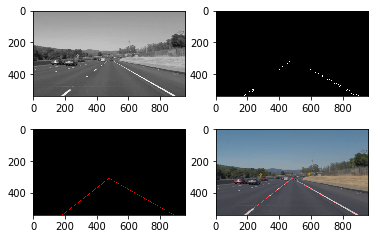

In [17]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))